In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from glob import glob
# Import additional libraries for statistical analysis
from scipy import stats
import json
from pathlib import Path


# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print(" Libraries imported successfully")

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 Libraries imported successfully


In [2]:
# Config
ROOT_DIR = Path("/media/RCPNAS/Data/Delirium/Delirium_Rania")
PREPROC_DIR = ROOT_DIR / "Preproc_current"

## QC Section: SNR Voxelwise Analysis

This section analyzes the voxelwise SNR QC results to determine if preprocessing provides meaningful improvement in data quality.


In [11]:
# Load SNR QC data from all subjects
def load_snr_qc_data(preproc_dir):
    """
    Load SNR QC summary data from all subjects.
    
    Parameters:
    -----------
    preproc_dir : Path
        Path to Preproc_current directory
    
    Returns:
    --------
    snr_data : pd.DataFrame
        DataFrame with SNR metrics for all subjects
    """
    snr_records = []
    
    # Find all subjects with qc_snr directories
    for sub_dir in sorted(preproc_dir.glob("sub-*")):
        if not sub_dir.is_dir():
            continue
        
        sub_id = sub_dir.name
        qc_snr_dir = sub_dir / "qc_snr"
        
        # Check for summary CSV file
        summary_csv = qc_snr_dir / f"{sub_id}_snr_summary.csv"
        stats_json = qc_snr_dir / f"{sub_id}_snr_comparison_stats.json"
        
        if summary_csv.exists():
            try:
                # Load CSV summary
                df_summary = pd.read_csv(summary_csv)
                
                # Extract key metrics
                record = {'subject': sub_id}
                
                # Get mean SNR values
                mean_row = df_summary[df_summary['metric'] == 'mean']
                if len(mean_row) > 0:
                    record['snr_pre'] = mean_row.iloc[0]['preprocessing']
                    record['snr_post'] = mean_row.iloc[0]['postprocessing']
                    record['snr_improvement'] = mean_row.iloc[0]['improvement']
                    record['snr_improvement_pct'] = mean_row.iloc[0]['improvement_pct']
                
                # Get median
                median_row = df_summary[df_summary['metric'] == 'median']
                if len(median_row) > 0:
                    record['snr_pre_median'] = median_row.iloc[0]['preprocessing']
                    record['snr_post_median'] = median_row.iloc[0]['postprocessing']
                
                # Get std
                std_row = df_summary[df_summary['metric'] == 'std']
                if len(std_row) > 0:
                    record['snr_pre_std'] = std_row.iloc[0]['preprocessing']
                    record['snr_post_std'] = std_row.iloc[0]['postprocessing']
                
                # Load JSON for additional details
                if stats_json.exists():
                    with open(stats_json, 'r') as f:
                        stats_data = json.load(f)
                        record['noise_std_global'] = stats_data.get('noise_std_global', np.nan)
                        record['correlation'] = stats_data['statistics']['improvement'].get('correlation', np.nan)
                        record['rmse'] = stats_data['statistics']['improvement'].get('rmse', np.nan)
                        record['n_voxels_improved'] = stats_data['statistics']['voxel_counts'].get('improved', np.nan)
                        record['n_voxels_degraded'] = stats_data['statistics']['voxel_counts'].get('degraded', np.nan)
                        record['n_voxels_total'] = stats_data['statistics']['voxel_counts'].get('total_valid', np.nan)
                
                snr_records.append(record)
                
            except Exception as e:
                print(f"Warning: Failed to load SNR data for {sub_id}: {e}")
                continue
    
    if len(snr_records) == 0:
        print("No SNR QC data found")
        return pd.DataFrame()
    
    return pd.DataFrame(snr_records)

# Load all SNR QC data
snr_df = load_snr_qc_data(PREPROC_DIR)
print(f"\nLoaded SNR QC data for {len(snr_df)} subjects")
if len(snr_df) > 0:
    print(f"\nColumns: {list(snr_df.columns)}")
    print(f"\nFirst few rows:")
    print(snr_df.head())



Loaded SNR QC data for 27 subjects

Columns: ['subject', 'snr_pre', 'snr_post', 'snr_improvement', 'snr_improvement_pct', 'snr_pre_median', 'snr_post_median', 'snr_pre_std', 'snr_post_std', 'noise_std_global', 'correlation', 'rmse', 'n_voxels_improved', 'n_voxels_degraded', 'n_voxels_total']

First few rows:
  subject  snr_pre  snr_post  snr_improvement  snr_improvement_pct  \
0  sub-AD   119.68    134.17            14.48                12.10   
1  sub-AF    27.58     28.89             1.30                 4.72   
2  sub-AM   110.14    124.84            14.71                13.35   
3  sub-AR   117.87    127.42             9.54                 8.10   
4  sub-BA    33.32     32.55            -0.77                -2.31   

   snr_pre_median  snr_post_median  snr_pre_std  snr_post_std  \
0          126.99           139.72        30.90         26.90   
1           27.10            28.22         5.06          6.98   
2          109.44           123.74        43.69         40.59   
3       

In [12]:
# Descriptive statistics for SNR QC
if len(snr_df) > 0:
    print("=" * 80)
    print("SNR QC DESCRIPTIVE STATISTICS")
    print("=" * 80)
    
    print(f"\nN = {len(snr_df)} subjects with SNR QC data")
    
    print(f"\n{'Metric':<30} {'Pre-processing':<20} {'Post-processing':<20} {'Improvement':<20}")
    print("-" * 90)
    
    if 'snr_pre' in snr_df.columns and 'snr_post' in snr_df.columns:
        print(f"{'Mean SNR':<30} {snr_df['snr_pre'].mean():>18.2f} ± {snr_df['snr_pre'].std():>5.2f}  "
              f"{snr_df['snr_post'].mean():>18.2f} ± {snr_df['snr_post'].std():>5.2f}  "
              f"{snr_df['snr_improvement'].mean():>18.2f} ± {snr_df['snr_improvement'].std():>5.2f}")
        
        print(f"{'Median SNR':<30} {snr_df['snr_pre_median'].median():>18.2f}          "
              f"{snr_df['snr_post_median'].median():>18.2f}          "
              f"{snr_df['snr_improvement'].median():>18.2f}")
        
        print(f"{'Range (min-max)':<30} [{snr_df['snr_pre'].min():>6.2f}, {snr_df['snr_pre'].max():>6.2f}]  "
              f"[{snr_df['snr_post'].min():>6.2f}, {snr_df['snr_post'].max():>6.2f}]  "
              f"[{snr_df['snr_improvement'].min():>6.2f}, {snr_df['snr_improvement'].max():>6.2f}]")
    
    if 'snr_improvement_pct' in snr_df.columns:
        print(f"\n{'Percentage Improvement':<30} {snr_df['snr_improvement_pct'].mean():>18.2f}% ± {snr_df['snr_improvement_pct'].std():>5.2f}%")
        print(f"{'Range':<30} [{snr_df['snr_improvement_pct'].min():>6.2f}%, {snr_df['snr_improvement_pct'].max():>6.2f}%]")
    
    if 'correlation' in snr_df.columns:
        print(f"\n{'Correlation (pre vs post)':<30} {snr_df['correlation'].mean():>18.3f} ± {snr_df['correlation'].std():>5.3f}")
    
    print("=" * 80)
else:
    print("No SNR QC data available for analysis")


SNR QC DESCRIPTIVE STATISTICS

N = 27 subjects with SNR QC data

Metric                         Pre-processing       Post-processing      Improvement         
------------------------------------------------------------------------------------------
Mean SNR                                    71.75 ± 44.27               77.79 ± 51.01                6.04 ±  7.24
Median SNR                                  37.24                       36.28                        1.30
Range (min-max)                [ 27.58, 140.00]  [ 27.97, 156.24]  [ -2.25,  19.37]

Percentage Improvement                       5.24% ±  6.42%
Range                          [ -5.08%,  16.95%]

Correlation (pre vs post)                   0.918 ± 0.067


In [13]:
# Statistical tests for SNR improvement
if len(snr_df) > 0 and 'snr_pre' in snr_df.columns and 'snr_post' in snr_df.columns:
    print("=" * 80)
    print("STATISTICAL TESTS FOR SNR IMPROVEMENT")
    print("=" * 80)
    
    # Remove any missing values
    valid_data = snr_df[['snr_pre', 'snr_post']].dropna()
    n_valid = len(valid_data)
    
    if n_valid > 1:
        pre_snr = valid_data['snr_pre'].values
        post_snr = valid_data['snr_post'].values
        diff_snr = post_snr - pre_snr
        
        print(f"\nN = {n_valid} subjects with complete paired data")
        
        # 1. Paired t-test (parametric)
        print("\n1. PAIRED T-TEST (Parametric)")
        print("-" * 80)
        t_stat, pval_ttest = stats.ttest_rel(post_snr, pre_snr)
        print(f"   t-statistic: {t_stat:.4f}")
        print(f"   p-value:     {pval_ttest:.6f}")
        print(f"   Mean difference: {diff_snr.mean():.4f} ± {diff_snr.std():.4f}")
        
        # 95% confidence interval for mean difference
        sem = stats.sem(diff_snr)
        ci_95 = stats.t.interval(0.95, n_valid - 1, loc=diff_snr.mean(), scale=sem)
        print(f"   95% CI for mean difference: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")
        
        if pval_ttest < 0.001:
            significance = "*** (p < 0.001)"
        elif pval_ttest < 0.01:
            significance = "** (p < 0.01)"
        elif pval_ttest < 0.05:
            significance = "* (p < 0.05)"
        else:
            significance = "ns (not significant)"
        print(f"   Result: {significance}")
        
        # 2. Wilcoxon signed-rank test (non-parametric)
        print("\n2. WILCOXON SIGNED-RANK TEST (Non-parametric)")
        print("-" * 80)
        w_stat, pval_wilcoxon = stats.wilcoxon(post_snr, pre_snr, alternative='greater')
        print(f"   W-statistic: {w_stat:.4f}")
        print(f"   p-value:     {pval_wilcoxon:.6f}")
        
        if pval_wilcoxon < 0.001:
            significance = "*** (p < 0.001)"
        elif pval_wilcoxon < 0.01:
            significance = "** (p < 0.01)"
        elif pval_wilcoxon < 0.05:
            significance = "* (p < 0.05)"
        else:
            significance = "ns (not significant)"
        print(f"   Result: {significance}")
        
        # 3. Effect size (Cohen's d for paired samples)
        print("\n3. EFFECT SIZE (Cohen's d for paired samples)")
        print("-" * 80)
        # Cohen's d = mean_diff / std_diff
        cohens_d = diff_snr.mean() / diff_snr.std()
        print(f"   Cohen's d: {cohens_d:.4f}")
        
        if abs(cohens_d) < 0.2:
            effect_size = "negligible"
        elif abs(cohens_d) < 0.5:
            effect_size = "small"
        elif abs(cohens_d) < 0.8:
            effect_size = "medium"
        else:
            effect_size = "large"
        print(f"   Interpretation: {effect_size} effect size")
        
        # 4. Practical significance
        print("\n4. PRACTICAL SIGNIFICANCE")
        print("-" * 80)
        mean_improvement_pct = (diff_snr.mean() / pre_snr.mean()) * 100
        print(f"   Mean improvement: {mean_improvement_pct:.2f}%")
        print(f"   Subjects with improvement: {np.sum(diff_snr > 0)}/{n_valid} ({100*np.sum(diff_snr > 0)/n_valid:.1f}%)")
        print(f"   Subjects with degradation: {np.sum(diff_snr < 0)}/{n_valid} ({100*np.sum(diff_snr < 0)/n_valid:.1f}%)")
        
        # Literature-based interpretation
        print("\n5. LITERATURE-BASED INTERPRETATION")
        print("-" * 80)
        if mean_improvement_pct >= 20:
            print("   ✓ EXCELLENT: Improvement ≥20% (typical for denoising: 20-50%)")
        elif mean_improvement_pct >= 10:
            print("   ✓ GOOD: Improvement ≥10% (moderate preprocessing benefit)")
        elif mean_improvement_pct >= 5:
            print("   → MODERATE: Improvement ≥5% (small but potentially meaningful)")
        else:
            print("   ⚠️  MINIMAL: Improvement <5% (may not be practically meaningful)")
        
        if pval_ttest < 0.05 or pval_wilcoxon < 0.05:
            print("   ✓ STATISTICALLY SIGNIFICANT: Preprocessing provides meaningful improvement")
        else:
            print("   ⚠️  NOT STATISTICALLY SIGNIFICANT: Improvement may be due to chance")
        
        print("=" * 80)
    else:
        print(f"Insufficient data for statistical tests (N = {n_valid})")
else:
    print("No SNR data available for statistical tests")


STATISTICAL TESTS FOR SNR IMPROVEMENT

N = 27 subjects with complete paired data

1. PAIRED T-TEST (Parametric)
--------------------------------------------------------------------------------
   t-statistic: 4.3332
   p-value:     0.000195
   Mean difference: 6.0380 ± 7.1051
   95% CI for mean difference: [3.1738, 8.9022]
   Result: *** (p < 0.001)

2. WILCOXON SIGNED-RANK TEST (Non-parametric)
--------------------------------------------------------------------------------
   W-statistic: 327.0000
   p-value:     0.000457
   Result: *** (p < 0.001)

3. EFFECT SIZE (Cohen's d for paired samples)
--------------------------------------------------------------------------------
   Cohen's d: 0.8498
   Interpretation: large effect size

4. PRACTICAL SIGNIFICANCE
--------------------------------------------------------------------------------
   Mean improvement: 8.42%
   Subjects with improvement: 21/27 (77.8%)
   Subjects with degradation: 6/27 (22.2%)

5. LITERATURE-BASED INTERPRETATION

In [14]:
# Summary table of SNR QC results
if len(snr_df) > 0:
    print("=" * 80)
    print("SNR QC SUMMARY TABLE")
    print("=" * 80)
    
    # Create summary table
    summary_cols = ['subject', 'snr_pre', 'snr_post', 'snr_improvement', 'snr_improvement_pct']
    if 'correlation' in snr_df.columns:
        summary_cols.append('correlation')
    
    summary_df = snr_df[summary_cols].copy()
    summary_df = summary_df.sort_values('snr_improvement_pct', ascending=False)
    
    # Format for display
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', lambda x: f'{x:.2f}' if pd.notna(x) else 'N/A')
    
    print("\nSubjects sorted by improvement percentage:")
    print(summary_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("KEY FINDINGS")
    print("=" * 80)
    
    if 'snr_improvement_pct' in snr_df.columns:
        n_improved = (snr_df['snr_improvement_pct'] > 0).sum()
        n_degraded = (snr_df['snr_improvement_pct'] < 0).sum()
        mean_improvement = snr_df['snr_improvement_pct'].mean()
        
        print(f"• {n_improved}/{len(snr_df)} subjects ({100*n_improved/len(snr_df):.1f}%) showed SNR improvement")
        print(f"• {n_degraded}/{len(snr_df)} subjects ({100*n_degraded/len(snr_df):.1f}%) showed SNR degradation")
        print(f"• Mean improvement: {mean_improvement:.2f}%")
        
        if mean_improvement > 0 and len(snr_df) > 1:
            valid_data = snr_df[['snr_pre', 'snr_post']].dropna()
            if len(valid_data) > 1:
                _, pval = stats.ttest_rel(valid_data['snr_post'], valid_data['snr_pre'])
                if pval < 0.05:
                    print(f"• Statistical significance: YES (p = {pval:.4f})")
                    print("  → Preprocessing provides meaningful SNR improvement")
                else:
                    print(f"• Statistical significance: NO (p = {pval:.4f})")
                    print("  → Improvement may not be statistically meaningful")
    
    print("=" * 80)


SNR QC SUMMARY TABLE

Subjects sorted by improvement percentage:
subject  snr_pre  snr_post  snr_improvement  snr_improvement_pct  correlation
 sub-PC   114.30    133.67            19.37                16.95         0.92
 sub-PL    94.97    110.51            15.54                16.36         0.82
 sub-AM   110.14    124.84            14.71                13.35         0.96
sub-TOG   131.52    148.20            16.69                12.69         0.92
 sub-ZM   115.94    130.27            14.33                12.36         0.96
 sub-AD   119.68    134.17            14.48                12.10         0.97
 sub-GB   140.00    156.24            16.24                11.60         0.97
 sub-SG   127.56    141.80            14.23                11.16         0.90
 sub-FD   131.05    142.93            11.88                 9.06         0.96
 sub-AR   117.87    127.42             9.54                 8.10         0.96
 sub-TL   104.06    111.35             7.29                 7.00         0.97

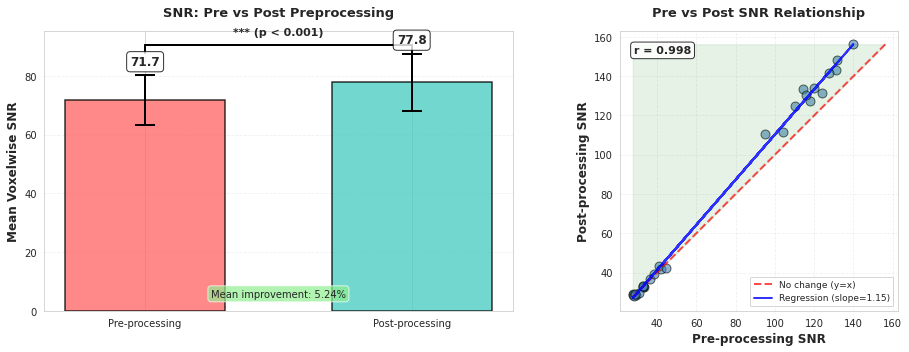


✓ Visualization complete (N = 27 subjects)
  Pre-processing SNR: 71.75 ± 8.52 (SEM)
  Post-processing SNR: 77.79 ± 9.82 (SEM)
  Mean improvement: 5.24%
  Statistical significance: p = 0.000195


In [44]:
# Visualization of SNR before and after preprocessing
if len(snr_df) > 0 and 'snr_pre' in snr_df.columns and 'snr_post' in snr_df.columns:
    # Prepare data for plotting
    valid_data = snr_df[['subject', 'snr_pre', 'snr_post', 'snr_improvement_pct']].dropna()
    
    if len(valid_data) > 0:
        # Create figure with 2 subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Calculate statistics
        pre_mean = valid_data['snr_pre'].mean()
        post_mean = valid_data['snr_post'].mean()
        pre_sem = valid_data['snr_pre'].sem()
        post_sem = valid_data['snr_post'].sem()
        
        # Perform statistical test
        _, pval = stats.ttest_rel(valid_data['snr_post'], valid_data['snr_pre'])
        mean_improvement = valid_data['snr_improvement_pct'].mean()
        
        # ============================================================
        # Plot 1: Bar plot with error bars (Mean ± SEM)
        # ============================================================
        ax1 = axes[0]
        
        # Create bar plot
        conditions = ['Pre-processing', 'Post-processing']
        means = [pre_mean, post_mean]
        sems = [pre_sem, post_sem]
        colors = ['#FF6B6B', '#4ECDC4']
        
        bars = ax1.bar(conditions, means, yerr=sems, capsize=10, 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1.5,
                      width=0.6, error_kw={'elinewidth': 2, 'capthick': 2})
        
        # Add value labels on bars (positioned above error bars)
        for i, (mean, sem) in enumerate(zip(means, sems)):
            # Position label well above the error bar
            label_y = mean + sem + max(means) * 0.03
            ax1.text(i, label_y, f'{mean:.1f}',
                    ha='center', va='bottom', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black', linewidth=1))
        
        # Add significance bracket
        y_max = max(means) + max(sems) + max(means) * 0.1
        y_pos = y_max * 0.95
        
        if pval < 0.001:
            sig_text = '*** (p < 0.001)'
        elif pval < 0.01:
            sig_text = '** (p < 0.01)'
        elif pval < 0.05:
            sig_text = '* (p < 0.05)'
        else:
            sig_text = 'ns (not significant)'
        
        ax1.plot([0, 1], [y_pos, y_pos], 'k-', linewidth=2)
        ax1.plot([0, 0], [y_pos, y_pos*0.97], 'k-', linewidth=2)
        ax1.plot([1, 1], [y_pos, y_pos*0.97], 'k-', linewidth=2)
        ax1.text(0.5, y_pos*1.03, sig_text, ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
        
        # Add improvement annotation
        improvement_text = f'Mean improvement: {mean_improvement:.2f}%'
        ax1.text(0.5, ax1.get_ylim()[0] + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.05,
                improvement_text, ha='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        
        ax1.set_ylabel('Mean Voxelwise SNR', fontsize=12, fontweight='bold')
        ax1.set_title('SNR: Pre vs Post Preprocessing', fontsize=13, fontweight='bold', pad=15)
        ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
        ax1.set_ylim(bottom=0)
        
        # ============================================================
        # Plot 2: Scatter plot (Pre vs Post) with diagonal reference
        # ============================================================
        ax2 = axes[1]
        
        # Create scatter plot
        ax2.scatter(valid_data['snr_pre'], valid_data['snr_post'], 
                   s=80, alpha=0.6, color='steelblue', edgecolors='black', linewidth=1)
        
        # Add diagonal line (y = x) - points above this line show improvement
        min_val = min(valid_data['snr_pre'].min(), valid_data['snr_post'].min())
        max_val = max(valid_data['snr_pre'].max(), valid_data['snr_post'].max())
        ax2.plot([min_val, max_val], [min_val, max_val], 
                'r--', linewidth=2, alpha=0.7, label='No change (y=x)')
        
        # Add regression line
        z = np.polyfit(valid_data['snr_pre'], valid_data['snr_post'], 1)
        p = np.poly1d(z)
        ax2.plot(valid_data['snr_pre'], p(valid_data['snr_pre']), 
                "b-", linewidth=2, alpha=0.8, label=f'Regression (slope={z[0]:.2f})')
        
        # Calculate correlation
        correlation = valid_data['snr_pre'].corr(valid_data['snr_post'])
        
        ax2.set_xlabel('Pre-processing SNR', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Post-processing SNR', fontsize=12, fontweight='bold')
        ax2.set_title('Pre vs Post SNR Relationship', fontsize=13, fontweight='bold', pad=15)
        ax2.legend(loc='lower right', fontsize=9)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.set_aspect('equal', adjustable='box')
        
        # Add correlation text
        ax2.text(0.05, 0.95, f'r = {correlation:.3f}', 
                transform=ax2.transAxes, fontsize=11, fontweight='bold',
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))
        
        # Shade region above diagonal (improvement zone)
        ax2.fill_between([min_val, max_val], [min_val, max_val], [max_val, max_val],
                        alpha=0.1, color='green', label='Improvement zone')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Visualization complete (N = {len(valid_data)} subjects)")
        print(f"  Pre-processing SNR: {pre_mean:.2f} ± {pre_sem:.2f} (SEM)")
        print(f"  Post-processing SNR: {post_mean:.2f} ± {post_sem:.2f} (SEM)")
        print(f"  Mean improvement: {mean_improvement:.2f}%")
        print(f"  Statistical significance: p = {pval:.6f}")
    else:
        print("No valid data for visualization")
else:
    print("SNR data not available for visualization")


#  Connectome Visualization Pipeline

In [15]:
# Configuration
CONNECTOME_TYPE = "SC_sift2"  # Can be changed to other types like "SC_sift2_sizecorr", "COUNT", etc.

print(f"Root directory: {ROOT_DIR}")
print(f"Preprocessing directory: {PREPROC_DIR}")
print(f"Connectome type: {CONNECTOME_TYPE}")


Root directory: /media/RCPNAS/Data/Delirium/Delirium_Rania
Preprocessing directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current
Connectome type: SC_sift2


In [16]:
# Find all subjects with connectome_local folders and valid connectome files
def find_subjects_with_connectomes(preproc_dir, connectome_type="SC_sift2"):
    """
    Find all subjects that have connectome_local folders with the specified connectome type.
    
    Parameters:
    -----------
    preproc_dir : Path
        Path to Preproc_current directory
    connectome_type : str
        Type of connectome to look for (e.g., "SC_sift2", "SC_sift2_sizecorr")
    
    Returns:
    --------
    subjects : dict
        Dictionary mapping subject IDs to their connectome file paths
    """
    subjects = {}
    
    if not preproc_dir.exists():
        print(f"Error: Directory {preproc_dir} does not exist")
        return subjects
    
    # Find all sub-* directories
    for sub_dir in sorted(preproc_dir.glob("sub-*")):
        if not sub_dir.is_dir():
            continue
            
        sub_id = sub_dir.name
        connectome_local = sub_dir / "connectome_local"
        
        # Check if connectome_local folder exists
        if not connectome_local.exists():
            continue
        
        # Look for the connectome file
        connectome_file = connectome_local / f"{sub_id}_{connectome_type}.csv"
        
        if connectome_file.exists():
            subjects[sub_id] = connectome_file
        else:
            print(f"Warning: {sub_id} has connectome_local but missing {connectome_type}.csv")
    
    return subjects

# Find all subjects
subjects = find_subjects_with_connectomes(PREPROC_DIR, CONNECTOME_TYPE)
print(f"\nFound {len(subjects)} subjects with {CONNECTOME_TYPE} connectomes:")
for sub_id in sorted(subjects.keys()):
    print(f"  - {sub_id}")



Found 27 subjects with SC_sift2 connectomes:
  - sub-AD
  - sub-AF
  - sub-AM
  - sub-AR
  - sub-BA
  - sub-CG
  - sub-DA
  - sub-DA2
  - sub-FD
  - sub-FEF
  - sub-FS
  - sub-FSE
  - sub-GB
  - sub-GL
  - sub-KJ
  - sub-LL
  - sub-MF
  - sub-PB
  - sub-PC
  - sub-PL
  - sub-PM
  - sub-PO
  - sub-SA
  - sub-SG
  - sub-TL
  - sub-TOG
  - sub-ZM


In [17]:
# Load connectome matrices
def load_connectome(connectome_path):
    """
    Load a connectome matrix from CSV file.
    
    Parameters:
    -----------
    connectome_path : Path
        Path to the connectome CSV file
    
    Returns:
    --------
    matrix : numpy array
        The connectome matrix
    """
    try:
        matrix = np.loadtxt(str(connectome_path), delimiter=",")
        return matrix
    except Exception as e:
        print(f"Error loading {connectome_path}: {e}")
        return None

# Load all connectomes
connectomes = {}
for sub_id, connectome_path in subjects.items():
    matrix = load_connectome(connectome_path)
    if matrix is not None:
        connectomes[sub_id] = matrix
        print(f"✓ Loaded {sub_id}: shape {matrix.shape}")

print(f"\nSuccessfully loaded {len(connectomes)} connectomes")


✓ Loaded sub-AD: shape (432, 432)
✓ Loaded sub-AF: shape (432, 432)
✓ Loaded sub-AM: shape (432, 432)
✓ Loaded sub-AR: shape (432, 432)
✓ Loaded sub-BA: shape (432, 432)
✓ Loaded sub-CG: shape (432, 432)
✓ Loaded sub-DA: shape (432, 432)
✓ Loaded sub-DA2: shape (432, 432)
✓ Loaded sub-FD: shape (432, 432)
✓ Loaded sub-FEF: shape (432, 432)
✓ Loaded sub-FS: shape (432, 432)
✓ Loaded sub-FSE: shape (432, 432)
✓ Loaded sub-GB: shape (432, 432)
✓ Loaded sub-GL: shape (432, 432)
✓ Loaded sub-KJ: shape (432, 432)
✓ Loaded sub-LL: shape (432, 432)
✓ Loaded sub-MF: shape (432, 432)
✓ Loaded sub-PB: shape (432, 432)
✓ Loaded sub-PC: shape (432, 432)
✓ Loaded sub-PL: shape (432, 432)
✓ Loaded sub-PM: shape (432, 432)
✓ Loaded sub-PO: shape (432, 432)
✓ Loaded sub-SA: shape (432, 432)
✓ Loaded sub-SG: shape (432, 432)
✓ Loaded sub-TL: shape (432, 432)
✓ Loaded sub-TOG: shape (432, 432)
✓ Loaded sub-ZM: shape (432, 432)

Successfully loaded 27 connectomes


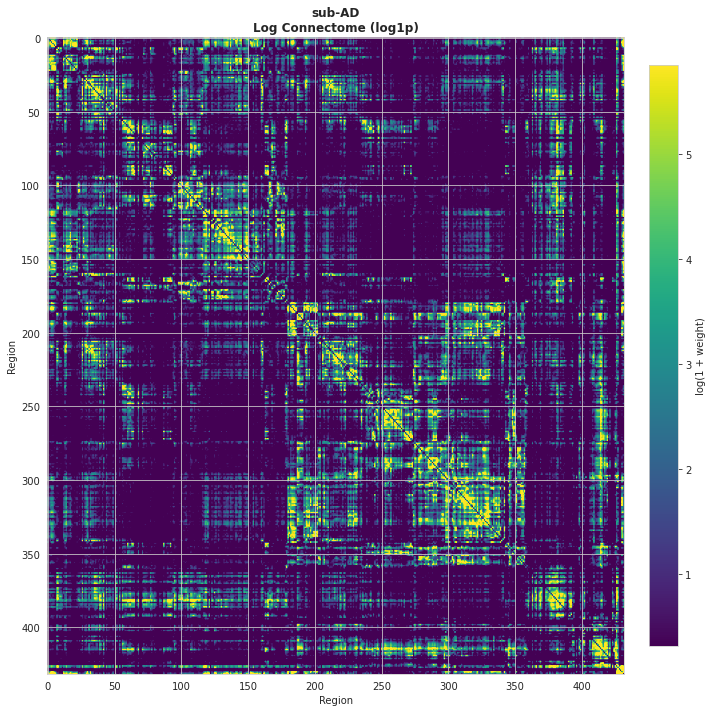

✓ Test plot created for sub-AD


In [18]:
# Function to plot log connectome
def plot_log_connectome(matrix, subject_id, ax=None, cmap='viridis', vmin=None, vmax=None):
    """
    Plot a log-transformed connectome matrix.
    
    Parameters:
    -----------
    matrix : numpy array
        The connectome matrix
    subject_id : str
        Subject identifier for the title
    ax : matplotlib axis, optional
        Axis to plot on. If None, creates a new figure
    cmap : str
        Colormap to use
    vmin, vmax : float, optional
        Value limits for the colormap. If None, uses percentiles
    
    Returns:
    --------
    im : matplotlib image
        The image object
    """
    # Apply log transformation (log1p to handle zeros)
    log_matrix = np.log1p(matrix)
    
    # Set default vmin/vmax based on percentiles if not provided
    if vmin is None or vmax is None:
        nonzero_values = log_matrix[log_matrix > 0]
        if len(nonzero_values) > 0:
            if vmin is None:
                vmin = np.percentile(nonzero_values, 5)
            if vmax is None:
                vmax = np.percentile(nonzero_values, 95)
        else:
            vmin = 0
            vmax = 1
    
    # Create axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the matrix
    im = ax.imshow(log_matrix, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax, origin='upper')
    ax.set_title(f'{subject_id}\nLog Connectome (log1p)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Region', fontsize=10)
    ax.set_ylabel('Region', fontsize=10)
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='log(1 + weight)', fraction=0.046, pad=0.04)
    
    return im

# Test plot for one subject
if len(connectomes) > 0:
    test_subject = list(connectomes.keys())[0]
    test_matrix = connectomes[test_subject]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_log_connectome(test_matrix, test_subject, ax=ax)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Test plot created for {test_subject}")


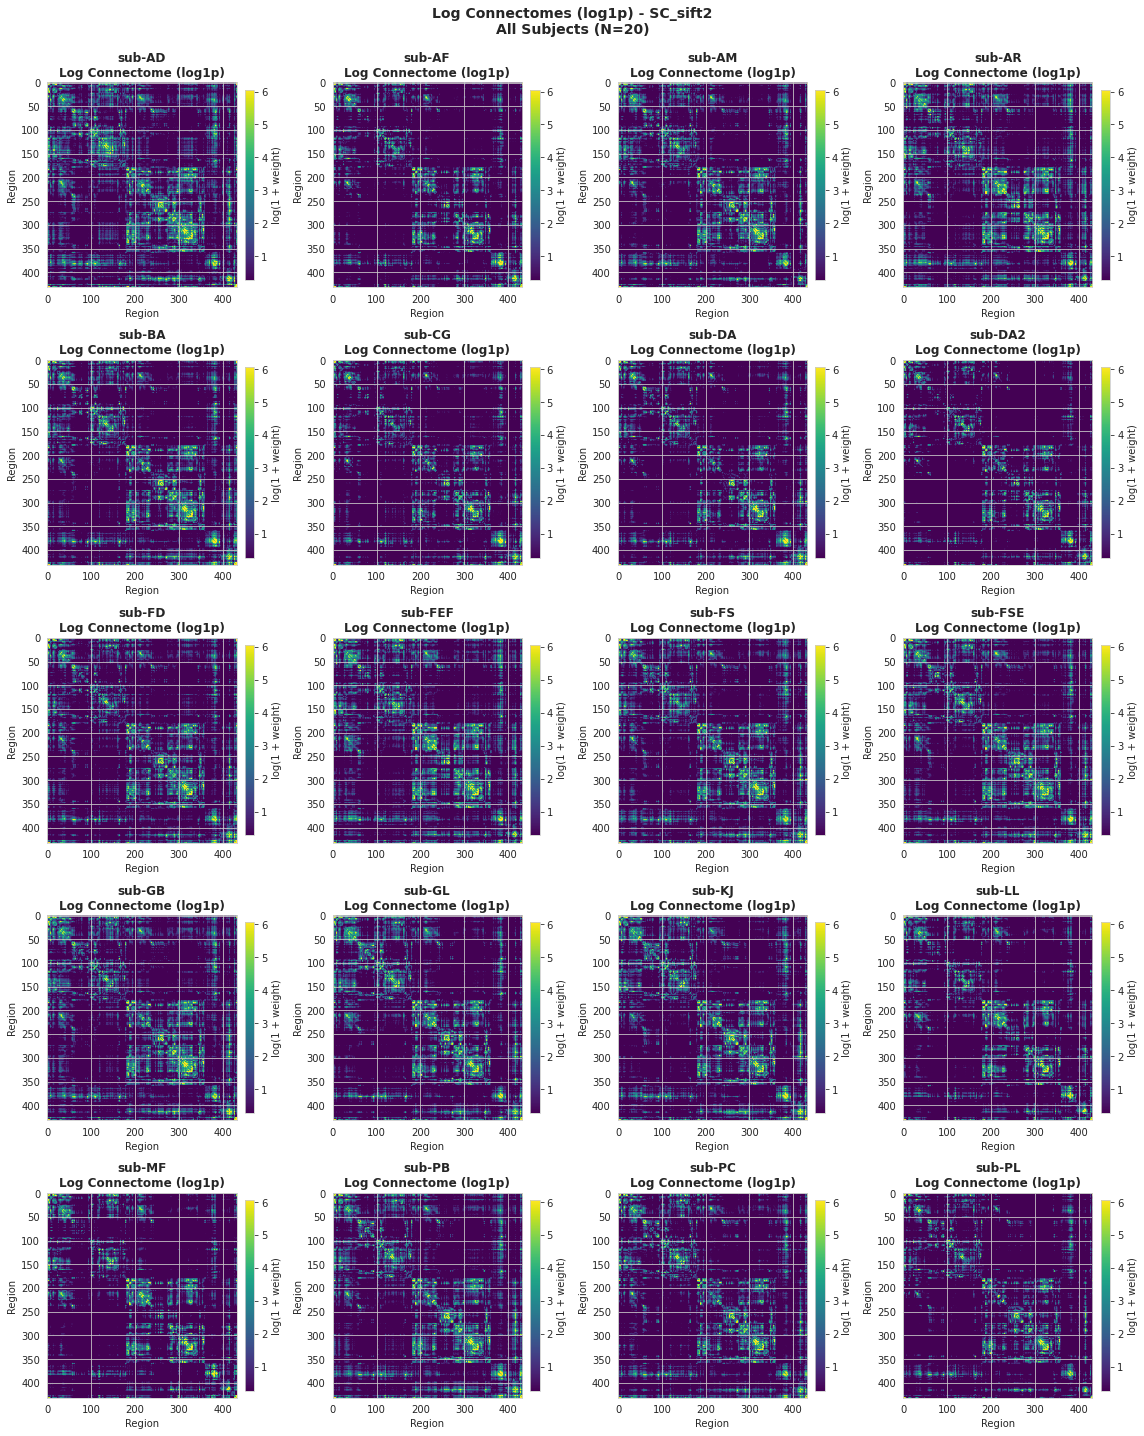

In [21]:
# Plot all individual connectomes in a grid
def plot_all_connectomes(connectomes_dict, max_subjects=None, n_cols=4, figsize_per_subject=(4, 4)):
    """
    Plot all connectomes in a grid layout.
    
    Parameters:
    -----------
    connectomes_dict : dict
        Dictionary mapping subject IDs to connectome matrices
    max_subjects : int, optional
        Maximum number of subjects to plot. If None, plots all
    n_cols : int
        Number of columns in the grid
    figsize_per_subject : tuple
        Figure size per subject subplot
    """
    subjects_to_plot = list(connectomes_dict.keys())
    if max_subjects is not None:
        subjects_to_plot = subjects_to_plot[:max_subjects]
    
    n_subjects = len(subjects_to_plot)
    n_rows = int(np.ceil(n_subjects / n_cols))
    
    # Calculate overall figure size
    fig_width = n_cols * figsize_per_subject[0]
    fig_height = n_rows * figsize_per_subject[1]
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    
    # Handle case where we have only one row or column
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Compute common vmin/vmax across all connectomes for consistent scaling
    all_log_values = []
    for matrix in connectomes_dict.values():
        log_matrix = np.log1p(matrix)
        nonzero_values = log_matrix[log_matrix > 0]
        if len(nonzero_values) > 0:
            all_log_values.extend(nonzero_values)
    
    if len(all_log_values) > 0:
        vmin = np.percentile(all_log_values, 5)
        vmax = np.percentile(all_log_values, 95)
    else:
        vmin = 0
        vmax = 1
    
    # Plot each connectome
    for idx, sub_id in enumerate(subjects_to_plot):
        ax = axes_flat[idx]
        matrix = connectomes_dict[sub_id]
        plot_log_connectome(matrix, sub_id, ax=ax, vmin=vmin, vmax=vmax)
    
    # Hide unused subplots
    for idx in range(n_subjects, len(axes_flat)):
        axes_flat[idx].axis('off')
    
    plt.suptitle(f'Log Connectomes (log1p) - {CONNECTOME_TYPE}\nAll Subjects (N={n_subjects})', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Plot all connectomes (limit to first 20 for now to avoid overwhelming output)
if len(connectomes) > 0:
    plot_all_connectomes(connectomes, max_subjects=20, n_cols=4)


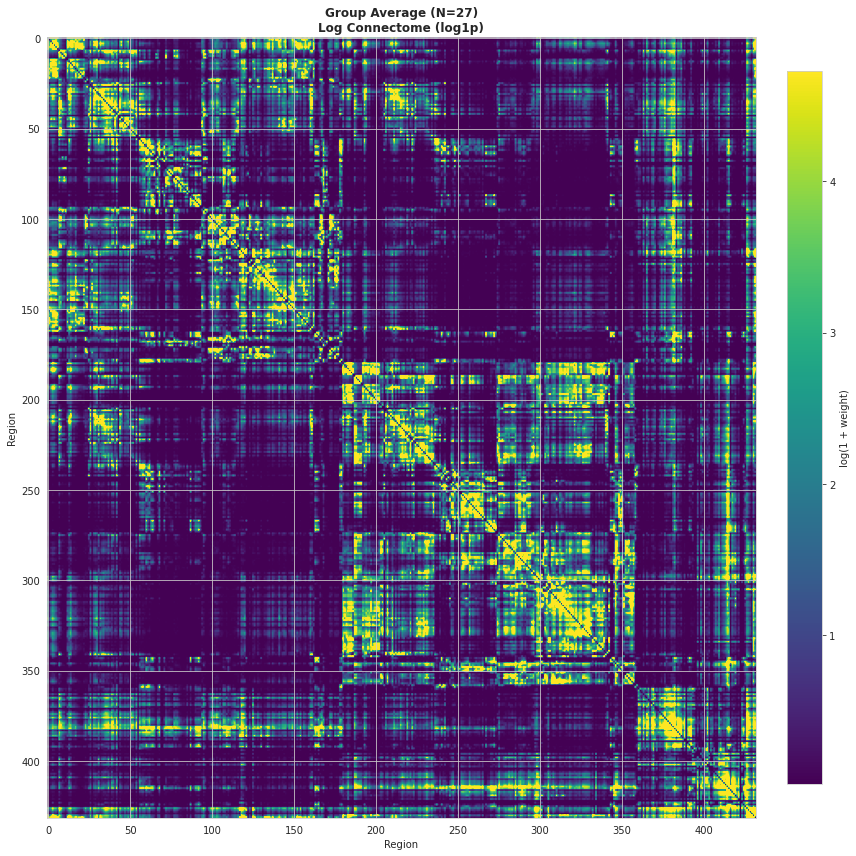

✓ Group average computed for 27 subjects


In [22]:
# Compute group average connectome (for when groups are defined)
def compute_group_average(connectomes_dict, subject_list=None):
    """
    Compute the average connectome across a group of subjects.
    
    Parameters:
    -----------
    connectomes_dict : dict
        Dictionary mapping subject IDs to connectome matrices
    subject_list : list, optional
        List of subject IDs to include. If None, uses all subjects
    
    Returns:
    --------
    avg_matrix : numpy array
        Average connectome matrix
    """
    if subject_list is None:
        subject_list = list(connectomes_dict.keys())
    
    # Filter to only include subjects that exist
    valid_subjects = [s for s in subject_list if s in connectomes_dict]
    
    if len(valid_subjects) == 0:
        print("Error: No valid subjects found")
        return None
    
    # Get matrices
    matrices = [connectomes_dict[s] for s in valid_subjects]
    
    # Check that all matrices have the same shape
    shapes = [m.shape for m in matrices]
    if len(set(shapes)) > 1:
        print(f"Warning: Matrices have different shapes: {set(shapes)}")
        return None
    
    # Compute average
    avg_matrix = np.mean(matrices, axis=0)
    
    return avg_matrix

# Example: Compute average across all subjects (for now)
if len(connectomes) > 0:
    all_subjects_avg = compute_group_average(connectomes)
    
    if all_subjects_avg is not None:
        fig, ax = plt.subplots(figsize=(12, 12))
        plot_log_connectome(all_subjects_avg, f'Group Average (N={len(connectomes)})', ax=ax)
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Group average computed for {len(connectomes)} subjects")


In [23]:
group_ICU=['sub-AF','sub-DA2','sub-PM','sub-BA']
group_delirium=['sub-CG','sub-DA','sub-FS','sub-FSE','sub-GL','sub-KJ','sub-LL','sub-MF','sub-PM','sub-PO','sub-PB','sub-SA']
group_healthy=['sub-FEF','sub-FD','sub-GB','sub-SG','sub-AR','sub-TL','sub-TOG','sub-PL','sub-ZM','sub-AM','sub-PC','sub-AD']

# Size Correction

In [24]:
# Load all subject connectomes (uncorrected and size-corrected)
import glob
import os
import pandas as pd
import numpy as np

DATA_DIR = '/media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current'
N_ROIS = 432
# Find all subjects with both connectomes
subjects = []
uncorrected_files = {}
corrected_files = {}
volume_files = {}

for subj_dir in glob.glob(os.path.join(DATA_DIR, 'sub-*')):
    subj_id = os.path.basename(subj_dir)
    subj_short = subj_id.replace('sub-', '')
    
    uncorr_path = os.path.join(subj_dir, 'connectome_local', f'{subj_id}_SC_sift2.csv')
    corr_path = os.path.join(subj_dir, 'connectome_local', f'{subj_id}_SC_sift2_sizecorr.csv')
    vol_path = os.path.join(subj_dir, 'connectome_local', f'{subj_id}_node_volumes.csv')
    
    if os.path.exists(uncorr_path) and os.path.exists(corr_path):
        subjects.append(subj_short)
        uncorrected_files[subj_short] = uncorr_path
        corrected_files[subj_short] = corr_path
        if os.path.exists(vol_path):
            volume_files[subj_short] = vol_path

print(f"Found {len(subjects)} subjects with both uncorrected and size-corrected connectomes")
print(f"Subjects: {sorted(subjects)}")

# Load connectomes for all subjects
connectomes_uncorr = {}
connectomes_corr = {}
volumes = {}

for subj in subjects:
    # Load connectomes
    connectomes_uncorr[subj] = np.loadtxt(uncorrected_files[subj], delimiter=',')
    connectomes_corr[subj] = np.loadtxt(corrected_files[subj], delimiter=',')
    
    # Load volumes if available
    if subj in volume_files:
        vol_df = pd.read_csv(volume_files[subj])
        volumes[subj] = vol_df['voxels'].values
    
    # Verify dimensions
    assert connectomes_uncorr[subj].shape == connectomes_corr[subj].shape, \
        f"Shape mismatch for {subj}"
    assert connectomes_uncorr[subj].shape[0] == N_ROIS, \
        f"Expected {N_ROIS} ROIs, got {connectomes_uncorr[subj].shape[0]} for {subj}"

print(f"\nLoaded connectomes for {len(connectomes_uncorr)} subjects")
print(f"Connectome shape: {connectomes_uncorr[subjects[0]].shape}")
if volumes:
    print(f"Loaded volumes for {len(volumes)} subjects")


Found 27 subjects with both uncorrected and size-corrected connectomes
Subjects: ['AD', 'AF', 'AM', 'AR', 'BA', 'CG', 'DA', 'DA2', 'FD', 'FEF', 'FS', 'FSE', 'GB', 'GL', 'KJ', 'LL', 'MF', 'PB', 'PC', 'PL', 'PM', 'PO', 'SA', 'SG', 'TL', 'TOG', 'ZM']

Loaded connectomes for 27 subjects
Connectome shape: (432, 432)
Loaded volumes for 27 subjects


In [ ]:
GROUPS = {
    'Group_ICU': ['AF','DA2','PM','BA'],
    'Group_Delirium+ICU': ['CG','DA','FS','FSE','GL','KJ','LL','MF','PM','PO','PB','SA'],
    'Group_Healthy': ['FEF','FD','GB','SG','AR','TL','TOG','PL','ZM','AM','PC','AD']
}
# Helper function to prepare matrices
def prepare_matrix(matrix):
    """Symmetrize, zero diagonal, and handle NaN/inf."""
    sym = 0.5 * (matrix + matrix.T)
    np.fill_diagonal(sym, 0.0)
    sym = np.nan_to_num(sym, nan=0.0, posinf=0.0, neginf=0.0)
    return sym

# Helper function to normalize using log transformation
def normalize_log(data, percentile_range=(10, 90)):
    """Normalize data using log transformation and percentile range."""
    # Apply log(1+x) transformation
    data_log = np.log1p(data)
    
    # Get nonzero values after log transform
    log_nonzero = data_log[data_log > 0]
    if len(log_nonzero) == 0:
        return np.zeros_like(data_log), 0, 0
    
    # Normalize to percentile range
    p_low, p_high = np.percentile(log_nonzero, percentile_range)
    clipped = np.clip(data_log, p_low, p_high)
    
    if p_high > p_low:
        norm = (clipped - p_low) / (p_high - p_low)
    else:
        norm = np.zeros_like(data_log)
    
    norm[data_log < p_low] = 0
    norm[data_log > p_high] = 1
    
    return norm, p_low, p_high


In [26]:

# Load group connectomes
print("Loading group connectomes...")
sift2_groups = {}
sizecorr_groups = {}

for group_name, subjects in GROUPS.items():
    # Sift2
    sift2_matrices = []
    sift2_loaded = []
    for subj in subjects:
        if subj in connectomes_uncorr:
            matrix = prepare_matrix(connectomes_uncorr[subj])
            sift2_matrices.append(matrix)
            sift2_loaded.append(subj)
    
    if len(sift2_matrices) > 0:
        sift2_groups[group_name] = {
            'matrices': sift2_matrices,
            'subjects': sift2_loaded,
            'average': np.mean(np.array(sift2_matrices), axis=0),
            'n': len(sift2_matrices)
        }
        sift2_groups[group_name]['average'] = np.nan_to_num(
            sift2_groups[group_name]['average'], nan=0.0, posinf=0.0, neginf=0.0
        )
    
    # SizeCorr
    sizecorr_matrices = []
    sizecorr_loaded = []
    for subj in subjects:
        if subj in connectomes_corr:
            matrix = prepare_matrix(connectomes_corr[subj])
            sizecorr_matrices.append(matrix)
            sizecorr_loaded.append(subj)
    
    if len(sizecorr_matrices) > 0:
        sizecorr_groups[group_name] = {
            'matrices': sizecorr_matrices,
            'subjects': sizecorr_loaded,
            'average': np.mean(np.array(sizecorr_matrices), axis=0),
            'n': len(sizecorr_matrices)
        }
        sizecorr_groups[group_name]['average'] = np.nan_to_num(
            sizecorr_groups[group_name]['average'], nan=0.0, posinf=0.0, neginf=0.0
        )

# Print summary
print(f"\n{'='*70}")
print("Group Summary:")
print(f"{'='*70}")
for group_name in GROUPS.keys():
    if group_name in sift2_groups:
        print(f"{group_name}: N={sift2_groups[group_name]['n']} subjects")
        print(f"  Subjects: {', '.join(sift2_groups[group_name]['subjects'])}")
    else:
        print(f"{group_name}: No data available")
print()

Loading group connectomes...

Group Summary:
Group_ICU: N=4 subjects
  Subjects: AF, DA2, PM, BA
Group_delirium: N=12 subjects
  Subjects: CG, DA, FS, FSE, GL, KJ, LL, MF, PM, PO, PB, SA
Group_healthy: N=12 subjects
  Subjects: FEF, FD, GB, SG, AR, TL, TOG, PL, ZM, AM, PC, AD




Figure saved: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/three_group_connectome_comparison.png


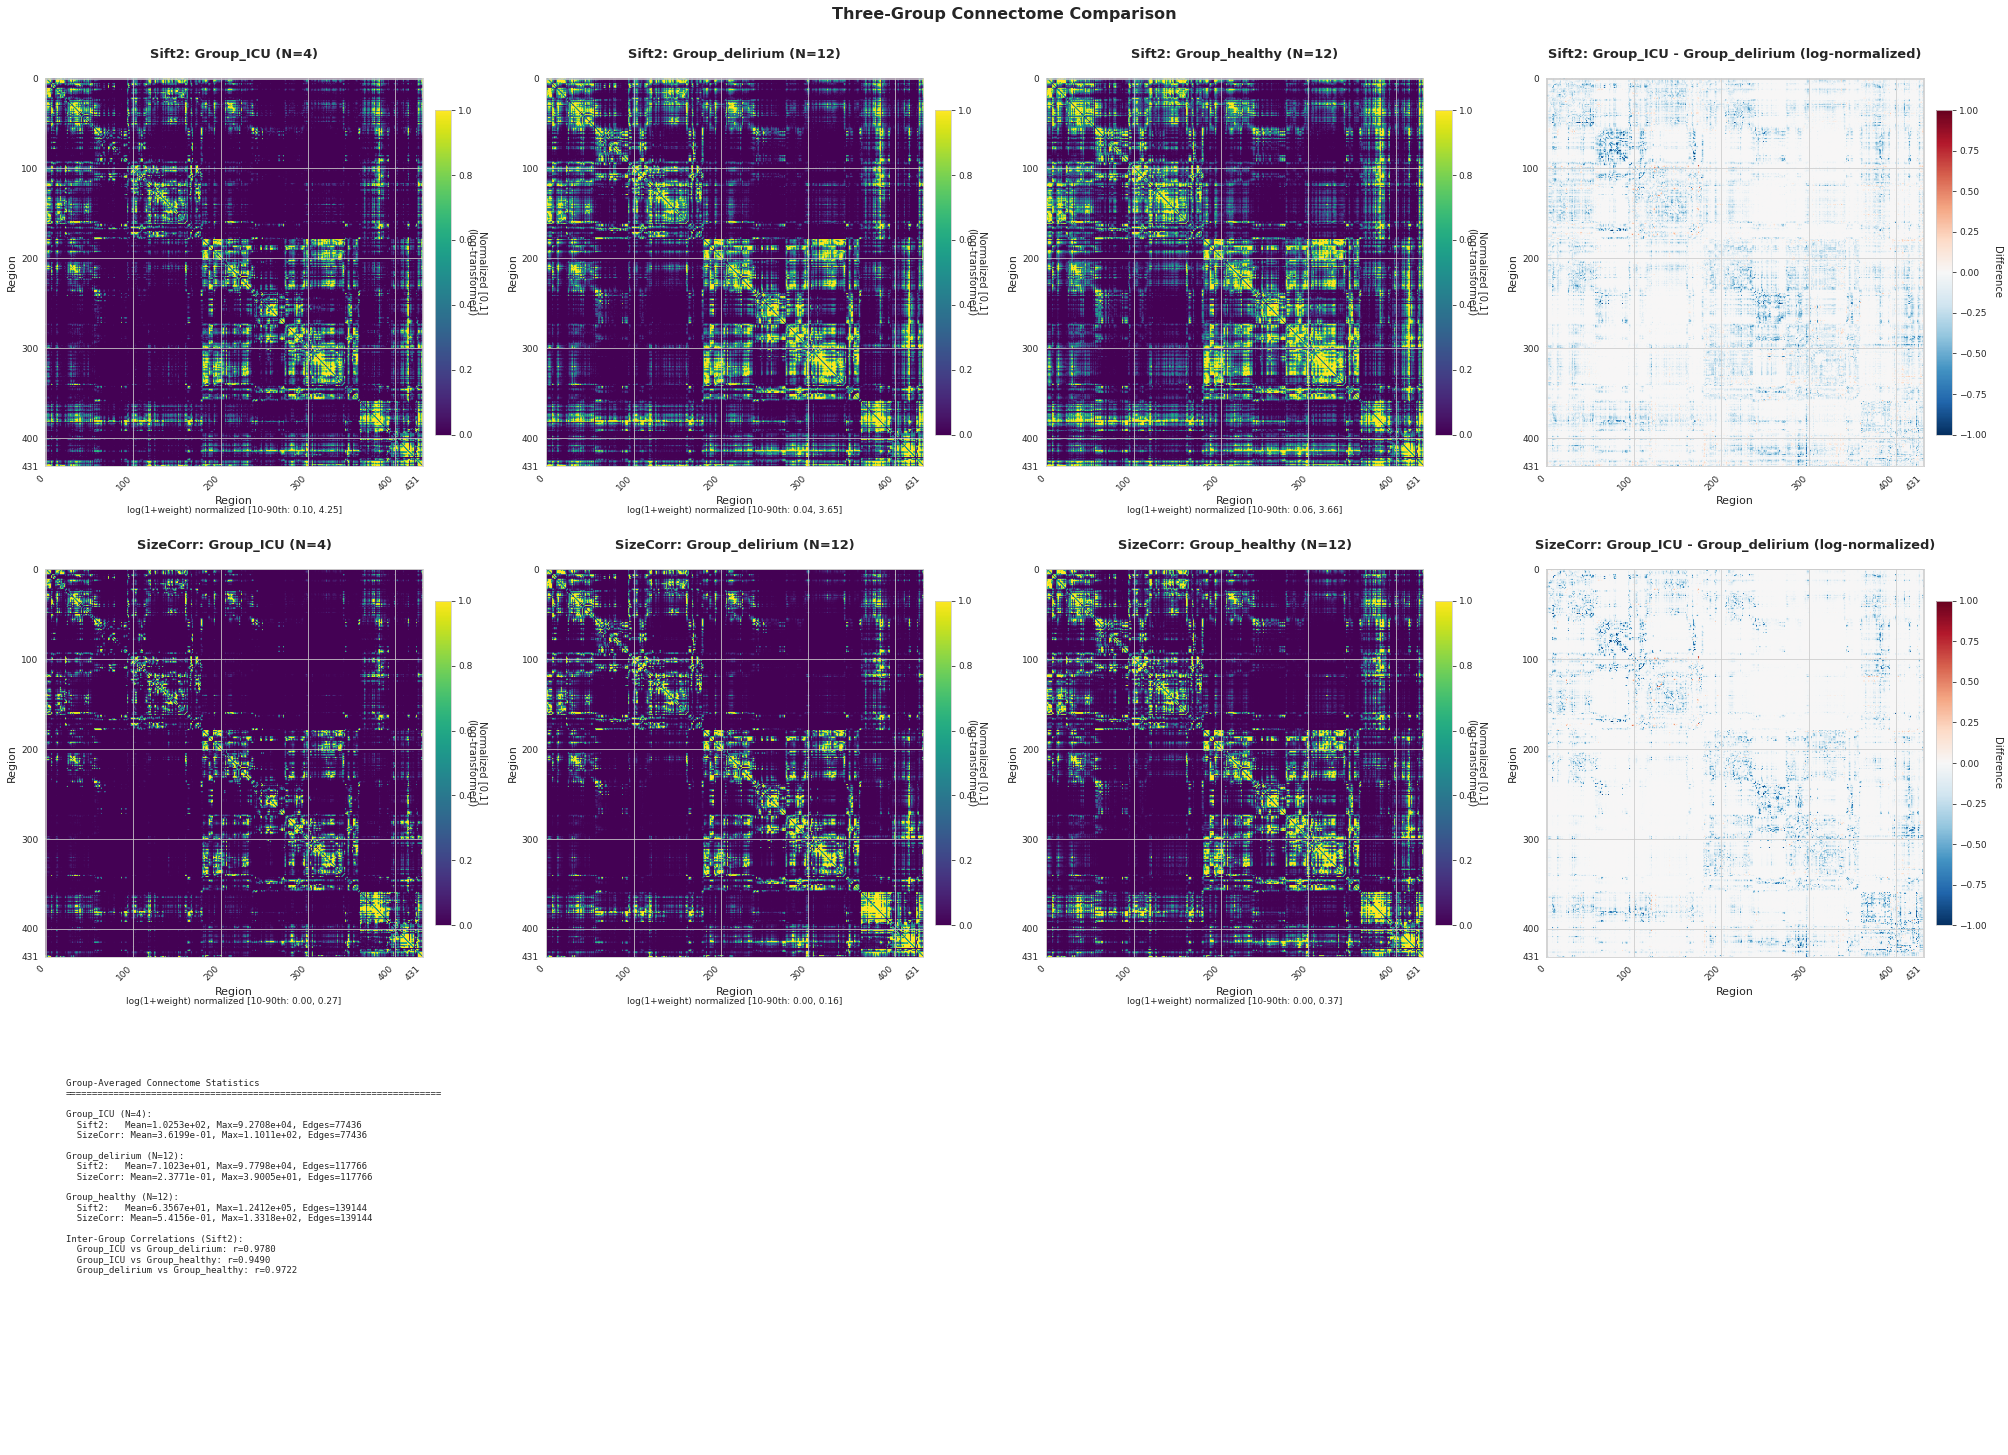


Analysis complete!


In [27]:

# Visualization
fig, axes = plt.subplots(3, 4, figsize=(28, 21))

# Common parameters
cbar_fraction = 0.04
cbar_pad = 0.03
cbar_labelpad = 15
cbar_labelsize = 10
cbar_ticksize = 9

def set_axis_ticks(ax, n_regions, tick_interval=100, fontsize=9, x_rotation=45):
    tick_locations = np.arange(0, n_regions, tick_interval)
    if tick_locations[-1] != n_regions - 1:
        tick_locations = np.append(tick_locations, n_regions - 1)
    if len(tick_locations) > 7:
        key_indices = [0, len(tick_locations)//4, len(tick_locations)//2, 
                      3*len(tick_locations)//4, -1]
        tick_locations = tick_locations[key_indices]
    ax.set_xticks(tick_locations)
    ax.set_yticks(tick_locations)
    ax.set_xticklabels(tick_locations, fontsize=fontsize, rotation=x_rotation, ha='right')
    ax.set_yticklabels(tick_locations, fontsize=fontsize, rotation=0)

group_names = list(GROUPS.keys())

# Row 1: Sift2 group averages (log-normalized)
for i, group_name in enumerate(group_names):
    if group_name in sift2_groups:
        avg = sift2_groups[group_name]['average']
        norm, p_low, p_high = normalize_log(avg, (10, 90))
        
        im = axes[0, i].imshow(norm, cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[0, i].set_title(f'Sift2: {group_name} (N={sift2_groups[group_name]["n"]})', 
                           fontsize=13, fontweight='bold', pad=20)
        axes[0, i].text(0.5, -0.12, f'log(1+weight) normalized [10-90th: {p_low:.2f}, {p_high:.2f}]', 
                       transform=axes[0, i].transAxes, ha='center', fontsize=9)
        axes[0, i].set_xlabel('Region', fontsize=11)
        axes[0, i].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[0, i], n_regions=norm.shape[0], tick_interval=100, 
                      fontsize=9, x_rotation=45)
        cbar = plt.colorbar(im, ax=axes[0, i], fraction=cbar_fraction, pad=cbar_pad)
        cbar.set_label('Normalized [0,1]\n(log-transformed)', labelpad=cbar_labelpad, 
                      fontsize=cbar_labelsize, rotation=270)
        cbar.ax.tick_params(labelsize=cbar_ticksize)
    else:
        axes[0, i].axis('off')

# Difference plot (Group1 - Group2) for Sift2 (log-normalized)
if len(group_names) >= 2 and all(g in sift2_groups for g in group_names[:2]):
    diff = (normalize_log(sift2_groups[group_names[0]]['average'])[0] - 
            normalize_log(sift2_groups[group_names[1]]['average'])[0])
    vmax = np.max(np.abs(diff)) if np.max(np.abs(diff)) > 0 else 1.0
    im = axes[0, 3].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    axes[0, 3].set_title(f'Sift2: {group_names[0]} - {group_names[1]} (log-normalized)', 
                       fontsize=13, fontweight='bold', pad=20)
    axes[0, 3].set_xlabel('Region', fontsize=11)
    axes[0, 3].set_ylabel('Region', fontsize=11)
    set_axis_ticks(axes[0, 3], n_regions=diff.shape[0], tick_interval=100, 
                  fontsize=9, x_rotation=45)
    cbar = plt.colorbar(im, ax=axes[0, 3], fraction=cbar_fraction, pad=cbar_pad)
    cbar.set_label('Difference', labelpad=cbar_labelpad, 
                  fontsize=cbar_labelsize, rotation=270)
    cbar.ax.tick_params(labelsize=cbar_ticksize)
else:
    axes[0, 3].axis('off')

# Row 2: SizeCorr group averages (log-normalized)
for i, group_name in enumerate(group_names):
    if group_name in sizecorr_groups:
        avg = sizecorr_groups[group_name]['average']
        norm, p_low, p_high = normalize_log(avg, (10, 90))
        
        im = axes[1, i].imshow(norm, cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[1, i].set_title(f'SizeCorr: {group_name} (N={sizecorr_groups[group_name]["n"]})', 
                           fontsize=13, fontweight='bold', pad=20)
        axes[1, i].text(0.5, -0.12, f'log(1+weight) normalized [10-90th: {p_low:.2f}, {p_high:.2f}]', 
                       transform=axes[1, i].transAxes, ha='center', fontsize=9)
        axes[1, i].set_xlabel('Region', fontsize=11)
        axes[1, i].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[1, i], n_regions=norm.shape[0], tick_interval=100, 
                      fontsize=9, x_rotation=45)
        cbar = plt.colorbar(im, ax=axes[1, i], fraction=cbar_fraction, pad=cbar_pad)
        cbar.set_label('Normalized [0,1]\n(log-transformed)', labelpad=cbar_labelpad, 
                      fontsize=cbar_labelsize, rotation=270)
        cbar.ax.tick_params(labelsize=cbar_ticksize)
    else:
        axes[1, i].axis('off')

# Difference plot (Group1 - Group2) for SizeCorr (log-normalized)
if len(group_names) >= 2 and all(g in sizecorr_groups for g in group_names[:2]):
    diff = (normalize_log(sizecorr_groups[group_names[0]]['average'])[0] - 
            normalize_log(sizecorr_groups[group_names[1]]['average'])[0])
    vmax = np.max(np.abs(diff)) if np.max(np.abs(diff)) > 0 else 1.0
    im = axes[1, 3].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    axes[1, 3].set_title(f'SizeCorr: {group_names[0]} - {group_names[1]} (log-normalized)', 
                       fontsize=13, fontweight='bold', pad=20)
    axes[1, 3].set_xlabel('Region', fontsize=11)
    axes[1, 3].set_ylabel('Region', fontsize=11)
    set_axis_ticks(axes[1, 3], n_regions=diff.shape[0], tick_interval=100, 
                  fontsize=9, x_rotation=45)
    cbar = plt.colorbar(im, ax=axes[1, 3], fraction=cbar_fraction, pad=cbar_pad)
    cbar.set_label('Difference', labelpad=cbar_labelpad, 
                  fontsize=cbar_labelsize, rotation=270)
    cbar.ax.tick_params(labelsize=cbar_ticksize)
else:
    axes[1, 3].axis('off')

# Row 3: Statistics
axes[2, 0].axis('off')
axes[2, 1].axis('off')
axes[2, 2].axis('off')
axes[2, 3].axis('off')

# Compute statistics
stats_text = "Group-Averaged Connectome Statistics\n" + "="*70 + "\n\n"

for group_name in group_names:
    if group_name in sift2_groups and group_name in sizecorr_groups:
        sift2_avg = sift2_groups[group_name]['average']
        sizecorr_avg = sizecorr_groups[group_name]['average']
        
        sift2_nonzero = sift2_avg[sift2_avg > 0]
        sizecorr_nonzero = sizecorr_avg[sizecorr_avg > 0]
        
        stats_text += f"{group_name} (N={sift2_groups[group_name]['n']}):\n"
        stats_text += f"  Sift2:   Mean={np.mean(sift2_nonzero):.4e}, "
        stats_text += f"Max={np.max(sift2_avg):.4e}, "
        stats_text += f"Edges={len(sift2_nonzero)}\n"
        stats_text += f"  SizeCorr: Mean={np.mean(sizecorr_nonzero):.4e}, "
        stats_text += f"Max={np.max(sizecorr_avg):.4e}, "
        stats_text += f"Edges={len(sizecorr_nonzero)}\n\n"

# Inter-group correlations
if all(g in sift2_groups for g in group_names):
    triu_indices = np.triu_indices_from(sift2_groups[group_names[0]]['average'], k=1)
    
    stats_text += "Inter-Group Correlations (Sift2):\n"
    for i in range(len(group_names)):
        for j in range(i+1, len(group_names)):
            g1_flat = sift2_groups[group_names[i]]['average'][triu_indices]
            g2_flat = sift2_groups[group_names[j]]['average'][triu_indices]
            valid = (g1_flat > 0) & (g2_flat > 0)
            if np.sum(valid) > 0:
                corr = np.corrcoef(g1_flat[valid], g2_flat[valid])[0, 1]
                stats_text += f"  {group_names[i]} vs {group_names[j]}: r={corr:.4f}\n"

axes[2, 0].text(0.05, 0.95, stats_text, fontsize=9, family='monospace',
               verticalalignment='top', horizontalalignment='left',
               transform=axes[2, 0].transAxes)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97], h_pad=3.0, w_pad=2.0)
plt.suptitle('Three-Group Connectome Comparison', 
            fontsize=16, fontweight='bold', y=0.99)

if 'DATA_DIR' in locals():
    plt.savefig(os.path.join(DATA_DIR, 'three_group_connectome_comparison.png'), 
               dpi=300, bbox_inches='tight')
    print(f"\nFigure saved: {os.path.join(DATA_DIR, 'three_group_connectome_comparison.png')}")

plt.show()

print("\nAnalysis complete!")




✓ Figure saved: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/network_metrics_comparison.png


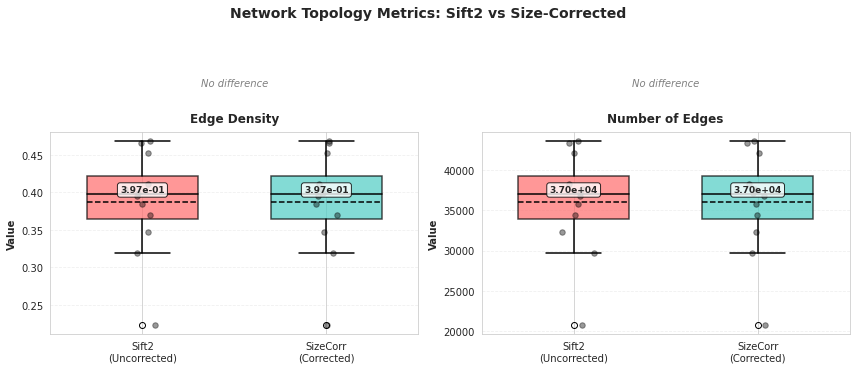


✓ Publication-ready figure created


In [ ]:
# Publication-ready figure: Network metric comparisons (Sift2 vs SizeCorr)
if 'sift2_network_metrics' in locals() and 'sizecorr_network_metrics' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(12, 10))
    fig.suptitle('Network Metric Comparisons: Sift2 vs Size-Corrected', 
                 fontsize=14, fontweight='bold', y=0.995)
    
    # Define metrics and their display names
    metrics = {
        'mean_strength': {'name': 'Mean Edge Strength', 'log_scale': True, 'unit': ''},
        'total_strength': {'name': 'Total Network Strength', 'log_scale': True, 'unit': ''},
        'density': {'name': 'Edge Density', 'log_scale': False, 'unit': ''},
        'n_edges': {'name': 'Number of Edges', 'log_scale': False, 'unit': ''}
    }
    
    # Colors for Sift2 and SizeCorr
    colors = {'Sift2': '#FF6B6B', 'SizeCorr': '#4ECDC4'}
    
    # Plot each metric
    for idx, (metric_name, metric_info) in enumerate(metrics.items()):
        ax = axes[idx // 2, idx % 2]
        
        sift2_vals = sift2_network_metrics[metric_name]
        sizecorr_vals = sizecorr_network_metrics[metric_name]
        
        # Calculate statistics
        sift2_median = np.median(sift2_vals)
        sizecorr_median = np.median(sizecorr_vals)
        sift2_q25, sift2_q75 = np.percentile(sift2_vals, [25, 75])
        sizecorr_q25, sizecorr_q75 = np.percentile(sizecorr_vals, [25, 75])
        
        # Prepare data for boxplot
        positions = [1, 2]
        data_to_plot = [sift2_vals, sizecorr_vals]
        
        # Create boxplot
        bp = ax.boxplot(data_to_plot, positions=positions, widths=0.6, 
                       patch_artist=True, showmeans=True, meanline=True)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], [colors['Sift2'], colors['SizeCorr']]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
            patch.set_edgecolor('black')
            patch.set_linewidth(1.5)
        
        # Style the other elements
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black', linewidth=1.5)
        
        # Add individual data points
        for i, (pos, data) in enumerate(zip(positions, data_to_plot)):
            x_jitter = np.random.normal(pos, 0.04, size=len(data))
            ax.scatter(x_jitter, data, alpha=0.4, s=30, color='black', zorder=3)
        
        # Set x-axis labels
        ax.set_xticks(positions)
        ax.set_xticklabels(['Sift2\n(Uncorrected)', 'SizeCorr\n(Corrected)'], fontsize=10)
        
        # Set y-axis scale
        if metric_info['log_scale']:
            ax.set_yscale('log')
        
        # Add title and labels
        ax.set_title(metric_info['name'], fontsize=12, fontweight='bold', pad=10)
        ax.set_ylabel('Value', fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        
        # Add median values as text
        ax.text(1, sift2_median, f'{sift2_median:.2e}', 
               ha='center', va='bottom', fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black'))
        ax.text(2, sizecorr_median, f'{sizecorr_median:.2e}', 
               ha='center', va='bottom', fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black'))
        
        # Add statistical significance if applicable
        differences = sizecorr_vals - sift2_vals
        if not np.all(differences == 0):
            try:
                from scipy.stats import wilcoxon
                stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='zsplit')
            except:
                try:
                    stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='wilcox')
                except:
                    pval = 1.0
            
            # Add significance bracket
            y_max = max(np.max(sift2_vals), np.max(sizecorr_vals))
            if metric_info['log_scale']:
                y_pos = y_max * 1.5
            else:
                y_pos = y_max * 1.15
            
            if pval < 0.001:
                sig_text = '***'
                sig_label = 'p < 0.001'
            elif pval < 0.01:
                sig_text = '**'
                sig_label = 'p < 0.01'
            elif pval < 0.05:
                sig_text = '*'
                sig_label = 'p < 0.05'
            else:
                sig_text = 'ns'
                sig_label = f'p = {pval:.3f}'
            
            # Draw bracket
            ax.plot([1, 2], [y_pos, y_pos], 'k-', linewidth=2)
            ax.plot([1, 1], [y_pos, y_pos*0.97], 'k-', linewidth=2)
            ax.plot([2, 2], [y_pos, y_pos*0.97], 'k-', linewidth=2)
            ax.text(1.5, y_pos*1.05, sig_text, ha='center', va='bottom', 
                   fontsize=12, fontweight='bold')
            ax.text(1.5, y_pos*1.12, sig_label, ha='center', va='bottom', 
                   fontsize=8)
        else:
            # No difference - add annotation
            y_max = max(np.max(sift2_vals), np.max(sizecorr_vals))
            if metric_info['log_scale']:
                y_pos = y_max * 1.5
            else:
                y_pos = y_max * 1.15
            ax.text(1.5, y_pos, 'No difference', ha='center', va='bottom', 
                   fontsize=10, fontstyle='italic', color='gray')
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    # Save figure
    if 'PREPROC_DIR' in locals() or 'ROOT_DIR' in locals():
        save_dir = PREPROC_DIR if 'PREPROC_DIR' in locals() else ROOT_DIR
        save_path = save_dir / 'network_metrics_comparison.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Figure saved: {save_path}")
    
    plt.show()
    
    print("\n✓ Publication-ready figure created")
else:
    print("Network metrics not available. Run the size correction analysis first.")


In [ ]:
# Statistical verification of size correction effect using non-parametric tests
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

print("="*80)
print("STATISTICAL VERIFICATION OF SIZE CORRECTION EFFECT")
print("="*80)
print("\nUsing non-parametric Wilcoxon signed-rank test (paired data)")
print("Comparing Sift2 (uncorrected) vs SizeCorr (corrected) connectomes\n")

# Extract edge weights for all subjects
subjects_with_both = [s for s in subjects if s in connectomes_uncorr and s in connectomes_corr]
print(f"N = {len(subjects_with_both)} subjects with both connectomes\n")

if len(subjects_with_both) > 0:
    # Get upper triangle indices (avoid diagonal and duplicates)
    n_regions = connectomes_uncorr[subjects_with_both[0]].shape[0]
    triu_indices = np.triu_indices(n_regions, k=1)
    n_edges = len(triu_indices[0])
    
    print(f"Connectome dimensions: {n_regions} × {n_regions} regions")
    print(f"Number of unique edges (upper triangle): {n_edges:,}\n")
    
    # Extract edge weights for all subjects
    sift2_edges = np.zeros((len(subjects_with_both), n_edges))
    sizecorr_edges = np.zeros((len(subjects_with_both), n_edges))
    
    for i, subj in enumerate(subjects_with_both):
        sift2_matrix = prepare_matrix(connectomes_uncorr[subj])
        sizecorr_matrix = prepare_matrix(connectomes_corr[subj])
        
        sift2_edges[i, :] = sift2_matrix[triu_indices]
        sizecorr_edges[i, :] = sizecorr_matrix[triu_indices]
    
    # ========================================================================
    # 1. Overall connectivity strength (mean edge weights)
    # ========================================================================
    print("1. OVERALL CONNECTIVITY STRENGTH")
    print("-" * 80)
    
    sift2_mean_edges = np.mean(sift2_edges, axis=1)  # Mean edge weight per subject
    sizecorr_mean_edges = np.mean(sizecorr_edges, axis=1)
    
    print(f"Sift2 (uncorrected):")
    print(f"  Mean: {np.mean(sift2_mean_edges):.4e} ± {np.std(sift2_mean_edges):.4e}")
    print(f"  Median: {np.median(sift2_mean_edges):.4e}")
    print(f"  Range: [{np.min(sift2_mean_edges):.4e}, {np.max(sift2_mean_edges):.4e}]")
    
    print(f"\nSizeCorr (corrected):")
    print(f"  Mean: {np.mean(sizecorr_mean_edges):.4e} ± {np.std(sizecorr_mean_edges):.4e}")
    print(f"  Median: {np.median(sizecorr_mean_edges):.4e}")
    print(f"  Range: [{np.min(sizecorr_mean_edges):.4e}, {np.max(sizecorr_mean_edges):.4e}]")
    
    # Wilcoxon signed-rank test
    differences = sizecorr_mean_edges - sift2_mean_edges
    if np.all(differences == 0):
        stat = np.nan
        pval = 1.0
        print(f"\nWilcoxon signed-rank test (two-sided):")
        print(f"  No differences detected (all values identical)")
        print(f"  ✗ Not testable (no variation)")
    else:
        try:
            stat, pval = wilcoxon(sift2_mean_edges, sizecorr_mean_edges, alternative='two-sided', zero_method='zsplit')
        except ValueError:
            # Fallback to 'wilcox' method
            try:
                stat, pval = wilcoxon(sift2_mean_edges, sizecorr_mean_edges, alternative='two-sided', zero_method='wilcox')
            except ValueError:
                # If still fails, all differences are zero
                stat = np.nan
                pval = 1.0
        
        print(f"\nWilcoxon signed-rank test (two-sided):")
        print(f"  W-statistic: {stat:.2f}")
        print(f"  p-value: {pval:.6f}")
        print(f"  {'Significant difference' if pval < 0.05 else '✗ No significant difference'} (α=0.05)")
    
    # Effect size (median difference)
    if not np.all(differences == 0):
        median_diff = np.median(differences)
        median_pct_change = 100 * median_diff / np.median(sift2_mean_edges) if np.median(sift2_mean_edges) > 0 else 0
        print(f"\nEffect size:")
        print(f"  Median difference: {median_diff:.4e}")
        print(f"  Median % change: {median_pct_change:.2f}%")
    else:
        median_diff = 0.0
        median_pct_change = 0.0
        print(f"\nEffect size:")
        print(f"  No differences detected")
    
    # ========================================================================
    # 2. Edge-level comparisons (with multiple comparison correction)
    # ========================================================================
    print("\n\n2. EDGE-LEVEL COMPARISONS")
    print("-" * 80)
    print("Testing each edge individually (with FDR correction for multiple comparisons)")
    
    # Test each edge
    edge_pvalues = []
    edge_statistics = []
    edge_median_diffs = []
    
    for edge_idx in range(n_edges):
        sift2_edge_vals = sift2_edges[:, edge_idx]
        sizecorr_edge_vals = sizecorr_edges[:, edge_idx]
        
        # Only test if there are non-zero values
        if np.sum(sift2_edge_vals > 0) > 0 or np.sum(sizecorr_edge_vals > 0) > 0:
            # Check if all differences are zero
            differences = sizecorr_edge_vals - sift2_edge_vals
            if np.all(differences == 0):
                edge_statistics.append(np.nan)
                edge_pvalues.append(1.0)
                edge_median_diffs.append(0.0)
            else:
                try:
                    stat, pval = wilcoxon(sift2_edge_vals, sizecorr_edge_vals, 
                                         alternative='two-sided', zero_method='zsplit')
                    edge_statistics.append(stat)
                    edge_pvalues.append(pval)
                    edge_median_diffs.append(np.median(differences))
                except ValueError:
                    # Try alternative zero_method if zsplit fails
                    try:
                        stat, pval = wilcoxon(sift2_edge_vals, sizecorr_edge_vals, 
                                             alternative='two-sided', zero_method='wilcox')
                        edge_statistics.append(stat)
                        edge_pvalues.append(pval)
                        edge_median_diffs.append(np.median(differences))
                    except ValueError:
                        # All zeros or identical values - skip test
                        edge_statistics.append(np.nan)
                        edge_pvalues.append(1.0)
                        edge_median_diffs.append(0.0)
        else:
            edge_statistics.append(np.nan)
            edge_pvalues.append(1.0)
            edge_median_diffs.append(0.0)
    
    edge_pvalues = np.array(edge_pvalues)
    edge_median_diffs = np.array(edge_median_diffs)
    
    # FDR correction
    valid_pvals = edge_pvalues[~np.isnan(edge_pvalues)]
    if len(valid_pvals) > 0:
        _, edge_pvalues_corrected, _, _ = multipletests(valid_pvals, method='fdr_bh', alpha=0.05)
        
        # Map back to full array
        edge_pvalues_fdr = np.full_like(edge_pvalues, np.nan)
        valid_mask = ~np.isnan(edge_pvalues)
        edge_pvalues_fdr[valid_mask] = edge_pvalues_corrected
        
        n_significant = np.sum(edge_pvalues_fdr < 0.05)
        pct_significant = 100 * n_significant / len(valid_pvals)
        
        print(f"\nResults:")
        print(f"  Total edges tested: {len(valid_pvals):,}")
        print(f"  Significant edges (FDR-corrected, α=0.05): {n_significant:,} ({pct_significant:.2f}%)")
        print(f"  Mean p-value (uncorrected): {np.nanmean(edge_pvalues):.6f}")
        print(f"  Mean p-value (FDR-corrected): {np.nanmean(edge_pvalues_fdr):.6f}")
        
        # Distribution of effect sizes for significant edges
        significant_mask = edge_pvalues_fdr < 0.05
        if np.sum(significant_mask) > 0:
            sig_diffs = edge_median_diffs[significant_mask]
            print(f"\nEffect sizes for significant edges:")
            print(f"  Median difference: {np.median(sig_diffs):.4e}")
            print(f"  Mean difference: {np.mean(sig_diffs):.4e}")
            print(f"  Range: [{np.min(sig_diffs):.4e}, {np.max(sig_diffs):.4e}]")
            print(f"  Edges with increased strength: {np.sum(sig_diffs > 0):,} ({100*np.sum(sig_diffs > 0)/len(sig_diffs):.1f}%)")
            print(f"  Edges with decreased strength: {np.sum(sig_diffs < 0):,} ({100*np.sum(sig_diffs < 0)/len(sig_diffs):.1f}%)")
    
    # ========================================================================
    # 3. Network-level metrics
    # ========================================================================
    print("\n\n3. NETWORK-LEVEL METRICS")
    print("-" * 80)
    
    # Calculate network-level metrics for each subject
    sift2_network_metrics = {
        'mean_strength': [],
        'total_strength': [],
        'density': [],
        'n_edges': []
    }
    sizecorr_network_metrics = {
        'mean_strength': [],
        'total_strength': [],
        'density': [],
        'n_edges': []
    }
    
    for i, subj in enumerate(subjects_with_both):
        sift2_vals = sift2_edges[i, :]
        sizecorr_vals = sizecorr_edges[i, :]
        
        # Mean strength (average of non-zero edges)
        sift2_nonzero = sift2_vals[sift2_vals > 0]
        sizecorr_nonzero = sizecorr_vals[sizecorr_vals > 0]
        
        sift2_network_metrics['mean_strength'].append(np.mean(sift2_nonzero) if len(sift2_nonzero) > 0 else 0)
        sizecorr_network_metrics['mean_strength'].append(np.mean(sizecorr_nonzero) if len(sizecorr_nonzero) > 0 else 0)
        
        # Total strength
        sift2_network_metrics['total_strength'].append(np.sum(sift2_vals))
        sizecorr_network_metrics['total_strength'].append(np.sum(sizecorr_vals))
        
        # Density (proportion of non-zero edges)
        sift2_network_metrics['density'].append(len(sift2_nonzero) / n_edges)
        sizecorr_network_metrics['density'].append(len(sizecorr_nonzero) / n_edges)
        
        # Number of edges
        sift2_network_metrics['n_edges'].append(len(sift2_nonzero))
        sizecorr_network_metrics['n_edges'].append(len(sizecorr_nonzero))
    
    # Convert to arrays
    for key in sift2_network_metrics:
        sift2_network_metrics[key] = np.array(sift2_network_metrics[key])
        sizecorr_network_metrics[key] = np.array(sizecorr_network_metrics[key])
    
    # Test each metric
    print("\nNetwork metric comparisons:")
    for metric_name in ['mean_strength', 'total_strength', 'density', 'n_edges']:
        sift2_vals = sift2_network_metrics[metric_name]
        sizecorr_vals = sizecorr_network_metrics[metric_name]
        
        # Check if all differences are zero
        differences = sizecorr_vals - sift2_vals
        if np.all(differences == 0):
            stat = np.nan
            pval = 1.0
            print(f"\n  {metric_name.replace('_', ' ').title()}:")
            print(f"    Sift2: {np.median(sift2_vals):.4e} | SizeCorr: {np.median(sizecorr_vals):.4e}")
            print(f"    No differences detected (all values identical)")
            print(f"    Not testable (no variation)")
        else:
            try:
                 stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='zsplit')
            except ValueError:
                 # Fallback if zero_method fails
                 try:
                     stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='wilcox')
                 except ValueError:
                     # If still fails, all differences are zero
                     stat = np.nan
                     pval = 1.0
            
            median_diff = np.median(differences)
            median_pct = 100 * median_diff / np.median(sift2_vals) if np.median(sift2_vals) > 0 else 0
            
            print(f"\n  {metric_name.replace('_', ' ').title()}:")
            print(f"    Sift2: {np.median(sift2_vals):.4e} | SizeCorr: {np.median(sizecorr_vals):.4e}")
            print(f"    W={stat:.2f}, p={pval:.6f} | Median diff: {median_diff:.4e} ({median_pct:+.2f}%)")
            print(f"    {' Significant' if pval < 0.05 else '✗ Not significant'}")
    
    
    # ========================================================================
    # 5. Summary
    # ========================================================================
    print("\n\n5. SUMMARY")
    print("="*80)
    print(f" Size correction shows {'significant' if pval < 0.05 else 'no significant'} effect on overall connectivity")
    print(f" {n_significant:,} edges ({pct_significant:.2f}%) show significant differences after FDR correction")
    print(f" Median connectivity change: {median_pct_change:+.2f}%")
    

else:
    print("No subjects with both connectomes available for comparison.")



STATISTICAL VERIFICATION OF SIZE CORRECTION EFFECT

Using non-parametric Wilcoxon signed-rank test (paired data)
Comparing Sift2 (uncorrected) vs SizeCorr (corrected) connectomes

N = 12 subjects with both connectomes

Connectome dimensions: 432 × 432 regions
Number of unique edges (upper triangle): 93,096

1. OVERALL CONNECTIVITY STRENGTH
--------------------------------------------------------------------------------
Sift2 (uncorrected):
  Mean: 4.7504e+01 ± 2.6893e+00
  Median: 4.7752e+01
  Range: [4.2532e+01, 5.1789e+01]

SizeCorr (corrected):
  Mean: 4.0472e-01 ± 3.6442e-02
  Median: 3.9688e-01
  Range: [3.4491e-01, 4.9440e-01]

Wilcoxon signed-rank test (two-sided):
  W-statistic: 0.00
  p-value: 0.000488
  Significant difference (α=0.05)

Effect size:
  Median difference: -4.7315e+01
  Median % change: -99.08%


2. EDGE-LEVEL COMPARISONS
--------------------------------------------------------------------------------
Testing each edge individually (with FDR correction for multip

/home/hatrouho/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "



Results:
  Total edges tested: 93,096
  Significant edges (FDR-corrected, α=0.05): 32,137 (34.52%)
  Mean p-value (uncorrected): 0.365401
  Mean p-value (FDR-corrected): 0.424826

Effect sizes for significant edges:
  Median difference: -3.4817e+00
  Mean difference: -1.1785e+02
  Range: [-1.1334e+05, -1.8013e-01]
  Edges with increased strength: 0 (0.0%)
  Edges with decreased strength: 32,137 (100.0%)


3. NETWORK-LEVEL METRICS
--------------------------------------------------------------------------------

Network metric comparisons:

  Mean Strength:
    Sift2: 1.2299e+02 | SizeCorr: 9.8752e-01
    W=0.00, p=0.000488 | Median diff: -1.2199e+02 (-99.19%)
     Significant

  Total Strength:
    Sift2: 4.4456e+06 | SizeCorr: 3.6948e+04
    W=0.00, p=0.000488 | Median diff: -4.4048e+06 (-99.08%)
     Significant

  Density:
    Sift2: 3.9714e-01 | SizeCorr: 3.9714e-01
    No differences detected (all values identical)
    Not testable (no variation)

  N Edges:
    Sift2: 3.6972e+04 

CORTICAL VS SUBCORTICAL ROI ANALYSIS

Analyzing whether size correction affects cortical and subcortical connections differently
Cortical ROIs: 1-360 | Subcortical ROIs: 361-432

Group-averaged connectomes computed (N=12 subjects)
Connectome shape: (432, 432)

Edge classification:
  Cortical-Cortical: 64,620 edges
  Cortical-Subcortical: 25,920 edges
  Subcortical-Subcortical: 2,556 edges

STATISTICAL COMPARISONS

1. Size Correction Effect Within Each Edge Type:
--------------------------------------------------------------------------------

Cortical Cortical (N=48,953 edges):
  Sift2:     Mean=6.8655e+01, Median=8.8342e-01
  SizeCorr:  Mean=6.3298e-01, Median=9.8873e-03
  Difference: Mean=-6.8022e+01, Median=-8.7280e-01
  % Change:   Mean=-99.08%, Median=-98.80%
  Wilcoxon test: W=0.00, p=0.000000
  ✓ Significant difference (α=0.05)

Cortical Subcortical (N=18,568 edges):
  Sift2:     Mean=3.3321e+01, Median=8.5034e-01
  SizeCorr:  Mean=1.8748e-01, Median=1.5196e-02
  Difference: Mea

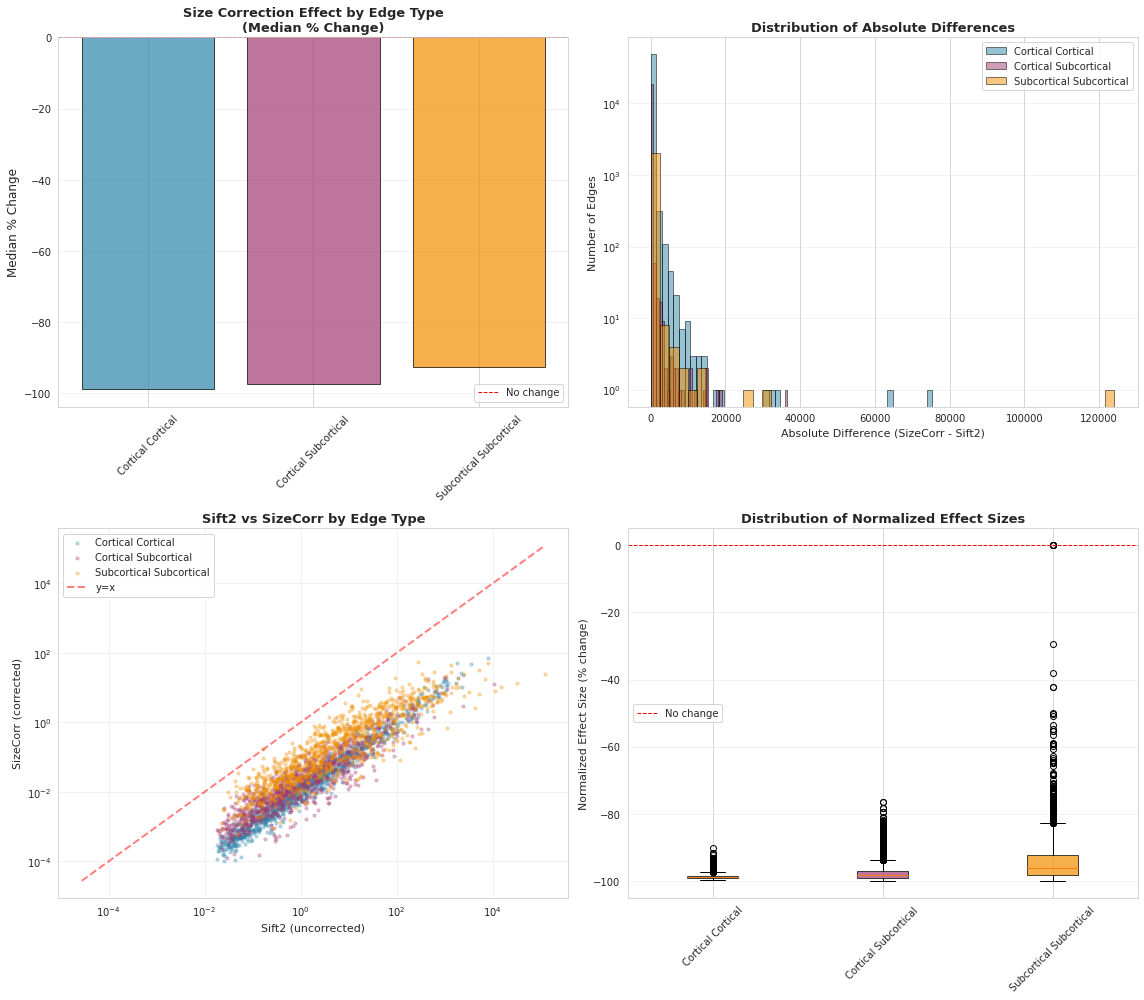



4. SUMMARY
Size correction effects by edge type:
  Cortical Cortical: -98.80% median change
  Cortical Subcortical: -97.41% median change
  Subcortical Subcortical: -92.53% median change

Analysis complete!


In [29]:
# Analysis: Cortical vs Subcortical ROI differences in size correction effect
print("="*80)
print("CORTICAL VS SUBCORTICAL ROI ANALYSIS")
print("="*80)
print("\nAnalyzing whether size correction affects cortical and subcortical connections differently")
print("Cortical ROIs: 1-360 | Subcortical ROIs: 361-432\n")

# Define ROI groups
CORTICAL_ROIS = set(range(1, 361))  # 1-360
SUBCORTICAL_ROIS = set(range(361, 433))  # 361-432

# Get group-averaged connectomes
if len(subjects_with_both) > 0:
    # Compute group-averaged connectomes for Sift2 and SizeCorr
    sift2_group_avg = np.mean(np.array([prepare_matrix(connectomes_uncorr[s]) 
                                        for s in subjects_with_both]), axis=0)
    sizecorr_group_avg = np.mean(np.array([prepare_matrix(connectomes_corr[s]) 
                                           for s in subjects_with_both]), axis=0)
    
    # Clean averages
    sift2_group_avg = np.nan_to_num(sift2_group_avg, nan=0.0, posinf=0.0, neginf=0.0)
    sizecorr_group_avg = np.nan_to_num(sizecorr_group_avg, nan=0.0, posinf=0.0, neginf=0.0)
    
    print(f"Group-averaged connectomes computed (N={len(subjects_with_both)} subjects)")
    print(f"Connectome shape: {sift2_group_avg.shape}\n")
    
    # Classify edges by ROI type
    n_regions = sift2_group_avg.shape[0]
    triu_indices = np.triu_indices(n_regions, k=1)
    
    edge_types = {
        'cortical_cortical': [],
        'cortical_subcortical': [],
        'subcortical_subcortical': []
    }
    
    # Classify each edge
    for edge_idx in range(len(triu_indices[0])):
        i, j = triu_indices[0][edge_idx], triu_indices[1][edge_idx]
        roi_i = i + 1  # Convert to 1-indexed
        roi_j = j + 1
        
        # Determine edge type
        if roi_i in CORTICAL_ROIS and roi_j in CORTICAL_ROIS:
            edge_type = 'cortical_cortical'
        elif (roi_i in CORTICAL_ROIS and roi_j in SUBCORTICAL_ROIS) or \
             (roi_i in SUBCORTICAL_ROIS and roi_j in CORTICAL_ROIS):
            edge_type = 'cortical_subcortical'
        elif roi_i in SUBCORTICAL_ROIS and roi_j in SUBCORTICAL_ROIS:
            edge_type = 'subcortical_subcortical'
        else:
            continue  # Skip if ROI not in expected range
        
        edge_types[edge_type].append(edge_idx)
    
    print("Edge classification:")
    print(f"  Cortical-Cortical: {len(edge_types['cortical_cortical']):,} edges")
    print(f"  Cortical-Subcortical: {len(edge_types['cortical_subcortical']):,} edges")
    print(f"  Subcortical-Subcortical: {len(edge_types['subcortical_subcortical']):,} edges")
    print()
    
    # Extract edge weights for each type
    edge_analysis = {}
    
    for edge_type, edge_indices in edge_types.items():
        sift2_vals = sift2_group_avg[triu_indices][edge_indices]
        sizecorr_vals = sizecorr_group_avg[triu_indices][edge_indices]
        
        # Filter to non-zero edges (at least in one version)
        nonzero_mask = (sift2_vals > 0) | (sizecorr_vals > 0)
        sift2_nonzero = sift2_vals[nonzero_mask]
        sizecorr_nonzero = sizecorr_vals[nonzero_mask]
        
        if len(sift2_nonzero) > 0:
            # Compute statistics
            differences = sizecorr_nonzero - sift2_nonzero
            
            edge_analysis[edge_type] = {
                'sift2': sift2_nonzero,
                'sizecorr': sizecorr_nonzero,
                'differences': differences,
                'n_edges': len(sift2_nonzero),
                'mean_sift2': np.mean(sift2_nonzero),
                'mean_sizecorr': np.mean(sizecorr_nonzero),
                'median_sift2': np.median(sift2_nonzero),
                'median_sizecorr': np.median(sizecorr_nonzero),
                'mean_diff': np.mean(differences),
                'median_diff': np.median(differences),
                'mean_pct_change': 100 * np.mean(differences) / np.mean(sift2_nonzero) if np.mean(sift2_nonzero) > 0 else 0,
                'median_pct_change': 100 * np.median(differences) / np.median(sift2_nonzero) if np.median(sift2_nonzero) > 0 else 0
            }
    
    # ========================================================================
    # Statistical comparisons
    # ========================================================================
    print("="*80)
    print("STATISTICAL COMPARISONS")
    print("="*80)
    
    # 1. Within each edge type: Sift2 vs SizeCorr
    print("\n1. Size Correction Effect Within Each Edge Type:")
    print("-" * 80)
    
    for edge_type in ['cortical_cortical', 'cortical_subcortical', 'subcortical_subcortical']:
        if edge_type in edge_analysis:
            data = edge_analysis[edge_type]
            sift2_vals = data['sift2']
            sizecorr_vals = data['sizecorr']
            differences = data['differences']
            
            print(f"\n{edge_type.replace('_', ' ').title()} (N={data['n_edges']:,} edges):")
            print(f"  Sift2:     Mean={data['mean_sift2']:.4e}, Median={data['median_sift2']:.4e}")
            print(f"  SizeCorr:  Mean={data['mean_sizecorr']:.4e}, Median={data['median_sizecorr']:.4e}")
            print(f"  Difference: Mean={data['mean_diff']:.4e}, Median={data['median_diff']:.4e}")
            print(f"  % Change:   Mean={data['mean_pct_change']:+.2f}%, Median={data['median_pct_change']:+.2f}%")
            
            # Wilcoxon signed-rank test (paired comparison)
            if not np.all(differences == 0):
                try:
                    stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='zsplit')
                    print(f"  Wilcoxon test: W={stat:.2f}, p={pval:.6f}")
                    print(f"  {'✓ Significant difference' if pval < 0.05 else '✗ No significant difference'} (α=0.05)")
                except ValueError:
                    try:
                        stat, pval = wilcoxon(sift2_vals, sizecorr_vals, alternative='two-sided', zero_method='wilcox')
                        print(f"  Wilcoxon test: W={stat:.2f}, p={pval:.6f}")
                        print(f"  {'✓ Significant difference' if pval < 0.05 else '✗ No significant difference'} (α=0.05)")
                    except ValueError:
                        print(f"  ✗ Cannot test (all differences zero)")
            else:
                print(f"  ✗ Cannot test (all differences zero)")
    
    # 2. Between edge types: Compare effect sizes
    print("\n\n2. Comparison of Effect Sizes Between Edge Types:")
    print("-" * 80)
    
    # Extract median percentage changes for comparison
    effect_sizes = {}
    for edge_type in ['cortical_cortical', 'cortical_subcortical', 'subcortical_subcortical']:
        if edge_type in edge_analysis:
            effect_sizes[edge_type] = edge_analysis[edge_type]['median_pct_change']
    
    if len(effect_sizes) >= 2:
        print("\nMedian % change comparison:")
        for edge_type, effect in effect_sizes.items():
            print(f"  {edge_type.replace('_', ' ').title()}: {effect:+.2f}%")
        
        # Compare cortical-cortical vs cortical-subcortical
        if 'cortical_cortical' in effect_sizes and 'cortical_subcortical' in effect_sizes:
            cc_effect = edge_analysis['cortical_cortical']['differences']
            cs_effect = edge_analysis['cortical_subcortical']['differences']
            
            # Normalize by baseline (Sift2) for fair comparison
            cc_normalized = cc_effect / (edge_analysis['cortical_cortical']['sift2'] + 1e-10)
            cs_normalized = cs_effect / (edge_analysis['cortical_subcortical']['sift2'] + 1e-10)
            
                         # Mann-Whitney U test (unpaired, non-parametric)
            try:
                 u_stat, pval = stats.mannwhitneyu(cc_normalized, cs_normalized, alternative='two-sided')
                 print(f"\n  Cortical-Cortical vs Cortical-Subcortical (normalized effect sizes):")
                 print(f"    Mann-Whitney U: U={u_stat:.2f}, p={pval:.6f}")
                 print(f"    {'✓ Significantly different' if pval < 0.05 else '✗ Not significantly different'} (α=0.05)")
            except ValueError:
                 print(f"\n  Cannot compare: insufficient variation")
         
         # Compare cortical-cortical vs subcortical-subcortical
        if 'cortical_cortical' in effect_sizes and 'subcortical_subcortical' in effect_sizes:
             cc_effect = edge_analysis['cortical_cortical']['differences']
             ss_effect = edge_analysis['subcortical_subcortical']['differences']
             
             cc_normalized = cc_effect / (edge_analysis['cortical_cortical']['sift2'] + 1e-10)
             ss_normalized = ss_effect / (edge_analysis['subcortical_subcortical']['sift2'] + 1e-10)
             
             try:
                 u_stat, pval = stats.mannwhitneyu(cc_normalized, ss_normalized, alternative='two-sided')
                 print(f"\n  Cortical-Cortical vs Subcortical-Subcortical (normalized effect sizes):")
                 print(f"    Mann-Whitney U: U={u_stat:.2f}, p={pval:.6f}")
                 print(f"    {'✓ Significantly different' if pval < 0.05 else '✗ Not significantly different'} (α=0.05)")
             except ValueError:
                 print(f"\n  Cannot compare: insufficient variation")
    
    # ========================================================================
    # Visualization
    # ========================================================================
    print("\n\n3. VISUALIZATION")
    print("-" * 80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Plot 1: Effect size comparison (median % change)
    edge_type_labels = [k.replace('_', ' ').title() for k in effect_sizes.keys()]
    effect_values = list(effect_sizes.values())
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    axes[0, 0].bar(edge_type_labels, effect_values, color=colors[:len(effect_values)], alpha=0.7, edgecolor='black')
    axes[0, 0].axhline(0, color='r', linestyle='--', linewidth=1, label='No change')
    axes[0, 0].set_ylabel('Median % Change', fontsize=12)
    axes[0, 0].set_title('Size Correction Effect by Edge Type\n(Median % Change)', 
                        fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Distribution of absolute differences
    for i, (edge_type, data) in enumerate(edge_analysis.items()):
        if edge_type in edge_analysis:
            axes[0, 1].hist(np.abs(data['differences']), bins=50, alpha=0.5, 
                          label=edge_type.replace('_', ' ').title(),
                          color=colors[i], edgecolor='black')
    axes[0, 1].set_xlabel('Absolute Difference (SizeCorr - Sift2)', fontsize=11)
    axes[0, 1].set_ylabel('Number of Edges', fontsize=11)
    axes[0, 1].set_title('Distribution of Absolute Differences', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Scatter plot: Sift2 vs SizeCorr for each edge type
    for i, (edge_type, data) in enumerate(edge_analysis.items()):
        if edge_type in edge_analysis:
            # Sample for visualization if too many points
            n_sample = min(1000, len(data['sift2']))
            if len(data['sift2']) > n_sample:
                indices = np.random.choice(len(data['sift2']), n_sample, replace=False)
                sift2_sample = data['sift2'][indices]
                sizecorr_sample = data['sizecorr'][indices]
            else:
                sift2_sample = data['sift2']
                sizecorr_sample = data['sizecorr']
            
            axes[1, 0].scatter(sift2_sample, sizecorr_sample, alpha=0.3, s=10,
                             label=edge_type.replace('_', ' ').title(), color=colors[i])
    
    # Add diagonal line
    all_sift2 = np.concatenate([data['sift2'] for data in edge_analysis.values()])
    all_sizecorr = np.concatenate([data['sizecorr'] for data in edge_analysis.values()])
    min_val = min(np.min(all_sift2), np.min(all_sizecorr))
    max_val = max(np.max(all_sift2), np.max(all_sizecorr))
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, linewidth=2, label='y=x')
    axes[1, 0].set_xlabel('Sift2 (uncorrected)', fontsize=11)
    axes[1, 0].set_ylabel('SizeCorr (corrected)', fontsize=11)
    axes[1, 0].set_title('Sift2 vs SizeCorr by Edge Type', fontsize=13, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_yscale('log')
    
    # Plot 4: Box plot of normalized effect sizes
    box_data = []
    box_labels = []
    for edge_type in ['cortical_cortical', 'cortical_subcortical', 'subcortical_subcortical']:
        if edge_type in edge_analysis:
            data = edge_analysis[edge_type]
            normalized_effects = data['differences'] / (data['sift2'] + 1e-10) * 100
            box_data.append(normalized_effects)
            box_labels.append(edge_type.replace('_', ' ').title())
    
    if len(box_data) > 0:
        bp = axes[1, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(box_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        axes[1, 1].axhline(0, color='r', linestyle='--', linewidth=1, label='No change')
        axes[1, 1].set_ylabel('Normalized Effect Size (% change)', fontsize=11)
        axes[1, 1].set_title('Distribution of Normalized Effect Sizes', fontsize=13, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    if 'DATA_DIR' in locals():
        plt.savefig(os.path.join(DATA_DIR, 'cortical_subcortical_size_correction_analysis.png'), 
                   dpi=300, bbox_inches='tight')
        print(f"\nFigure saved: cortical_subcortical_size_correction_analysis.png")
    
    plt.show()
    
    # ========================================================================
    # Summary
    # ========================================================================
    print("\n\n4. SUMMARY")
    print("="*80)
    print("Size correction effects by edge type:")
    for edge_type, effect in effect_sizes.items():
        print(f"  {edge_type.replace('_', ' ').title()}: {effect:+.2f}% median change")
    print("\nAnalysis complete!")

else:
    print("No subjects available for analysis.")



# global network topology
of the structural connectome for signs of fragmentation or inefficiency in delirium patients.
Graph-theoretic measures like characteristic path length (the average shortest path between nodes) and global efficiency can quantify how well the brain network integrates information. For example, evidence from postoperative delirium studies shows that patients who developed delirium had a significantly increased characteristic path length in their preoperative structural networks (i.e. longer paths, indicating lower efficiency of the “physical network” connectivity)Consistently, a recent meta-analysis found that risk factors for delirium (such as advanced age) are associated with lower overall structural connectivity strength and a less efficient structural network organization

ANALYSIS 1: OVERALL CONNECTIVITY STRENGTH

Investigating: Does the delirium group show reduced total white matter
connectivity compared to ICU and healthy controls?

Loaded Yeo7 mapping for 430 parcels
Cortical parcels (1-360): 360
Subcortical parcels (361-432): 70

Computed metrics for 28 subjects
Groups: {'Group_delirium': 12, 'Group_healthy': 12, 'Group_ICU': 4}

STATISTICAL COMPARISONS

1. TOTAL CONNECTIVITY STRENGTH
--------------------------------------------------------------------------------
Group_ICU:
  Mean: 2.8031e+04 ± 6.6001e+03
  Median: 2.6870e+04
  Range: [2.1716e+04, 3.6668e+04]
  N: 4
Group_delirium:
  Mean: 2.7994e+04 ± 3.4573e+03
  Median: 2.9123e+04
  Range: [2.2313e+04, 3.2296e+04]
  N: 12
Group_healthy:
  Mean: 7.5355e+04 ± 7.0868e+03
  Median: 7.3896e+04
  Range: [6.4220e+04, 9.2053e+04]
  N: 12

Assumption checks for parametric ANOVA:
  Group_ICU: Shapiro-Wilk p=0.714292 (normal)
  Group_delirium: Shapiro-Wilk p=0.158635 (normal)
  Group_healthy: Shapiro-Wilk 

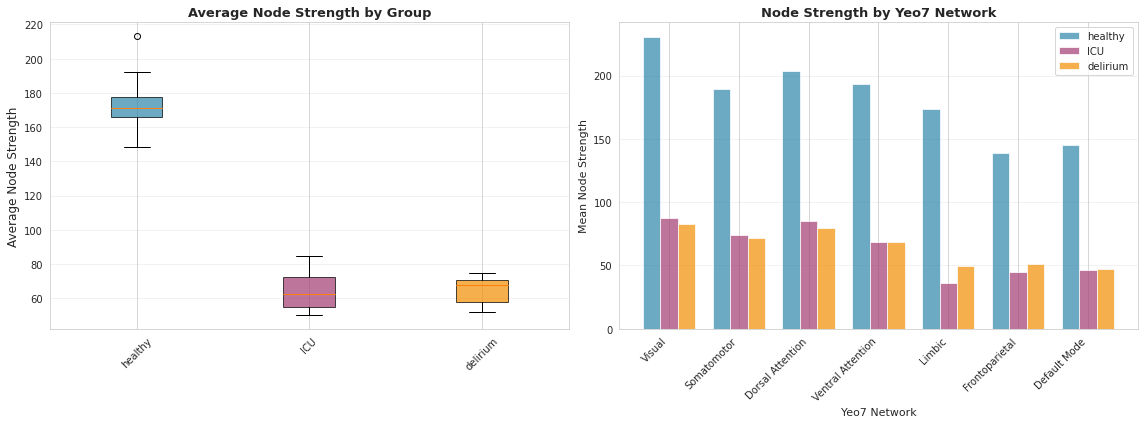



5. SUMMARY
Overall connectivity strength analysis complete!
✓ Analyzed 28 subjects across 3 groups
✓ Computed total strength, average node strength, and Yeo7 network-specific strengths
✓ Performed non-parametric statistical comparisons between groups

Interpretation:
  - Lower total/average strength in delirium suggests global degradation
  - Network-specific differences may reveal selective vulnerability


In [ ]:
# ============================================================================
# GLOBAL NETWORK TOPOLOGY ANALYSIS
# ============================================================================
# Analysis 1: Overall Connectivity Strength
# ============================================================================
# Investigated Topic: Does the delirium group show reduced total white matter 
# connectivity compared to ICU and healthy controls?
# ============================================================================

print("="*80)
print("ANALYSIS 1: OVERALL CONNECTIVITY STRENGTH")
print("="*80)
print("\nInvestigating: Does the delirium group show reduced total white matter")
print("connectivity compared to ICU and healthy controls?\n")

# Load Yeo7 network mapping
yeo7_mapping_path = ROOT_DIR / "atlas" / "final_atlas_to_yeo7.csv"
yeo7_df = pd.read_csv(yeo7_mapping_path)

# Create mapping: parcel_id -> yeo7_network
parcel_to_yeo7 = {}
for _, row in yeo7_df.iterrows():
    parcel_id = int(row['parcel_id'])
    yeo7_network = int(row['yeo7_network']) if pd.notna(row['yeo7_network']) else 0
    parcel_to_yeo7[parcel_id] = yeo7_network

print(f"Loaded Yeo7 mapping for {len(parcel_to_yeo7)} parcels")
print(f"Cortical parcels (1-360): {sum(1 for p in parcel_to_yeo7 if 1 <= p <= 360)}")
print(f"Subcortical parcels (361-432): {sum(1 for p in parcel_to_yeo7 if 361 <= p <= 432)}")
print()

# Define groups (using size-corrected connectomes)
GROUPS = {
    'Group_ICU': ['AF','DA2','PM','BA'],
    'Group_delirium': ['CG','DA','FS','FSE','GL','KJ','LL','MF','PM','PO','PB','SA'],
    'Group_healthy': ['FEF','FD','GB','SG','AR','TL','TOG','PL','ZM','AM','PC','AD']
}

# Compute connectivity strength metrics for each subject
connectivity_metrics = []

for group_name, group_subjects in GROUPS.items():
    for subj in group_subjects:
        if subj in connectomes_corr:
            # Use size-corrected connectome
            matrix = prepare_matrix(connectomes_corr[subj])
            
            # 1. Total connectivity strength (sum of all edge weights)
            total_strength = np.sum(matrix)
            
            # 2. Average node strength (mean of row/column sums)
            node_strengths = np.sum(matrix, axis=1)  # Sum of connections per node
            avg_node_strength = np.mean(node_strengths)
            
            # 3. Strength per Yeo7 network
            # Group nodes by Yeo7 network
            yeo7_strengths = {}
            for parcel_id in range(1, 433):  # 1-432
                if parcel_id in parcel_to_yeo7:
                    yeo7_net = parcel_to_yeo7[parcel_id]
                    node_idx = parcel_id - 1  # Convert to 0-indexed
                    
                    if yeo7_net not in yeo7_strengths:
                        yeo7_strengths[yeo7_net] = []
                    
                    # Node strength for this parcel
                    yeo7_strengths[yeo7_net].append(node_strengths[node_idx])
            
            # Compute mean strength per network
            yeo7_mean_strengths = {}
            for net_id, strengths in yeo7_strengths.items():
                if len(strengths) > 0:
                    yeo7_mean_strengths[net_id] = np.mean(strengths)
            
            # Store metrics
            metrics = {
                'subject': subj,
                'group': group_name,
                'total_strength': total_strength,
                'avg_node_strength': avg_node_strength,
                **{f'yeo7_net_{int(net)}_strength': val for net, val in yeo7_mean_strengths.items()}
            }
            connectivity_metrics.append(metrics)

# Convert to DataFrame
metrics_df = pd.DataFrame(connectivity_metrics)

print(f"Computed metrics for {len(metrics_df)} subjects")
print(f"Groups: {metrics_df['group'].value_counts().to_dict()}\n")

# ========================================================================
# Statistical Analysis
# ========================================================================
print("="*80)
print("STATISTICAL COMPARISONS")
print("="*80)

# 1. Total Connectivity Strength
print("\n1. TOTAL CONNECTIVITY STRENGTH")
print("-" * 80)

for group_name in GROUPS.keys():
    group_data = metrics_df[metrics_df['group'] == group_name]['total_strength']
    print(f"{group_name}:")
    print(f"  Mean: {group_data.mean():.4e} ± {group_data.std():.4e}")
    print(f"  Median: {group_data.median():.4e}")
    print(f"  Range: [{group_data.min():.4e}, {group_data.max():.4e}]")
    print(f"  N: {len(group_data)}")

# Statistical tests between groups
# For 3 independent groups, we use:
# 1. One-way ANOVA (parametric) - requires normality and equal variances
# 2. Kruskal-Wallis test (non-parametric) - no distributional assumptions
# 
# Given small sample sizes and potential non-normality, we'll use both and report the non-parametric result

group_names = list(GROUPS.keys())
all_groups_data = [metrics_df[metrics_df['group'] == g]['total_strength'].dropna().values 
                   for g in group_names]

if all(len(data) > 0 for data in all_groups_data):
    # Check assumptions for parametric ANOVA
    print("\nAssumption checks for parametric ANOVA:")
    from scipy.stats import shapiro, levene
    
    # Normality test (Shapiro-Wilk) for each group
    normality_pvals = []
    for i, (group_name, data) in enumerate(zip(group_names, all_groups_data)):
        if len(data) >= 3 and len(data) <= 5000:  # Shapiro-Wilk works for 3-5000 samples
            try:
                _, p_norm = shapiro(data)
                normality_pvals.append(p_norm)
                print(f"  {group_name}: Shapiro-Wilk p={p_norm:.6f} {'(normal)' if p_norm > 0.05 else '(non-normal)'}")
            except:
                print(f"  {group_name}: Cannot test normality (n={len(data)})")
        else:
            print(f"  {group_name}: Sample size {len(data)} outside Shapiro-Wilk range")
    
    # Equal variances test (Levene's test)
    try:
        levene_stat, p_levene = levene(*all_groups_data)
        print(f"  Levene's test (equal variances): p={p_levene:.6f} {'(equal variances)' if p_levene > 0.05 else '(unequal variances)'}")
    except:
        print(f"  Cannot perform Levene's test")
    
    # Decide: if assumptions met, use ANOVA; otherwise use Kruskal-Wallis
    assumptions_met = all(p > 0.05 for p in normality_pvals) if len(normality_pvals) == len(all_groups_data) else False
    assumptions_met = assumptions_met and (p_levene > 0.05 if 'p_levene' in locals() else False)
    
    print(f"\n  → Assumptions for ANOVA: {'MET' if assumptions_met else 'NOT MET'}")
    print(f"  → Recommendation: Use {'parametric ANOVA' if assumptions_met else 'non-parametric Kruskal-Wallis'}")
    
    # ========================================================================
    # Option 1: One-way ANOVA (parametric)
    # ========================================================================
    print("\n1. ONE-WAY ANOVA (Parametric):")
    print("-" * 80)
    try:
        from scipy.stats import f_oneway
        f_stat, pval_anova = f_oneway(*all_groups_data)
        print(f"  F-statistic: {f_stat:.4f}, p-value: {pval_anova:.6f}")
        print(f"  {'✓ Significant differences detected' if pval_anova < 0.05 else '✗ No significant differences'} (α=0.05)")
        
        if pval_anova < 0.05:
            # Post-hoc: pairwise t-tests with FDR correction
            print("\n  Post-hoc tests (Welch's t-test with FDR correction):")
            try:
                from scipy.stats import ttest_ind
                from statsmodels.stats.multitest import multipletests
                
                pairwise_pvals = []
                pairwise_comparisons = []
                
                for i in range(len(group_names)):
                    for j in range(i+1, len(group_names)):
                        g1_data = all_groups_data[i]
                        g2_data = all_groups_data[j]
                        
                        # Use Welch's t-test (doesn't assume equal variances)
                        t_stat, pval = ttest_ind(g1_data, g2_data, equal_var=False)
                        pairwise_pvals.append(pval)
                        pairwise_comparisons.append((group_names[i], group_names[j], t_stat, pval))
                
                if len(pairwise_pvals) > 0:
                    _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                    
                    for (g1, g2, t_stat, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                        sig = '✓' if pval_corr < 0.05 else '✗'
                        print(f"    {sig} {g1} vs {g2}: t={t_stat:.4f}, p={pval_uncorr:.6f} (FDR-corrected: {pval_corr:.6f})")
            except Exception as e:
                print(f"    Cannot perform post-hoc tests: {e}")
    except Exception as e:
        print(f"  Cannot perform ANOVA: {e}")
    
    # ========================================================================
    # Option 2: Kruskal-Wallis test (non-parametric) - RECOMMENDED
    # ========================================================================
    print("\n2. KRUSKAL-WALLIS TEST (Non-parametric) - RECOMMENDED:")
    print("-" * 80)
    try:
        h_stat, pval_kw = stats.kruskal(*all_groups_data)
        print(f"  H-statistic: {h_stat:.4f}, p-value: {pval_kw:.6f}")
        print(f"  {'✓ Significant differences detected' if pval_kw < 0.05 else '✗ No significant differences'} (α=0.05)")
        
        # Post-hoc: Pairwise Mann-Whitney U tests with FDR correction
        if pval_kw < 0.05:
            print("\n  Post-hoc pairwise comparisons (Mann-Whitney U test with FDR correction):")
            from statsmodels.stats.multitest import multipletests
            pairwise_pvals = []
            pairwise_comparisons = []
            
            for i in range(len(group_names)):
                for j in range(i+1, len(group_names)):
                    g1_data = all_groups_data[i]
                    g2_data = all_groups_data[j]
                    
                    try:
                        u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                        pairwise_pvals.append(pval)
                        pairwise_comparisons.append((group_names[i], group_names[j], u_stat, pval))
                    except ValueError:
                        pass
            
            if len(pairwise_pvals) > 0:
                _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                
                for (g1, g2, u_stat, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                    sig = '✓' if pval_corr < 0.05 else '✗'
                    print(f"    {sig} {g1} vs {g2}: U={u_stat:.2f}, p={pval_uncorr:.6f} (FDR-corrected: {pval_corr:.6f})")
        else:
            print("\n  Omnibus test not significant - skipping pairwise comparisons")
    except ValueError as e:
        print(f"  Cannot perform Kruskal-Wallis test: {e}")
    
    # Summary recommendation
    print("\n" + "="*80)
    print("STATISTICAL RECOMMENDATION:")
    print("="*80)
    if assumptions_met:
        print("  ✓ Assumptions met → Both ANOVA and Kruskal-Wallis are valid")
        print("  → Report both, but prioritize ANOVA (more powerful when assumptions met)")
    else:
        print("  ✗ Assumptions NOT met → Use Kruskal-Wallis (non-parametric)")
        print("  → ANOVA results should be interpreted with caution")
    print("="*80)

# 2. Average Node Strength
print("\n\n2. AVERAGE NODE STRENGTH")
print("-" * 80)

for group_name in GROUPS.keys():
    group_data = metrics_df[metrics_df['group'] == group_name]['avg_node_strength']
    print(f"{group_name}:")
    print(f"  Mean: {group_data.mean():.4e} ± {group_data.std():.4e}")
    print(f"  Median: {group_data.median():.4e}")
    print(f"  Range: [{group_data.min():.4e}, {group_data.max():.4e}]")

print("\nGroup comparisons (Mann-Whitney U test):")
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        g1_data = metrics_df[metrics_df['group'] == group_names[i]]['avg_node_strength'].values
        g2_data = metrics_df[metrics_df['group'] == group_names[j]]['avg_node_strength'].values
        
        if len(g1_data) > 0 and len(g2_data) > 0:
            try:
                u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                print(f"  {group_names[i]} vs {group_names[j]}: U={u_stat:.2f}, p={pval:.6f}")
                print(f"    {'✓ Significant difference' if pval < 0.05 else '✗ No significant difference'} (α=0.05)")
            except ValueError:
                print(f"  {group_names[i]} vs {group_names[j]}: Cannot test")

# 3. Strength per Yeo7 Network
print("\n\n3. STRENGTH PER YEO7 NETWORK")
print("-" * 80)

# Get all Yeo7 network columns
yeo7_cols = [col for col in metrics_df.columns if col.startswith('yeo7_net_')]
yeo7_net_ids = sorted([int(col.split('_')[2]) for col in yeo7_cols])

# Yeo7 network names
yeo7_names = {
    0: 'Subcortical/Unassigned',
    1: 'Visual',
    2: 'Somatomotor',
    3: 'Dorsal Attention',
    4: 'Ventral Attention',
    5: 'Limbic',
    6: 'Frontoparietal',
    7: 'Default Mode'
}

for net_id in yeo7_net_ids:
    col_name = f'yeo7_net_{net_id}_strength'
    if col_name in metrics_df.columns:
        net_name = yeo7_names.get(net_id, f'Network_{net_id}')
        print(f"\n{net_name} (Network {net_id}):")
        
        for group_name in GROUPS.keys():
            group_data = metrics_df[metrics_df['group'] == group_name][col_name].dropna()
            if len(group_data) > 0:
                print(f"  {group_name}: Mean={group_data.mean():.4e} ± {group_data.std():.4e}, "
                      f"Median={group_data.median():.4e}, N={len(group_data)}")
        
        # Group comparisons
        print("  Comparisons:")
        for i in range(len(group_names)):
            for j in range(i+1, len(group_names)):
                g1_data = metrics_df[metrics_df['group'] == group_names[i]][col_name].dropna().values
                g2_data = metrics_df[metrics_df['group'] == group_names[j]][col_name].dropna().values
                
                if len(g1_data) > 0 and len(g2_data) > 0:
                    try:
                        u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                        sig = '✓' if pval < 0.05 else '✗'
                        print(f"    {sig} {group_names[i]} vs {group_names[j]}: p={pval:.6f}")
                    except ValueError:
                        pass

# ========================================================================
# Visualization
# ========================================================================
print("\n\n4. VISUALIZATION")
print("-" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define group order and colors
group_order = ['Group_healthy', 'Group_ICU', 'Group_delirium']
colors = ['#2E86AB', '#A23B72', '#F18F01']

# Plot 1: Average node strength by group
ax2 = axes[0]
data_to_plot = [metrics_df[metrics_df['group'] == g]['avg_node_strength'].values for g in group_order]
bp2 = ax2.boxplot(data_to_plot, labels=[g.replace('Group_', '') for g in group_order], 
                  patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Average Node Strength', fontsize=12)
ax2.set_title('Average Node Strength by Group', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# Plot 2: Strength per Yeo7 network (cortical networks only, excluding 0)
ax3 = axes[1]
cortical_nets = [n for n in yeo7_net_ids if n > 0]
if len(cortical_nets) > 0:
    net_data = []
    net_labels = []
    for net_id in cortical_nets[:7]:  # Limit to first 7 networks
        col_name = f'yeo7_net_{net_id}_strength'
        if col_name in metrics_df.columns:
            net_labels.append(yeo7_names.get(net_id, f'Net{net_id}'))
            group_means = []
            for group_name in group_order:
                group_data = metrics_df[metrics_df['group'] == group_name][col_name].dropna()
                group_means.append(group_data.mean() if len(group_data) > 0 else 0)
            net_data.append(group_means)
    
    if len(net_data) > 0:
        net_data = np.array(net_data)
        x = np.arange(len(net_labels))
        width = 0.25
        for i, group_name in enumerate(group_order):
            ax3.bar(x + i*width, net_data[:, i], width, label=group_name.replace('Group_', ''),
                   color=colors[i], alpha=0.7)
        ax3.set_xlabel('Yeo7 Network', fontsize=11)
        ax3.set_ylabel('Mean Node Strength', fontsize=11)
        ax3.set_title('Node Strength by Yeo7 Network', fontsize=13, fontweight='bold')
        ax3.set_xticks(x + width)
        ax3.set_xticklabels(net_labels, rotation=45, ha='right')
        ax3.legend()
        ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

if 'DATA_DIR' in locals():
    plt.savefig(os.path.join(DATA_DIR, 'overall_connectivity_strength_analysis.png'), 
               dpi=300, bbox_inches='tight')
    print(f"\nFigure saved: overall_connectivity_strength_analysis.png")

plt.show()

# ========================================================================
# Summary
# ========================================================================
print("\n\n5. SUMMARY")
print("="*80)
print("Overall connectivity strength analysis complete!")
print(f"✓ Analyzed {len(metrics_df)} subjects across {len(GROUPS)} groups")
print(f"✓ Computed total strength, average node strength, and Yeo7 network-specific strengths")
print(f"✓ Performed non-parametric statistical comparisons between groups")
print("\nInterpretation:")
print("  - Lower total/average strength in delirium suggests global degradation")
print("  - Network-specific differences may reveal selective vulnerability")



ANALYSIS 2: SUBCORTICAL CONNECTIVITY STRENGTH

Investigating: Does the delirium group show reduced subcortical white matter
connectivity compared to ICU and healthy controls?

Loaded 72 subcortical parcels (361-432)

Subcortical category distribution:
Amygdala          2
Basal Ganglia    10
Brainstem        16
Cerebellum        2
Thalamus         42
Name: category, dtype: int64

Computed metrics for 28 subjects
Groups: {'Group_delirium': 12, 'Group_healthy': 12, 'Group_ICU': 4}

STATISTICAL COMPARISONS

1. TOTAL SUBCORTICAL CONNECTIVITY STRENGTH
--------------------------------------------------------------------------------
Group_ICU:
  Mean: 3.8320e+03 ± 9.6571e+02
  Median: 3.8354e+03
  Range: [2.8614e+03, 4.7957e+03]
  N: 4
Group_delirium:
  Mean: 3.6290e+03 ± 5.8479e+02
  Median: 3.6234e+03
  Range: [2.4437e+03, 4.6190e+03]
  N: 12
Group_healthy:
  Mean: 6.4198e+03 ± 1.6143e+03
  Median: 6.0383e+03
  Range: [4.3787e+03, 9.0225e+03]
  N: 12

Omnibus test (Kruskal-Wallis):
  H-stati

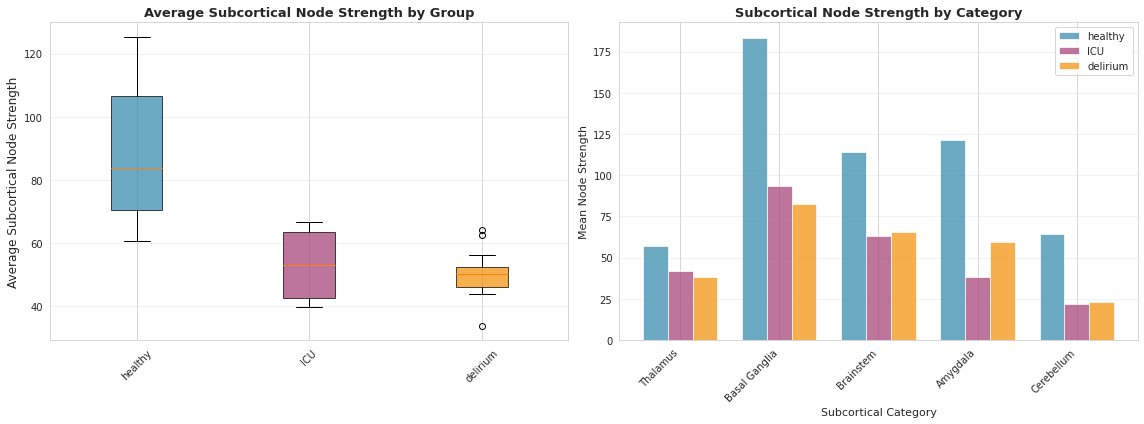



5. SUMMARY
Subcortical connectivity strength analysis complete!
✓ Analyzed 28 subjects across 3 groups
✓ Computed total strength, average node strength, and category-specific strengths
✓ Performed non-parametric statistical comparisons between groups

Interpretation:
  - Lower subcortical strength in delirium suggests subcortical network degradation
  - Category-specific differences may reveal selective subcortical vulnerability


In [50]:
# ============================================================================
# ANALYSIS 2: SUBCORTICAL CONNECTIVITY STRENGTH
# ============================================================================
# Investigated Topic: Does the delirium group show reduced subcortical white matter 
# connectivity compared to ICU and healthy controls?
# ============================================================================

print("="*80)
print("ANALYSIS 2: SUBCORTICAL CONNECTIVITY STRENGTH")
print("="*80)
print("\nInvestigating: Does the delirium group show reduced subcortical white matter")
print("connectivity compared to ICU and healthy controls?\n")

# Load parcels labels Excel file
parcels_labels_path = ROOT_DIR / "atlas" / "parcels_label.xlsx"
parcels_df = pd.read_excel(parcels_labels_path)

# Filter subcortical parcels (361-432)
subcort_df = parcels_df[(parcels_df['parcel_index'] >= 361) & (parcels_df['parcel_index'] <= 432)].copy()

print(f"Loaded {len(subcort_df)} subcortical parcels (361-432)")

# Create mapping function to categorize subcortical regions
def categorize_subcortical(area_desc):
    """
    Categorize subcortical regions into groups:
    - Thalamus: All thalamic nuclei
    - Basal Ganglia: Putamen, Caudate, NAc, Globus pallidus
    - Brainstem: SN, VTA, MB, Septum, Nucleus basalis, Brainstem
    - Amygdala: Amygdala
    - Cerebellum: Cerebellum
    """
    if pd.isna(area_desc):
        return "Unknown"
    
    area_desc = str(area_desc).lower()
    
    if "thalamus" in area_desc:
        return "Thalamus"
    elif any(x in area_desc for x in ["putamen", "caudate", "nucleus accumbens", "globus pallidus"]):
        return "Basal Ganglia"
    elif any(x in area_desc for x in ["substantia nigra", "ventral tegmental", "mammillary", 
                                       "septal", "nucleus basalis", "brainstem"]):
        return "Brainstem"
    elif "amygdala" in area_desc:
        return "Amygdala"
    elif "cerebellum" in area_desc:
        return "Cerebellum"
    else:
        return "Other"

# Add category column
subcort_df['category'] = subcort_df['area_describtion'].apply(categorize_subcortical)

# Create mapping: parcel_index -> category
parcel_to_category = {}
for _, row in subcort_df.iterrows():
    parcel_id = int(row['parcel_index'])
    category = row['category']
    parcel_to_category[parcel_id] = category

# Print category distribution
print("\nSubcortical category distribution:")
print(subcort_df['category'].value_counts().sort_index())
print()

# Define groups (same as Analysis 1)
GROUPS = {
    'Group_ICU': ['AF','DA2','PM','BA'],
    'Group_delirium': ['CG','DA','FS','FSE','GL','KJ','LL','MF','PM','PO','PB','SA'],
    'Group_healthy': ['FEF','FD','GB','SG','AR','TL','TOG','PL','ZM','AM','PC','AD']
}

# Compute connectivity strength metrics for each subject
subcort_connectivity_metrics = []

for group_name, group_subjects in GROUPS.items():
    for subj in group_subjects:
        if subj in connectomes_corr:
            # Use size-corrected connectome
            matrix = prepare_matrix(connectomes_corr[subj])
            
            # Extract subcortical submatrix (parcels 361-432, indices 360-431)
            subcort_indices = list(range(360, 432))  # 0-indexed: 360-431
            subcort_matrix = matrix[np.ix_(subcort_indices, subcort_indices)]
            
            # 1. Total subcortical connectivity strength
            total_subcort_strength = np.sum(subcort_matrix)
            
            # 2. Average subcortical node strength
            subcort_node_strengths = np.sum(subcort_matrix, axis=1)
            avg_subcort_node_strength = np.mean(subcort_node_strengths)
            
            # 3. Strength per category
            # Compute node strength for nodes in each category from the full subcortical matrix
            category_strengths = {}
            for category in ['Thalamus', 'Basal Ganglia', 'Brainstem', 'Amygdala', 'Cerebellum']:
                # Find parcels in this category
                category_parcels = [pid for pid, cat in parcel_to_category.items() if cat == category]
                if len(category_parcels) > 0:
                    # Get indices for these parcels within subcortical matrix (0-indexed: parcel_id - 1, then shift by 360)
                    category_indices = [pid - 1 - 360 for pid in category_parcels if 361 <= pid <= 432]
                    category_indices = [idx for idx in category_indices if 0 <= idx < 72]
                    
                    if len(category_indices) > 0:
                        # Get node strengths for these nodes from the full subcortical matrix
                        cat_node_strengths = subcort_node_strengths[category_indices]
                        category_strengths[category] = np.mean(cat_node_strengths)
            
            # Store metrics
            metrics = {
                'subject': subj,
                'group': group_name,
                'total_subcort_strength': total_subcort_strength,
                'avg_subcort_node_strength': avg_subcort_node_strength,
                **{f'category_{cat.replace(" ", "_").lower()}_strength': val 
                   for cat, val in category_strengths.items()}
            }
            subcort_connectivity_metrics.append(metrics)

# Convert to DataFrame
subcort_metrics_df = pd.DataFrame(subcort_connectivity_metrics)

print(f"Computed metrics for {len(subcort_metrics_df)} subjects")
print(f"Groups: {subcort_metrics_df['group'].value_counts().to_dict()}\n")

# ========================================================================
# Statistical Analysis
# ========================================================================
print("="*80)
print("STATISTICAL COMPARISONS")
print("="*80)

# 1. Total Subcortical Connectivity Strength
print("\n1. TOTAL SUBCORTICAL CONNECTIVITY STRENGTH")
print("-" * 80)

for group_name in GROUPS.keys():
    group_data = subcort_metrics_df[subcort_metrics_df['group'] == group_name]['total_subcort_strength']
    print(f"{group_name}:")
    print(f"  Mean: {group_data.mean():.4e} ± {group_data.std():.4e}")
    print(f"  Median: {group_data.median():.4e}")
    print(f"  Range: [{group_data.min():.4e}, {group_data.max():.4e}]")
    print(f"  N: {len(group_data)}")

# Statistical tests: Kruskal-Wallis + pairwise comparisons
print("\nOmnibus test (Kruskal-Wallis):")
group_names = list(GROUPS.keys())
all_groups_data = [subcort_metrics_df[subcort_metrics_df['group'] == g]['total_subcort_strength'].dropna().values 
                   for g in group_names]
if all(len(data) > 0 for data in all_groups_data):
    try:
        h_stat, pval_kw = stats.kruskal(*all_groups_data)
        print(f"  H-statistic: {h_stat:.4f}, p-value: {pval_kw:.6f}")
        print(f"  {'✓ Significant differences detected' if pval_kw < 0.05 else '✗ No significant differences'} (α=0.05)")
        
        if pval_kw < 0.05:
            print("\nPairwise comparisons (Mann-Whitney U test with FDR correction):")
            from statsmodels.stats.multitest import multipletests
            pairwise_pvals = []
            pairwise_comparisons = []
            
            for i in range(len(group_names)):
                for j in range(i+1, len(group_names)):
                    g1_data = subcort_metrics_df[subcort_metrics_df['group'] == group_names[i]]['total_subcort_strength'].dropna().values
                    g2_data = subcort_metrics_df[subcort_metrics_df['group'] == group_names[j]]['total_subcort_strength'].dropna().values
                    
                    if len(g1_data) > 0 and len(g2_data) > 0:
                        try:
                            u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                            pairwise_pvals.append(pval)
                            pairwise_comparisons.append((group_names[i], group_names[j], u_stat, pval))
                        except ValueError:
                            pass
            
            if len(pairwise_pvals) > 0:
                _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                
                for (g1, g2, u_stat, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                    sig = '✓' if pval_corr < 0.05 else '✗'
                    print(f"  {sig} {g1} vs {g2}: U={u_stat:.2f}, p={pval_uncorr:.6f} (FDR-corrected: {pval_corr:.6f})")
        else:
            print("\n  Omnibus test not significant - skipping pairwise comparisons")
    except ValueError as e:
        print(f"  Cannot perform Kruskal-Wallis test: {e}")

# 2. Average Subcortical Node Strength
print("\n\n2. AVERAGE SUBCORTICAL NODE STRENGTH")
print("-" * 80)

for group_name in GROUPS.keys():
    group_data = subcort_metrics_df[subcort_metrics_df['group'] == group_name]['avg_subcort_node_strength']
    print(f"{group_name}:")
    print(f"  Mean: {group_data.mean():.4e} ± {group_data.std():.4e}")
    print(f"  Median: {group_data.median():.4e}")
    print(f"  Range: [{group_data.min():.4e}, {group_data.max():.4e}]")

# Statistical tests: Kruskal-Wallis + pairwise comparisons
print("\nOmnibus test (Kruskal-Wallis):")
all_groups_data = [subcort_metrics_df[subcort_metrics_df['group'] == g]['avg_subcort_node_strength'].dropna().values 
                   for g in group_names]
if all(len(data) > 0 for data in all_groups_data):
    try:
        h_stat, pval_kw = stats.kruskal(*all_groups_data)
        print(f"  H-statistic: {h_stat:.4f}, p-value: {pval_kw:.6f}")
        print(f"  {'✓ Significant differences detected' if pval_kw < 0.05 else '✗ No significant differences'} (α=0.05)")
        
        if pval_kw < 0.05:
            print("\nPairwise comparisons (Mann-Whitney U test with FDR correction):")
            from statsmodels.stats.multitest import multipletests
            pairwise_pvals = []
            pairwise_comparisons = []
            
            for i in range(len(group_names)):
                for j in range(i+1, len(group_names)):
                    g1_data = subcort_metrics_df[subcort_metrics_df['group'] == group_names[i]]['avg_subcort_node_strength'].dropna().values
                    g2_data = subcort_metrics_df[subcort_metrics_df['group'] == group_names[j]]['avg_subcort_node_strength'].dropna().values
                    
                    if len(g1_data) > 0 and len(g2_data) > 0:
                        try:
                            u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                            pairwise_pvals.append(pval)
                            pairwise_comparisons.append((group_names[i], group_names[j], u_stat, pval))
                        except ValueError:
                            pass
            
            if len(pairwise_pvals) > 0:
                _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                
                for (g1, g2, u_stat, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                    sig = '✓' if pval_corr < 0.05 else '✗'
                    print(f"  {sig} {g1} vs {g2}: U={u_stat:.2f}, p={pval_uncorr:.6f} (FDR-corrected: {pval_corr:.6f})")
        else:
            print("\n  Omnibus test not significant - skipping pairwise comparisons")
    except ValueError as e:
        print(f"  Cannot perform Kruskal-Wallis test: {e}")

# 3. Strength per Category
print("\n\n3. STRENGTH PER SUBCORTICAL CATEGORY")
print("-" * 80)

# Get all category columns
category_cols = [col for col in subcort_metrics_df.columns if col.startswith('category_')]
category_names = {
    'category_thalamus_strength': 'Thalamus',
    'category_basal_ganglia_strength': 'Basal Ganglia',
    'category_brainstem_strength': 'Brainstem',
    'category_amygdala_strength': 'Amygdala',
    'category_cerebellum_strength': 'Cerebellum'
}

for col_name in category_cols:
    if col_name in subcort_metrics_df.columns:
        cat_name = category_names.get(col_name, col_name.replace('category_', '').replace('_', ' ').title())
        print(f"\n{cat_name}:")
        
        for group_name in GROUPS.keys():
            group_data = subcort_metrics_df[subcort_metrics_df['group'] == group_name][col_name].dropna()
            if len(group_data) > 0:
                print(f"  {group_name}: Mean={group_data.mean():.4e} ± {group_data.std():.4e}, "
                      f"Median={group_data.median():.4e}, N={len(group_data)}")
        
        # Group comparisons: Kruskal-Wallis + pairwise
        print("  Omnibus test (Kruskal-Wallis):")
        all_groups_data = [subcort_metrics_df[subcort_metrics_df['group'] == g][col_name].dropna().values 
                          for g in group_names]
        if all(len(data) > 0 for data in all_groups_data):
            try:
                h_stat, pval_kw = stats.kruskal(*all_groups_data)
                sig_kw = '✓' if pval_kw < 0.05 else '✗'
                print(f"    {sig_kw} H={h_stat:.4f}, p={pval_kw:.6f}")
                
                if pval_kw < 0.05:
                    print("  Pairwise comparisons (FDR-corrected):")
                    from statsmodels.stats.multitest import multipletests
                    pairwise_pvals = []
                    pairwise_comparisons = []
                    
                    for i in range(len(group_names)):
                        for j in range(i+1, len(group_names)):
                            g1_data = subcort_metrics_df[subcort_metrics_df['group'] == group_names[i]][col_name].dropna().values
                            g2_data = subcort_metrics_df[subcort_metrics_df['group'] == group_names[j]][col_name].dropna().values
                            
                            if len(g1_data) > 0 and len(g2_data) > 0:
                                try:
                                    u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                                    pairwise_pvals.append(pval)
                                    pairwise_comparisons.append((group_names[i], group_names[j], pval))
                                except ValueError:
                                    pass
                    
                    if len(pairwise_pvals) > 0:
                        _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                        
                        for (g1, g2, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                            sig = '✓' if pval_corr < 0.05 else '✗'
                            print(f"    {sig} {g1} vs {g2}: p={pval_uncorr:.6f} (FDR: {pval_corr:.6f})")
            except ValueError:
                pass

# ========================================================================
# Visualization
# ========================================================================
print("\n\n4. VISUALIZATION")
print("-" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define group order and colors
group_order = ['Group_healthy', 'Group_ICU', 'Group_delirium']
colors = ['#2E86AB', '#A23B72', '#F18F01']

# Plot 1: Average subcortical node strength by group
ax1 = axes[0]
data_to_plot = [subcort_metrics_df[subcort_metrics_df['group'] == g]['avg_subcort_node_strength'].values for g in group_order]
bp1 = ax1.boxplot(data_to_plot, labels=[g.replace('Group_', '') for g in group_order], 
                  patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Average Subcortical Node Strength', fontsize=12)
ax1.set_title('Average Subcortical Node Strength by Group', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Strength per Category (bar chart)
ax2 = axes[1]
# Get available categories
available_categories = []
category_data = []
for col_name in category_cols:
    if col_name in subcort_metrics_df.columns:
        cat_name = category_names.get(col_name, col_name.replace('category_', '').replace('_', ' ').title())
        available_categories.append(cat_name)
        group_means = []
        for group_name in group_order:
            group_data = subcort_metrics_df[subcort_metrics_df['group'] == group_name][col_name].dropna()
            group_means.append(group_data.mean() if len(group_data) > 0 else 0)
        category_data.append(group_means)

if len(category_data) > 0:
    category_data = np.array(category_data)
    x = np.arange(len(available_categories))
    width = 0.25
    for i, group_name in enumerate(group_order):
        ax2.bar(x + i*width, category_data[:, i], width, label=group_name.replace('Group_', ''),
               color=colors[i], alpha=0.7)
    ax2.set_xlabel('Subcortical Category', fontsize=11)
    ax2.set_ylabel('Mean Node Strength', fontsize=11)
    ax2.set_title('Subcortical Node Strength by Category', fontsize=13, fontweight='bold')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(available_categories, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

if 'DATA_DIR' in locals():
    plt.savefig(os.path.join(DATA_DIR, 'subcortical_connectivity_strength_analysis.png'), 
               dpi=300, bbox_inches='tight')
    print(f"\nFigure saved: subcortical_connectivity_strength_analysis.png")

plt.show()

# ========================================================================
# Summary
# ========================================================================
print("\n\n5. SUMMARY")
print("="*80)
print("Subcortical connectivity strength analysis complete!")
print(f"✓ Analyzed {len(subcort_metrics_df)} subjects across {len(GROUPS)} groups")
print(f"✓ Computed total strength, average node strength, and category-specific strengths")
print(f"✓ Performed non-parametric statistical comparisons between groups")
print("\nInterpretation:")
print("  - Lower subcortical strength in delirium suggests subcortical network degradation")
print("  - Category-specific differences may reveal selective subcortical vulnerability")



ANALYSIS 2: CHARACTERISTIC PATH LENGTH / GLOBAL EFFICIENCY

Investigating: Do delirium patients have longer path lengths and
reduced integration in their structural network compared to controls?

Using bctpy (Brain Connectivity Toolbox) for graph metrics

Normalization settings:
  Normalize by: mean of non-zero weights
  Target density: 0.15
  Log transform: False

Computed efficiency metrics for 28 subjects
Groups: {'Group_delirium': 12, 'Group_healthy': 12, 'Group_ICU': 4}

STATISTICAL COMPARISONS

1. GLOBAL EFFICIENCY
--------------------------------------------------------------------------------
Group_ICU:
  Mean:   0.382770 ± 0.111869
  Median: 0.388251
  Range:  [0.254099, 0.500480]
  N:      4
Group_delirium:
  Mean:   0.434261 ± 0.078571
  Median: 0.439467
  Range:  [0.260983, 0.529689]
  N:      12
Group_healthy:
  Mean:   0.476266 ± 0.060542
  Median: 0.493902
  Range:  [0.358100, 0.546401]
  N:      12

Omnibus test (Kruskal-Wallis):
  H-statistic: 3.5749, p-value: 0.167389

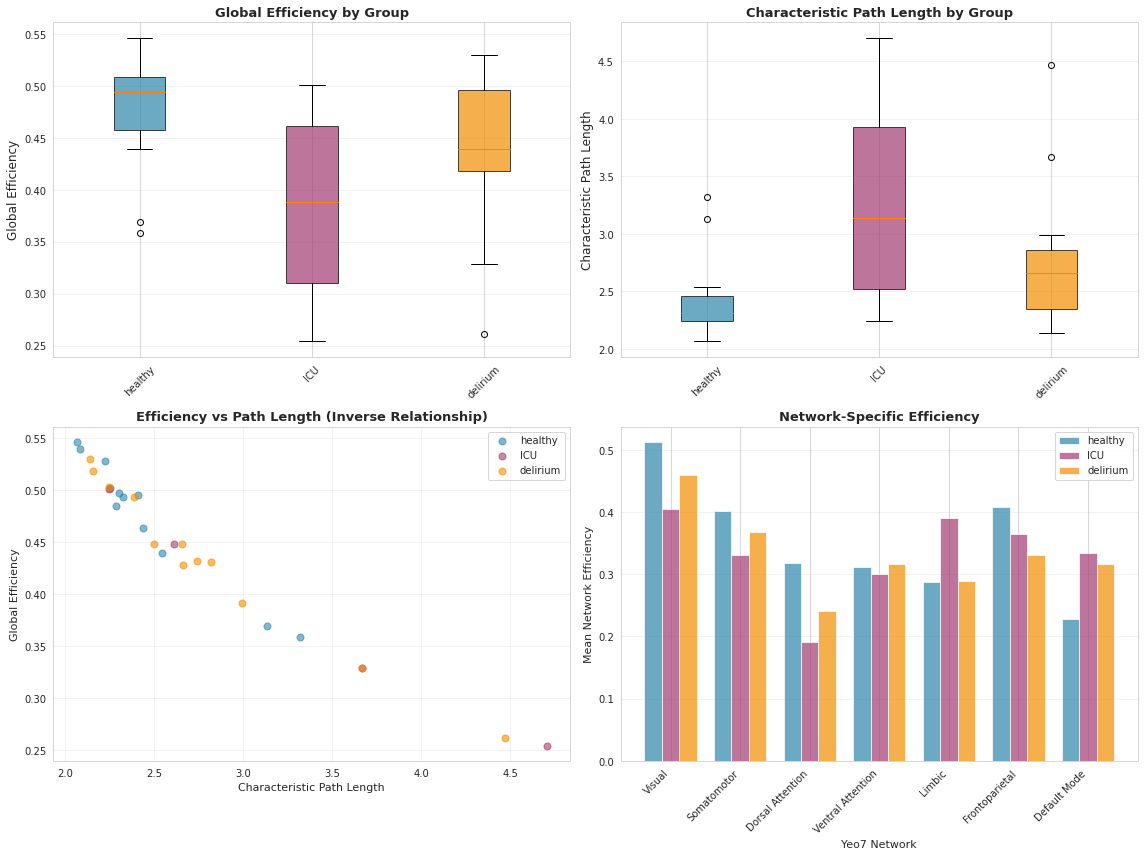



5. SUMMARY
Characteristic path length and global efficiency analysis complete!
✓ Analyzed 28 subjects across 3 groups
✓ Computed whole-brain and network-specific efficiency and path length
✓ Performed non-parametric statistical comparisons

Interpretation hints:
  - Longer path length → impaired structural integration
  - Reduced efficiency → less coordinated information flow
  - Compare global vs network-wise patterns for segregation vs integration


In [51]:
# ============================================================================
# Analysis 2: Characteristic Path Length / Global Efficiency
# ============================================================================
# Investigated Topic: Do delirium patients have longer path lengths and 
# reduced integration in their structural network compared to controls?
# ============================================================================

print("="*80)
print("ANALYSIS 2: CHARACTERISTIC PATH LENGTH / GLOBAL EFFICIENCY")
print("="*80)
print("\nInvestigating: Do delirium patients have longer path lengths and")
print("reduced integration in their structural network compared to controls?\n")

# Try to import bctpy, fallback to networkx if not available
try:
    import bct
    USE_BCT = True
    print("Using bctpy (Brain Connectivity Toolbox) for graph metrics")
except ImportError:
    USE_BCT = False
    import networkx as nx
    print("bctpy not available, using NetworkX for graph metrics")
    print("Note: For more accurate brain network metrics, consider installing bctpy:")
    print("  pip install bctpy")

print()

# ---------------------------------------------------------------------------
# Helper: normalize connectome once per subject
# ---------------------------------------------------------------------------
def normalize_connectome(matrix, normalize_by='mean', target_density=None, log_transform=False):
    """
    Normalize connectome weights and optionally match density across subjects.
    
    Parameters
    ----------
    matrix : np.ndarray
        Weighted connectivity matrix
    normalize_by : {'mean','max'}
        How to normalize non-zero weights
    target_density : float or None
        If provided (0-1), keep top target_density proportion of edges
    log_transform : bool
        If True, apply log1p before normalization
    
    Returns
    -------
    W : np.ndarray
        Normalized (and optionally thresholded) connectivity matrix
    """
    W = matrix.astype(float).copy()
    np.fill_diagonal(W, 0.0)
    
    # Keep only positive edges
    W[W < 0] = 0.0
    
    # Optional log-transform to reduce heavy tail
    if log_transform:
        W = np.log1p(W)
        np.fill_diagonal(W, 0.0)
    
    # Normalize by mean or max of non-zero weights
    nz = W[W > 0]
    if nz.size > 0:
        if normalize_by == 'mean':
            norm_factor = nz.mean()
        elif normalize_by == 'max':
            norm_factor = nz.max()
        else:
            raise ValueError(f"normalize_by must be 'mean' or 'max', got {normalize_by}")
        
        if norm_factor > 0:
            W = W / norm_factor
            np.fill_diagonal(W, 0.0)
    
    # Optional: match density across subjects
    if target_density is not None and 0 < target_density < 1:
        vals = W[W > 0]
        if vals.size > 0:
            # Keep top target_density proportion of edges
            thr = np.percentile(vals, 100 * (1 - target_density))
            W_thresh = W.copy()
            W_thresh[W_thresh < thr] = 0.0
            np.fill_diagonal(W_thresh, 0.0)
            W = W_thresh
    
    return W

# ---------------------------------------------------------------------------
# Helper: compute global efficiency & characteristic path length
# ---------------------------------------------------------------------------
def compute_efficiency_pathlength(matrix, use_bct=False, epsilon=1e-6):
    """
    Compute global efficiency and characteristic path length from a weighted
    connectivity matrix. Works with either bctpy or NetworkX.

    Parameters
    ----------
    matrix : np.ndarray
        Symmetric, non-negative weight matrix (e.g. SIFT2).
    use_bct : bool
        If True, use bctpy; otherwise use NetworkX.
    epsilon : float
        Small value to avoid division by zero in distance transform.

    Returns
    -------
    efficiency : float
    char_path_length : float
    """
    W = matrix.astype(float).copy()
    np.fill_diagonal(W, 0.0)

    # Remove isolated nodes / keep largest connected component
    node_strength = W.sum(axis=0) + W.sum(axis=1)
    keep = np.where(node_strength > 0)[0]
    if keep.size < 2:
        return np.nan, np.nan

    W = W[np.ix_(keep, keep)]

    if use_bct:
        # BCT branch: strengths -> distance_wei -> charpath
        D, _ = bct.distance_wei(W)
        lambda_, efficiency, ecc, radius, diameter = bct.charpath(
            D,
            include_diagonal=False,
            include_infinite=False   # ignore disconnected pairs
        )
        char_path_length = lambda_

    else:
        # NetworkX branch: explicit distances + connected component
        L = 1.0 / (W + epsilon)
        np.fill_diagonal(L, 0.0)

        G = nx.from_numpy_array(L, create_using=nx.Graph())
        Gc = G.subgraph(max(nx.connected_components(G), key=len))

        if Gc.number_of_nodes() < 2:
            return np.nan, np.nan

        nodes = list(Gc.nodes())
        total_inv_path = 0.0
        total_path = 0.0
        n_paths = 0

        for i, u in enumerate(nodes):
            for v in nodes[i+1:]:
                try:
                    d = nx.shortest_path_length(Gc, u, v, weight="weight")
                    if d > 0 and not np.isinf(d):
                        total_inv_path += 1.0 / d
                        total_path += d
                        n_paths += 1
                except nx.NetworkXNoPath:
                    pass

        if n_paths == 0:
            return np.nan, np.nan

        efficiency = total_inv_path / n_paths
        char_path_length = total_path / n_paths

    return efficiency, char_path_length

# ---------------------------------------------------------------------------
# Normalization parameters (used ONCE per subject)
# ---------------------------------------------------------------------------
NORMALIZE_BY = 'mean'   # 'mean' or 'max'
TARGET_DENSITY = 0.15   # Keep top 15% of edges; set None to disable
LOG_TRANSFORM = False   # True to apply log1p before normalization

print("Normalization settings:")
print(f"  Normalize by: {NORMALIZE_BY} of non-zero weights")
print(f"  Target density: {TARGET_DENSITY if TARGET_DENSITY else 'None'}")
print(f"  Log transform: {LOG_TRANSFORM}\n")

# ---------------------------------------------------------------------------
# Compute efficiency / path length for each subject
# ---------------------------------------------------------------------------
efficiency_metrics = []

for group_name, group_subjects in GROUPS.items():
    for subj in group_subjects:
        if subj in connectomes_corr:
            # Size-corrected connectome
            matrix = prepare_matrix(connectomes_corr[subj])

            # Normalize ONCE at whole-brain level
            normalized_matrix = normalize_connectome(
                matrix,
                normalize_by=NORMALIZE_BY,
                target_density=TARGET_DENSITY,
                log_transform=LOG_TRANSFORM
            )

            # Whole-brain metrics
            efficiency, char_path = compute_efficiency_pathlength(
                normalized_matrix,
                use_bct=USE_BCT
            )

            metrics = {
                'subject': subj,
                'group': group_name,
                'global_efficiency': efficiency,
                'char_path_length': char_path
            }

            # Yeo7 network indices (same for all subjects)
            yeo7_nodes = {}
            for parcel_id in range(1, 433):
                if parcel_id in parcel_to_yeo7:
                    yeo7_net = parcel_to_yeo7[parcel_id]
                    node_idx = parcel_id - 1
                    yeo7_nodes.setdefault(yeo7_net, []).append(node_idx)

            # Network-specific metrics: SUBSELECT ONLY (no re-normalization)
            for net_id, node_indices in yeo7_nodes.items():
                if len(node_indices) > 1:
                    submatrix = normalized_matrix[np.ix_(node_indices, node_indices)]
                    net_efficiency, net_path = compute_efficiency_pathlength(
                        submatrix,
                        use_bct=USE_BCT
                    )
                    metrics[f'yeo7_net_{net_id}_efficiency'] = net_efficiency
                    metrics[f'yeo7_net_{net_id}_pathlength'] = net_path

            efficiency_metrics.append(metrics)

# ---------------------------------------------------------------------------
# Convert to DataFrame
# ---------------------------------------------------------------------------
efficiency_df = pd.DataFrame(efficiency_metrics)

print(f"Computed efficiency metrics for {len(efficiency_df)} subjects")
print(f"Groups: {efficiency_df['group'].value_counts().to_dict()}\n")

# ============================================================================
# Statistical Analysis
# ============================================================================
print("="*80)
print("STATISTICAL COMPARISONS")
print("="*80)

# 1. Global Efficiency
print("\n1. GLOBAL EFFICIENCY")
print("-" * 80)
for group_name in GROUPS.keys():
    group_data = efficiency_df[efficiency_df['group'] == group_name]['global_efficiency'].dropna()
    if len(group_data) > 0:
        print(f"{group_name}:")
        print(f"  Mean:   {group_data.mean():.6f} ± {group_data.std():.6f}")
        print(f"  Median: {group_data.median():.6f}")
        print(f"  Range:  [{group_data.min():.6f}, {group_data.max():.6f}]")
        print(f"  N:      {len(group_data)}")

# Statistical tests: Kruskal-Wallis + pairwise comparisons
print("\nOmnibus test (Kruskal-Wallis):")
group_names = list(GROUPS.keys())
all_groups_data = [efficiency_df[efficiency_df['group'] == g]['global_efficiency'].dropna().values 
                   for g in group_names]
if all(len(data) > 0 for data in all_groups_data):
    try:
        h_stat, pval_kw = stats.kruskal(*all_groups_data)
        print(f"  H-statistic: {h_stat:.4f}, p-value: {pval_kw:.6f}")
        print(f"  {'✓ Significant differences detected' if pval_kw < 0.05 else '✗ No significant differences'} (α=0.05)")
        
        if pval_kw < 0.05:
            print("\nPairwise comparisons (Mann-Whitney U test with FDR correction):")
            from statsmodels.stats.multitest import multipletests
            pairwise_pvals = []
            pairwise_comparisons = []
            
            for i in range(len(group_names)):
                for j in range(i+1, len(group_names)):
                    g1_data = efficiency_df[efficiency_df['group'] == group_names[i]]['global_efficiency'].dropna().values
                    g2_data = efficiency_df[efficiency_df['group'] == group_names[j]]['global_efficiency'].dropna().values
                    
                    if len(g1_data) > 0 and len(g2_data) > 0:
                        try:
                            u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                            pairwise_pvals.append(pval)
                            pairwise_comparisons.append((group_names[i], group_names[j], u_stat, pval))
                        except ValueError:
                            pass
            
            if len(pairwise_pvals) > 0:
                _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                
                for (g1, g2, u_stat, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                    sig = '✓' if pval_corr < 0.05 else '✗'
                    print(f"  {sig} {g1} vs {g2}: U={u_stat:.2f}, p={pval_uncorr:.6f} (FDR-corrected: {pval_corr:.6f})")
        else:
            print("\n  Omnibus test not significant - skipping pairwise comparisons")
    except ValueError as e:
        print(f"  Cannot perform Kruskal-Wallis test: {e}")

# 2. Characteristic Path Length
print("\n\n2. CHARACTERISTIC PATH LENGTH")
print("-" * 80)
for group_name in GROUPS.keys():
    group_data = efficiency_df[efficiency_df['group'] == group_name]['char_path_length'].dropna()
    if len(group_data) > 0:
        print(f"{group_name}:")
        print(f"  Mean:   {group_data.mean():.6f} ± {group_data.std():.6f}")
        print(f"  Median: {group_data.median():.6f}")
        print(f"  Range:  [{group_data.min():.6f}, {group_data.max():.6f}]")
        print(f"  N:      {len(group_data)}")

# Statistical tests: Kruskal-Wallis + pairwise comparisons
print("\nOmnibus test (Kruskal-Wallis):")
all_groups_data = [efficiency_df[efficiency_df['group'] == g]['char_path_length'].dropna().values 
                   for g in group_names]
if all(len(data) > 0 for data in all_groups_data):
    try:
        h_stat, pval_kw = stats.kruskal(*all_groups_data)
        print(f"  H-statistic: {h_stat:.4f}, p-value: {pval_kw:.6f}")
        print(f"  {'✓ Significant differences detected' if pval_kw < 0.05 else '✗ No significant differences'} (α=0.05)")
        
        if pval_kw < 0.05:
            print("\nPairwise comparisons (Mann-Whitney U test with FDR correction):")
            from statsmodels.stats.multitest import multipletests
            pairwise_pvals = []
            pairwise_comparisons = []
            
            for i in range(len(group_names)):
                for j in range(i+1, len(group_names)):
                    g1_data = efficiency_df[efficiency_df['group'] == group_names[i]]['char_path_length'].dropna().values
                    g2_data = efficiency_df[efficiency_df['group'] == group_names[j]]['char_path_length'].dropna().values
                    
                    if len(g1_data) > 0 and len(g2_data) > 0:
                        try:
                            u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                            pairwise_pvals.append(pval)
                            pairwise_comparisons.append((group_names[i], group_names[j], u_stat, pval))
                        except ValueError:
                            pass
            
            if len(pairwise_pvals) > 0:
                _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                
                for (g1, g2, u_stat, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                    sig = '✓' if pval_corr < 0.05 else '✗'
                    print(f"  {sig} {g1} vs {g2}: U={u_stat:.2f}, p={pval_uncorr:.6f} (FDR-corrected: {pval_corr:.6f})")
        else:
            print("\n  Omnibus test not significant - skipping pairwise comparisons")
    except ValueError as e:
        print(f"  Cannot perform Kruskal-Wallis test: {e}")

# 3. Network-specific efficiency
print("\n\n3. EFFICIENCY BY YEO7 NETWORK")
print("-" * 80)

yeo7_efficiency_cols = [
    col for col in efficiency_df.columns
    if col.endswith('_efficiency') and 'yeo7' in col
]
yeo7_net_ids = sorted({int(col.split('_')[2]) for col in yeo7_efficiency_cols})

for net_id in yeo7_net_ids:
    col_name = f'yeo7_net_{net_id}_efficiency'
    if col_name in efficiency_df.columns:
        net_name = yeo7_names.get(net_id, f'Network_{net_id}')
        print(f"\n{net_name} (Network {net_id}):")
        for group_name in GROUPS.keys():
            group_data = efficiency_df[efficiency_df['group'] == group_name][col_name].dropna()
            if len(group_data) > 0:
                print(f"  {group_name}: Mean={group_data.mean():.6f} ± {group_data.std():.6f}, "
                      f"Median={group_data.median():.6f}, N={len(group_data)}")
        
        # Group comparisons: Kruskal-Wallis + pairwise
        print("  Omnibus test (Kruskal-Wallis):")
        all_groups_data = [efficiency_df[efficiency_df['group'] == g][col_name].dropna().values 
                          for g in group_names]
        if all(len(data) > 0 for data in all_groups_data):
            try:
                h_stat, pval_kw = stats.kruskal(*all_groups_data)
                sig_kw = '✓' if pval_kw < 0.05 else '✗'
                print(f"    {sig_kw} H={h_stat:.4f}, p={pval_kw:.6f}")
                
                if pval_kw < 0.05:
                    print("  Pairwise comparisons (FDR-corrected):")
                    from statsmodels.stats.multitest import multipletests
                    pairwise_pvals = []
                    pairwise_comparisons = []
                    
                    for i in range(len(group_names)):
                        for j in range(i+1, len(group_names)):
                            g1_data = efficiency_df[efficiency_df['group'] == group_names[i]][col_name].dropna().values
                            g2_data = efficiency_df[efficiency_df['group'] == group_names[j]][col_name].dropna().values
                            
                            if len(g1_data) > 0 and len(g2_data) > 0:
                                try:
                                    u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                                    pairwise_pvals.append(pval)
                                    pairwise_comparisons.append((group_names[i], group_names[j], pval))
                                except ValueError:
                                    pass
                    
                    if len(pairwise_pvals) > 0:
                        _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                        
                        for (g1, g2, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                            sig = '✓' if pval_corr < 0.05 else '✗'
                            print(f"    {sig} {g1} vs {g2}: p={pval_uncorr:.6f} (FDR: {pval_corr:.6f})")
            except ValueError:
                pass

# ============================================================================
# Visualization
# ============================================================================
print("\n\n4. VISUALIZATION")
print("-" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Global efficiency by group
ax1 = axes[0, 0]
group_order = ['Group_healthy', 'Group_ICU', 'Group_delirium']
data_to_plot = [
    efficiency_df[efficiency_df['group'] == g]['global_efficiency'].dropna().values
    for g in group_order
]
bp1 = ax1.boxplot(
    data_to_plot,
    labels=[g.replace('Group_', '') for g in group_order],
    patch_artist=True
)
colors = ['#2E86AB', '#A23B72', '#F18F01']
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Global Efficiency', fontsize=12)
ax1.set_title('Global Efficiency by Group', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Characteristic path length by group
ax2 = axes[0, 1]
data_to_plot = [
    efficiency_df[efficiency_df['group'] == g]['char_path_length'].dropna().values
    for g in group_order
]
bp2 = ax2.boxplot(
    data_to_plot,
    labels=[g.replace('Group_', '') for g in group_order],
    patch_artist=True
)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Characteristic Path Length', fontsize=12)
ax2.set_title('Characteristic Path Length by Group', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Efficiency vs Path Length
ax3 = axes[1, 0]
for i, group_name in enumerate(group_order):
    group_data = efficiency_df[efficiency_df['group'] == group_name]
    valid = group_data[['global_efficiency', 'char_path_length']].dropna()
    if len(valid) > 0:
        ax3.scatter(
            valid['char_path_length'],
            valid['global_efficiency'],
            label=group_name.replace('Group_', ''),
            color=colors[i],
            alpha=0.6,
            s=50
        )
ax3.set_xlabel('Characteristic Path Length', fontsize=11)
ax3.set_ylabel('Global Efficiency', fontsize=11)
ax3.set_title('Efficiency vs Path Length (Inverse Relationship)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Network-specific efficiency
ax4 = axes[1, 1]
cortical_nets = [n for n in yeo7_net_ids if n > 0]
if len(cortical_nets) > 0:
    net_data = []
    net_labels = []
    for net_id in cortical_nets[:7]:
        col_name = f'yeo7_net_{net_id}_efficiency'
        if col_name in efficiency_df.columns:
            net_labels.append(yeo7_names.get(net_id, f'Net{net_id}'))
            group_means = []
            for group_name in group_order:
                group_vals = efficiency_df[efficiency_df['group'] == group_name][col_name].dropna()
                group_means.append(group_vals.mean() if len(group_vals) > 0 else np.nan)
            net_data.append(group_means)
    if net_data:
        net_data = np.array(net_data)
        x = np.arange(len(net_labels))
        width = 0.25
        for i, group_name in enumerate(group_order):
            ax4.bar(
                x + i*width,
                net_data[:, i],
                width,
                label=group_name.replace('Group_', ''),
                color=colors[i],
                alpha=0.7
            )
        ax4.set_xlabel('Yeo7 Network', fontsize=11)
        ax4.set_ylabel('Mean Network Efficiency', fontsize=11)
        ax4.set_title('Network-Specific Efficiency', fontsize=13, fontweight='bold')
        ax4.set_xticks(x + width)
        ax4.set_xticklabels(net_labels, rotation=45, ha='right')
        ax4.legend()
        ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

if 'DATA_DIR' in locals():
    plt.savefig(
        os.path.join(DATA_DIR, 'efficiency_pathlength_analysis.png'),
        dpi=300,
        bbox_inches='tight'
    )
    print("\nFigure saved: efficiency_pathlength_analysis.png")

plt.show()

# ============================================================================
# Summary
# ============================================================================
print("\n\n5. SUMMARY")
print("="*80)
print("Characteristic path length and global efficiency analysis complete!")
print(f"✓ Analyzed {len(efficiency_df)} subjects across {len(GROUPS)} groups")
print("✓ Computed whole-brain and network-specific efficiency and path length")
print("✓ Performed non-parametric statistical comparisons")
print("\nInterpretation hints:")
print("  - Longer path length → impaired structural integration")
print("  - Reduced efficiency → less coordinated information flow")
print("  - Compare global vs network-wise patterns for segregation vs integration")


ANALYSIS 3: SUBCORTICAL EFFICIENCY / PATH LENGTH

Investigating: Do delirium patients have longer path lengths and
reduced integration in their subcortical structural network compared to controls?

Normalization settings (same as whole-brain analysis):
  Normalize by: mean of non-zero weights
  Target density: 0.15
  Log transform: False



Computed subcortical efficiency metrics for 28 subjects
Groups: {'Group_delirium': 12, 'Group_healthy': 12, 'Group_ICU': 4}

STATISTICAL COMPARISONS

1. SUBCORTICAL GLOBAL EFFICIENCY
--------------------------------------------------------------------------------
Group_ICU:
  Mean:   0.154493 ± 0.026407
  Median: 0.152808
  Range:  [0.124968, 0.187386]
  N:      4
Group_delirium:
  Mean:   0.152013 ± 0.028296
  Median: 0.156847
  Range:  [0.099465, 0.188840]
  N:      12
Group_healthy:
  Mean:   0.165170 ± 0.026611
  Median: 0.170715
  Range:  [0.108549, 0.199240]
  N:      12

Omnibus test (Kruskal-Wallis):
  H-statistic: 2.0868, p-value: 0.352259
  ✗ No significant differences (α=0.05)

  Omnibus test not significant - skipping pairwise comparisons


2. SUBCORTICAL CHARACTERISTIC PATH LENGTH
--------------------------------------------------------------------------------
Group_ICU:
  Mean:   8.903238 ± 2.267984
  Median: 8.577919
  Range:  [6.584014, 11.873099]
  N:      4
Group_deli

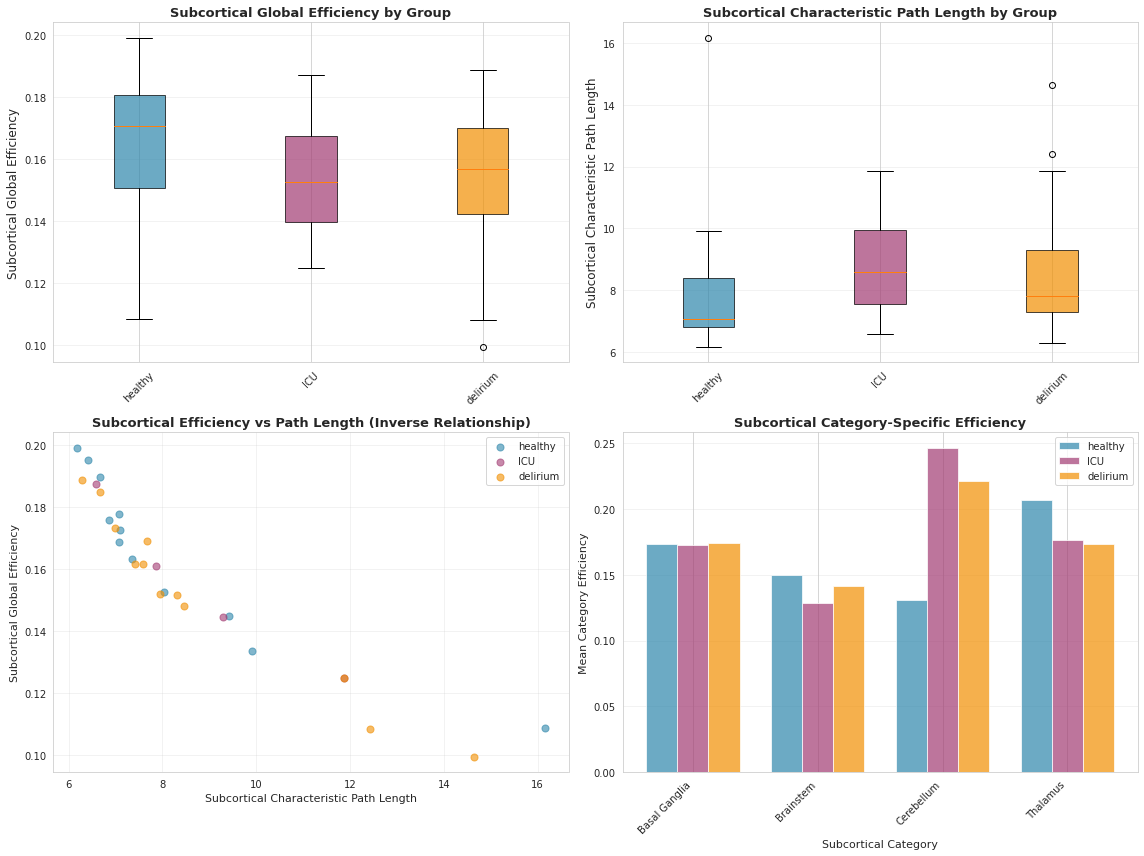



5. SUMMARY
Subcortical efficiency and path length analysis complete!
✓ Analyzed 28 subjects across 3 groups
✓ Computed overall subcortical and category-specific efficiency and path length
✓ Performed non-parametric statistical comparisons

Interpretation hints:
  - Longer subcortical path length → impaired subcortical structural integration
  - Reduced subcortical efficiency → less coordinated subcortical information flow
  - Category-specific patterns may reveal selective subcortical vulnerability

Note on Amygdala:
  - Amygdala efficiency is often NaN because left and right amygdala parcels
    typically have no direct structural connections (not a data issue)
  - Consider analyzing Amygdala connectivity to other regions instead of within-Amygdala


In [53]:
# ============================================================================
# ANALYSIS 3: SUBCORTICAL EFFICIENCY / PATH LENGTH
# ============================================================================
# Investigated Topic: Do delirium patients have longer path lengths and 
# reduced integration in their subcortical structural network compared to controls?
# ============================================================================

print("="*80)
print("ANALYSIS 3: SUBCORTICAL EFFICIENCY / PATH LENGTH")
print("="*80)
print("\nInvestigating: Do delirium patients have longer path lengths and")
print("reduced integration in their subcortical structural network compared to controls?\n")

# Load parcels labels Excel file (if not already loaded)
if 'parcel_to_category' not in locals():
    parcels_labels_path = ROOT_DIR / "atlas" / "parcels_label.xlsx"
    parcels_df = pd.read_excel(parcels_labels_path)
    
    # Filter subcortical parcels (361-432)
    subcort_df = parcels_df[(parcels_df['parcel_index'] >= 361) & (parcels_df['parcel_index'] <= 432)].copy()
    
    # Create mapping function to categorize subcortical regions
    def categorize_subcortical(area_desc):
        """Categorize subcortical regions into groups."""
        if pd.isna(area_desc):
            return "Unknown"
        area_desc = str(area_desc).lower()
        if "thalamus" in area_desc:
            return "Thalamus"
        elif any(x in area_desc for x in ["putamen", "caudate", "nucleus accumbens", "globus pallidus"]):
            return "Basal Ganglia"
        elif any(x in area_desc for x in ["substantia nigra", "ventral tegmental", "mammillary", 
                                           "septal", "nucleus basalis", "brainstem"]):
            return "Brainstem"
        elif "amygdala" in area_desc:
            return "Amygdala"
        elif "cerebellum" in area_desc:
            return "Cerebellum"
        else:
            return "Other"
    
    # Add category column
    subcort_df['category'] = subcort_df['area_describtion'].apply(categorize_subcortical)
    
    # Create mapping: parcel_index -> category
    parcel_to_category = {}
    for _, row in subcort_df.iterrows():
        parcel_id = int(row['parcel_index'])
        category = row['category']
        parcel_to_category[parcel_id] = category
    
    print(f"Loaded subcortical categorization for {len(parcel_to_category)} parcels")
    print(f"Category distribution: {subcort_df['category'].value_counts().to_dict()}\n")

# Use same normalization settings as whole-brain analysis
NORMALIZE_BY = 'mean'   # 'mean' or 'max'
TARGET_DENSITY = 0.15   # Keep top 15% of edges; set None to disable
LOG_TRANSFORM = False   # True to apply log1p before normalization

print("Normalization settings (same as whole-brain analysis):")
print(f"  Normalize by: {NORMALIZE_BY} of non-zero weights")
print(f"  Target density: {TARGET_DENSITY if TARGET_DENSITY else 'None'}")
print(f"  Log transform: {LOG_TRANSFORM}\n")

# ---------------------------------------------------------------------------
# Compute subcortical efficiency / path length for each subject
# ---------------------------------------------------------------------------
subcort_efficiency_metrics = []

for group_name, group_subjects in GROUPS.items():
    for subj in group_subjects:
        if subj in connectomes_corr:
            # Size-corrected connectome
            matrix = prepare_matrix(connectomes_corr[subj])
            
            # Extract subcortical submatrix (parcels 361-432, indices 360-431)
            subcort_indices = list(range(360, 432))  # 0-indexed: 360-431
            subcort_matrix = matrix[np.ix_(subcort_indices, subcort_indices)]
            
            # Normalize subcortical matrix ONCE
            normalized_subcort = normalize_connectome(
                subcort_matrix,
                normalize_by=NORMALIZE_BY,
                target_density=TARGET_DENSITY,
                log_transform=LOG_TRANSFORM
            )
            
            # Overall subcortical metrics
            subcort_efficiency, subcort_path = compute_efficiency_pathlength(
                normalized_subcort,
                use_bct=USE_BCT
            )
            
            metrics = {
                'subject': subj,
                'group': group_name,
                'subcort_global_efficiency': subcort_efficiency,
                'subcort_char_path_length': subcort_path
            }
            
            # Category-specific metrics: SUBSELECT ONLY (no re-normalization)
            for category in ['Thalamus', 'Basal Ganglia', 'Brainstem', 'Amygdala', 'Cerebellum']:
                # Find parcels in this category
                category_parcels = [pid for pid, cat in parcel_to_category.items() if cat == category]
                if len(category_parcels) > 0:
                    # Get indices for these parcels within subcortical matrix (0-indexed: parcel_id - 1, then shift by 360)
                    category_indices = [pid - 1 - 360 for pid in category_parcels if 361 <= pid <= 432]
                    category_indices = [idx for idx in category_indices if 0 <= idx < 72]
                    
                    if len(category_indices) > 1:  # Need at least 2 nodes
                        # Extract submatrix for this category from normalized subcortical matrix
                        cat_submatrix = normalized_subcort[np.ix_(category_indices, category_indices)]
                        
                        # Check if there are any edges (required for efficiency computation)
                        # Note: Amygdala often has zero within-category edges (left-right not directly connected)
                        if np.count_nonzero(cat_submatrix) > 0:
                            cat_efficiency, cat_path = compute_efficiency_pathlength(
                                cat_submatrix,
                                use_bct=USE_BCT
                            )
                            cat_key = category.replace(" ", "_").lower()
                            metrics[f'category_{cat_key}_efficiency'] = cat_efficiency
                            metrics[f'category_{cat_key}_pathlength'] = cat_path
                        # If no edges, efficiency/path length are undefined (will be NaN in DataFrame)
            
            subcort_efficiency_metrics.append(metrics)

# Convert to DataFrame
subcort_efficiency_df = pd.DataFrame(subcort_efficiency_metrics)

print(f"Computed subcortical efficiency metrics for {len(subcort_efficiency_df)} subjects")
print(f"Groups: {subcort_efficiency_df['group'].value_counts().to_dict()}\n")

# ============================================================================
# Statistical Analysis
# ============================================================================
print("="*80)
print("STATISTICAL COMPARISONS")
print("="*80)

# 1. Subcortical Global Efficiency
print("\n1. SUBCORTICAL GLOBAL EFFICIENCY")
print("-" * 80)
for group_name in GROUPS.keys():
    group_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_name]['subcort_global_efficiency'].dropna()
    if len(group_data) > 0:
        print(f"{group_name}:")
        print(f"  Mean:   {group_data.mean():.6f} ± {group_data.std():.6f}")
        print(f"  Median: {group_data.median():.6f}")
        print(f"  Range:  [{group_data.min():.6f}, {group_data.max():.6f}]")
        print(f"  N:      {len(group_data)}")

# Statistical tests: Kruskal-Wallis + pairwise comparisons
print("\nOmnibus test (Kruskal-Wallis):")
group_names = list(GROUPS.keys())
all_groups_data = [subcort_efficiency_df[subcort_efficiency_df['group'] == g]['subcort_global_efficiency'].dropna().values 
                   for g in group_names]
if all(len(data) > 0 for data in all_groups_data):
    try:
        h_stat, pval_kw = stats.kruskal(*all_groups_data)
        print(f"  H-statistic: {h_stat:.4f}, p-value: {pval_kw:.6f}")
        print(f"  {'✓ Significant differences detected' if pval_kw < 0.05 else '✗ No significant differences'} (α=0.05)")
        
        if pval_kw < 0.05:
            print("\nPairwise comparisons (Mann-Whitney U test with FDR correction):")
            from statsmodels.stats.multitest import multipletests
            pairwise_pvals = []
            pairwise_comparisons = []
            
            for i in range(len(group_names)):
                for j in range(i+1, len(group_names)):
                    g1_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_names[i]]['subcort_global_efficiency'].dropna().values
                    g2_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_names[j]]['subcort_global_efficiency'].dropna().values
                    
                    if len(g1_data) > 0 and len(g2_data) > 0:
                        try:
                            u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                            pairwise_pvals.append(pval)
                            pairwise_comparisons.append((group_names[i], group_names[j], u_stat, pval))
                        except ValueError:
                            pass
            
            if len(pairwise_pvals) > 0:
                _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                
                for (g1, g2, u_stat, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                    sig = '✓' if pval_corr < 0.05 else '✗'
                    print(f"  {sig} {g1} vs {g2}: U={u_stat:.2f}, p={pval_uncorr:.6f} (FDR-corrected: {pval_corr:.6f})")
        else:
            print("\n  Omnibus test not significant - skipping pairwise comparisons")
    except ValueError as e:
        print(f"  Cannot perform Kruskal-Wallis test: {e}")

# 2. Subcortical Characteristic Path Length
print("\n\n2. SUBCORTICAL CHARACTERISTIC PATH LENGTH")
print("-" * 80)
for group_name in GROUPS.keys():
    group_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_name]['subcort_char_path_length'].dropna()
    if len(group_data) > 0:
        print(f"{group_name}:")
        print(f"  Mean:   {group_data.mean():.6f} ± {group_data.std():.6f}")
        print(f"  Median: {group_data.median():.6f}")
        print(f"  Range:  [{group_data.min():.6f}, {group_data.max():.6f}]")
        print(f"  N:      {len(group_data)}")

# Statistical tests: Kruskal-Wallis + pairwise comparisons
print("\nOmnibus test (Kruskal-Wallis):")
all_groups_data = [subcort_efficiency_df[subcort_efficiency_df['group'] == g]['subcort_char_path_length'].dropna().values 
                   for g in group_names]
if all(len(data) > 0 for data in all_groups_data):
    try:
        h_stat, pval_kw = stats.kruskal(*all_groups_data)
        print(f"  H-statistic: {h_stat:.4f}, p-value: {pval_kw:.6f}")
        print(f"  {'✓ Significant differences detected' if pval_kw < 0.05 else '✗ No significant differences'} (α=0.05)")
        
        if pval_kw < 0.05:
            print("\nPairwise comparisons (Mann-Whitney U test with FDR correction):")
            from statsmodels.stats.multitest import multipletests
            pairwise_pvals = []
            pairwise_comparisons = []
            
            for i in range(len(group_names)):
                for j in range(i+1, len(group_names)):
                    g1_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_names[i]]['subcort_char_path_length'].dropna().values
                    g2_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_names[j]]['subcort_char_path_length'].dropna().values
                    
                    if len(g1_data) > 0 and len(g2_data) > 0:
                        try:
                            u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                            pairwise_pvals.append(pval)
                            pairwise_comparisons.append((group_names[i], group_names[j], u_stat, pval))
                        except ValueError:
                            pass
            
            if len(pairwise_pvals) > 0:
                _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                
                for (g1, g2, u_stat, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                    sig = '✓' if pval_corr < 0.05 else '✗'
                    print(f"  {sig} {g1} vs {g2}: U={u_stat:.2f}, p={pval_uncorr:.6f} (FDR-corrected: {pval_corr:.6f})")
        else:
            print("\n  Omnibus test not significant - skipping pairwise comparisons")
    except ValueError as e:
        print(f"  Cannot perform Kruskal-Wallis test: {e}")

# 3. Category-specific efficiency
print("\n\n3. EFFICIENCY BY SUBCORTICAL CATEGORY")
print("-" * 80)
print("Note: Amygdala efficiency may be NaN for most subjects because left and right")
print("amygdala parcels typically have no direct structural connections.\n")

category_efficiency_cols = [
    col for col in subcort_efficiency_df.columns
    if col.endswith('_efficiency') and 'category' in col
]
category_names_map = {
    'category_thalamus_efficiency': 'Thalamus',
    'category_basal_ganglia_efficiency': 'Basal Ganglia',
    'category_brainstem_efficiency': 'Brainstem',
    'category_amygdala_efficiency': 'Amygdala',
    'category_cerebellum_efficiency': 'Cerebellum'
}

for col_name in sorted(category_efficiency_cols):
    cat_name = category_names_map.get(col_name, col_name.replace('category_', '').replace('_efficiency', '').replace('_', ' ').title())
    print(f"\n{cat_name}:")
    for group_name in GROUPS.keys():
        group_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_name][col_name].dropna()
        if len(group_data) > 0:
            print(f"  {group_name}: Mean={group_data.mean():.6f} ± {group_data.std():.6f}, "
                  f"Median={group_data.median():.6f}, N={len(group_data)}")
    
    # Group comparisons: Kruskal-Wallis + pairwise
    print("  Omnibus test (Kruskal-Wallis):")
    all_groups_data = [subcort_efficiency_df[subcort_efficiency_df['group'] == g][col_name].dropna().values 
                      for g in group_names]
    if all(len(data) > 0 for data in all_groups_data):
        try:
            h_stat, pval_kw = stats.kruskal(*all_groups_data)
            sig_kw = '✓' if pval_kw < 0.05 else '✗'
            print(f"    {sig_kw} H={h_stat:.4f}, p={pval_kw:.6f}")
            
            if pval_kw < 0.05:
                print("  Pairwise comparisons (FDR-corrected):")
                from statsmodels.stats.multitest import multipletests
                pairwise_pvals = []
                pairwise_comparisons = []
                
                for i in range(len(group_names)):
                    for j in range(i+1, len(group_names)):
                        g1_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_names[i]][col_name].dropna().values
                        g2_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_names[j]][col_name].dropna().values
                        
                        if len(g1_data) > 0 and len(g2_data) > 0:
                            try:
                                u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                                pairwise_pvals.append(pval)
                                pairwise_comparisons.append((group_names[i], group_names[j], pval))
                            except ValueError:
                                pass
                
                if len(pairwise_pvals) > 0:
                    _, pvals_corrected, _, _ = multipletests(pairwise_pvals, method='fdr_bh', alpha=0.05)
                    
                    for (g1, g2, pval_uncorr), pval_corr in zip(pairwise_comparisons, pvals_corrected):
                        sig = '✓' if pval_corr < 0.05 else '✗'
                        print(f"    {sig} {g1} vs {g2}: p={pval_uncorr:.6f} (FDR: {pval_corr:.6f})")
        except ValueError:
            pass

# ============================================================================
# Visualization
# ============================================================================
print("\n\n4. VISUALIZATION")
print("-" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define group order and colors
group_order = ['Group_healthy', 'Group_ICU', 'Group_delirium']
colors = ['#2E86AB', '#A23B72', '#F18F01']

# Plot 1: Subcortical global efficiency by group
ax1 = axes[0, 0]
data_to_plot = [
    subcort_efficiency_df[subcort_efficiency_df['group'] == g]['subcort_global_efficiency'].dropna().values
    for g in group_order
]
bp1 = ax1.boxplot(
    data_to_plot,
    labels=[g.replace('Group_', '') for g in group_order],
    patch_artist=True
)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Subcortical Global Efficiency', fontsize=12)
ax1.set_title('Subcortical Global Efficiency by Group', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Subcortical characteristic path length by group
ax2 = axes[0, 1]
data_to_plot = [
    subcort_efficiency_df[subcort_efficiency_df['group'] == g]['subcort_char_path_length'].dropna().values
    for g in group_order
]
bp2 = ax2.boxplot(
    data_to_plot,
    labels=[g.replace('Group_', '') for g in group_order],
    patch_artist=True
)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Subcortical Characteristic Path Length', fontsize=12)
ax2.set_title('Subcortical Characteristic Path Length by Group', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Efficiency vs Path Length
ax3 = axes[1, 0]
for i, group_name in enumerate(group_order):
    group_data = subcort_efficiency_df[subcort_efficiency_df['group'] == group_name]
    valid = group_data[['subcort_global_efficiency', 'subcort_char_path_length']].dropna()
    if len(valid) > 0:
        ax3.scatter(
            valid['subcort_char_path_length'],
            valid['subcort_global_efficiency'],
            label=group_name.replace('Group_', ''),
            color=colors[i],
            alpha=0.6,
            s=50
        )
ax3.set_xlabel('Subcortical Characteristic Path Length', fontsize=11)
ax3.set_ylabel('Subcortical Global Efficiency', fontsize=11)
ax3.set_title('Subcortical Efficiency vs Path Length (Inverse Relationship)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Category-specific efficiency
ax4 = axes[1, 1]
available_categories = []
category_data = []
for col_name in sorted(category_efficiency_cols):
    cat_name = category_names_map.get(col_name, col_name.replace('category_', '').replace('_efficiency', '').replace('_', ' ').title())
    available_categories.append(cat_name)
    group_means = []
    for group_name in group_order:
        group_vals = subcort_efficiency_df[subcort_efficiency_df['group'] == group_name][col_name].dropna()
        group_means.append(group_vals.mean() if len(group_vals) > 0 else np.nan)
    category_data.append(group_means)

if len(category_data) > 0:
    category_data = np.array(category_data)
    x = np.arange(len(available_categories))
    width = 0.25
    for i, group_name in enumerate(group_order):
        ax4.bar(
            x + i*width,
            category_data[:, i],
            width,
            label=group_name.replace('Group_', ''),
            color=colors[i],
            alpha=0.7
        )
    ax4.set_xlabel('Subcortical Category', fontsize=11)
    ax4.set_ylabel('Mean Category Efficiency', fontsize=11)
    ax4.set_title('Subcortical Category-Specific Efficiency', fontsize=13, fontweight='bold')
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(available_categories, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

if 'DATA_DIR' in locals():
    plt.savefig(
        os.path.join(DATA_DIR, 'subcortical_efficiency_pathlength_analysis.png'),
        dpi=300,
        bbox_inches='tight'
    )
    print("\nFigure saved: subcortical_efficiency_pathlength_analysis.png")

plt.show()

# ============================================================================
# Summary
# ============================================================================
print("\n\n5. SUMMARY")
print("="*80)
print("Subcortical efficiency and path length analysis complete!")
print(f"✓ Analyzed {len(subcort_efficiency_df)} subjects across {len(GROUPS)} groups")
print("✓ Computed overall subcortical and category-specific efficiency and path length")
print("✓ Performed non-parametric statistical comparisons")
print("\nInterpretation hints:")
print("  - Longer subcortical path length → impaired subcortical structural integration")
print("  - Reduced subcortical efficiency → less coordinated subcortical information flow")
print("  - Category-specific patterns may reveal selective subcortical vulnerability")
print("\nNote on Amygdala:")
print("  - Amygdala efficiency is often NaN because left and right amygdala parcels")
print("    typically have no direct structural connections (not a data issue)")
print("  - Consider analyzing Amygdala connectivity to other regions instead of within-Amygdala")



ANALYSIS 3: NETWORK RESILIENCE / ATTACK SIMULATIONS

Investigating: Is the structural network in delirium patients more
vulnerable to targeted lesions (e.g., hub removal) than in controls?

STEP 1: OPTIMAL THRESHOLD INVESTIGATION

Testing different density thresholds to find optimal binary connectome...

Efficiency by density threshold:
--------------------------------------------------------------------------------
  Density 5%: Mean=0.2756 ± 0.0244, Median=0.2776, N=12
  Density 10%: Mean=0.3616 ± 0.0265, Median=0.3663, N=12
  Density 15%: Mean=0.4156 ± 0.0268, Median=0.4210, N=12
  Density 20%: Mean=0.4551 ± 0.0276, Median=0.4612, N=12
  Density 25%: Mean=0.4859 ± 0.0296, Median=0.4937, N=12
  Density 30%: Mean=0.5112 ± 0.0311, Median=0.5191, N=12

✓ Selected optimal density: 20%
  (This threshold will be used for attack simulations)

STEP 2: ATTACK SIMULATIONS

Using binary connectomes at 20% density threshold

Attack types: random, degree-based (hub removal), betweenness-based (hu

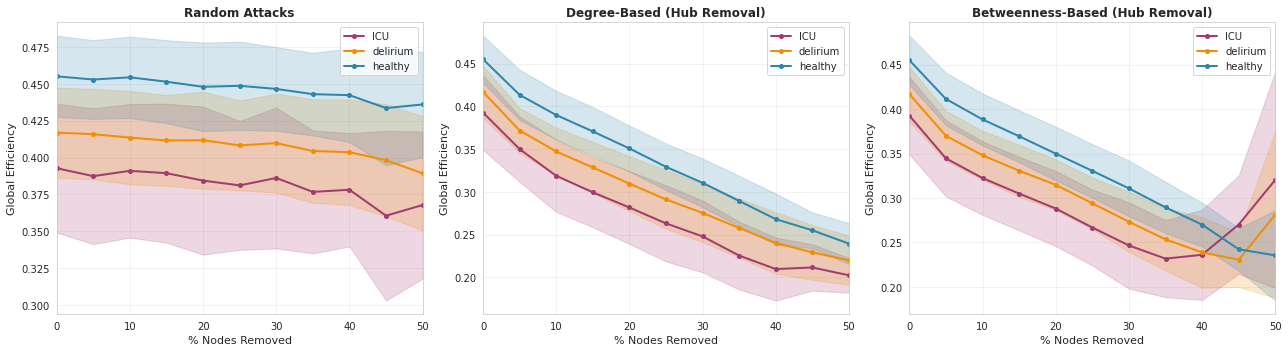



5. SUMMARY
Network resilience and attack simulation analysis complete!
✓ Analyzed 27 subjects across 3 groups
✓ Simulated random, degree-based, and betweenness-based attacks
✓ Computed efficiency decay curves for each attack type
✓ Performed statistical comparisons between groups

Interpretation:
  - Steeper decay in delirium → less resilient network
  - Targeted attacks (hubs) should show larger differences than random
  - Fragile structural architecture suggests vulnerability to disruption


In [32]:
# ============================================================================
# Analysis 3: Network Resilience / Attack Simulations
# ============================================================================
# Investigated Topic: Is the structural network in delirium patients more 
# vulnerable to targeted lesions (e.g., hub removal) than in controls?
# ============================================================================

print("="*80)
print("ANALYSIS 3: NETWORK RESILIENCE / ATTACK SIMULATIONS")
print("="*80)
print("\nInvestigating: Is the structural network in delirium patients more")
print("vulnerable to targeted lesions (e.g., hub removal) than in controls?\n")

# Import networkx for graph operations
import networkx as nx

# Helper function to compute binary efficiency from a binary matrix
def compute_binary_efficiency(binary_matrix, epsilon=1e-6):
    """
    Compute global efficiency from a binary connectivity matrix.
    
    Parameters:
    -----------
    binary_matrix : np.ndarray
        Binary adjacency matrix (0s and 1s)
    epsilon : float
        Small value for distance computation
    
    Returns:
    --------
    efficiency : float
        Global efficiency of the binary network
    """
    W = binary_matrix.astype(float).copy()
    np.fill_diagonal(W, 0.0)
    
    # Remove isolated nodes
    node_strength = W.sum(axis=0) + W.sum(axis=1)
    keep = np.where(node_strength > 0)[0]
    
    if keep.size < 2:
        return np.nan
    
    W = W[np.ix_(keep, keep)]
    
    # Convert to distance matrix (binary: connected = 1, disconnected = inf)
    # For binary graphs, we use shortest path length
    G = nx.from_numpy_array(W, create_using=nx.Graph())
    
    # Get largest connected component
    if not nx.is_connected(G):
        Gc = G.subgraph(max(nx.connected_components(G), key=len))
    else:
        Gc = G
    
    if Gc.number_of_nodes() < 2:
        return np.nan
    
    nodes = list(Gc.nodes())
    total_inv_path = 0.0
    n_paths = 0
    
    # Compute efficiency: mean of 1/shortest_path_length for all pairs
    for i, u in enumerate(nodes):
        for v in nodes[i+1:]:
            try:
                path_length = nx.shortest_path_length(Gc, u, v)
                if path_length > 0 and not np.isinf(path_length):
                    total_inv_path += 1.0 / path_length
                    n_paths += 1
            except nx.NetworkXNoPath:
                pass
    
    if n_paths == 0:
        return np.nan
    
    efficiency = total_inv_path / n_paths
    return efficiency

# Helper function to simulate attacks
def simulate_attacks(matrix, attack_type='random', attack_fractions=np.arange(0.05, 0.55, 0.05)):
    """
    Simulate network attacks by removing nodes and computing efficiency.
    
    Parameters:
    -----------
    matrix : np.ndarray
        Binary connectivity matrix
    attack_type : str
        'random', 'degree', or 'betweenness'
    attack_fractions : np.ndarray
        Fractions of nodes to remove (e.g., [0.05, 0.10, ..., 0.50])
    
    Returns:
    --------
    efficiencies : list
        Global efficiency after each attack fraction
    """
    W = matrix.astype(float).copy()
    np.fill_diagonal(W, 0.0)
    
    # Create graph
    G = nx.from_numpy_array(W, create_using=nx.Graph())
    n_nodes = G.number_of_nodes()
    
    if n_nodes < 2:
        return [np.nan] * len(attack_fractions)
    
    efficiencies = []
    
    # Compute initial efficiency
    initial_efficiency = compute_binary_efficiency(W)
    efficiencies.append(initial_efficiency)
    
    # Determine attack order based on attack type
    if attack_type == 'random':
        # Random order (will be shuffled for each fraction)
        node_order = list(G.nodes())
    elif attack_type == 'degree':
        # Order by degree (highest first)
        degrees = dict(G.degree())
        node_order = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)
    elif attack_type == 'betweenness':
        # Order by betweenness centrality (highest first)
        betweenness = nx.betweenness_centrality(G)
        node_order = sorted(betweenness.keys(), key=lambda x: betweenness[x], reverse=True)
    else:
        raise ValueError(f"Unknown attack type: {attack_type}")
    
    # Simulate attacks at different fractions
    for frac in attack_fractions[1:]:  # Skip 0 (already computed)
        n_remove = int(frac * n_nodes)
        
        if attack_type == 'random':
            # Shuffle for random attack
            nodes_to_remove = np.random.choice(node_order, size=n_remove, replace=False).tolist()
        else:
            # Remove top nodes for targeted attacks
            nodes_to_remove = node_order[:n_remove]
        
        # Create attacked graph
        G_attacked = G.copy()
        G_attacked.remove_nodes_from(nodes_to_remove)
        
        # Convert back to matrix and compute efficiency
        if G_attacked.number_of_nodes() > 0:
            attacked_matrix = nx.to_numpy_array(G_attacked, nodelist=sorted(G_attacked.nodes()))
            efficiency = compute_binary_efficiency(attacked_matrix)
        else:
            efficiency = 0.0
        
        efficiencies.append(efficiency)
    
    return efficiencies

# Step 1: Investigate optimal threshold for binary connectomes
print("="*80)
print("STEP 1: OPTIMAL THRESHOLD INVESTIGATION")
print("="*80)
print("\nTesting different density thresholds to find optimal binary connectome...\n")

# Test thresholds
test_thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
threshold_results = []

for subj in subjects:
    if subj in connectomes_corr:
        matrix = prepare_matrix(connectomes_corr[subj])
        
        # Normalize matrix (same as in efficiency analysis)
        normalized_matrix = normalize_connectome(
            matrix,
            normalize_by=NORMALIZE_BY,
            target_density=None,  # Don't threshold yet
            log_transform=LOG_TRANSFORM
        )
        
        for density in test_thresholds:
            # Create binary matrix at this density
            vals = normalized_matrix[normalized_matrix > 0]
            if vals.size > 0:
                thr = np.percentile(vals, 100 * (1 - density))
                binary_matrix = (normalized_matrix >= thr).astype(float)
                np.fill_diagonal(binary_matrix, 0.0)
                
                # Compute efficiency
                efficiency = compute_binary_efficiency(binary_matrix)
                
                if not np.isnan(efficiency):
                    threshold_results.append({
                        'subject': subj,
                        'density': density,
                        'efficiency': efficiency,
                        'n_edges': np.sum(binary_matrix > 0) / 2  # Undirected
                    })

if len(threshold_results) > 0:
    threshold_df = pd.DataFrame(threshold_results)
    
    # Group by density and compute statistics
    print("Efficiency by density threshold:")
    print("-" * 80)
    for density in test_thresholds:
        density_data = threshold_df[threshold_df['density'] == density]['efficiency'].dropna()
        if len(density_data) > 0:
            print(f"  Density {density:.0%}: Mean={density_data.mean():.4f} ± {density_data.std():.4f}, "
                  f"Median={density_data.median():.4f}, N={len(density_data)}")
    
    # Choose optimal threshold (highest mean efficiency, but not too sparse)
    # Use 10-15% as reasonable range
    optimal_density = 0.15  # Default
    density_means = threshold_df.groupby('density')['efficiency'].mean()
    if len(density_means) > 0:
        # Prefer densities in 10-20% range with good efficiency
        candidate_densities = [d for d in test_thresholds if 0.10 <= d <= 0.20]
        if len(candidate_densities) > 0:
            optimal_density = max(candidate_densities, key=lambda d: density_means.get(d, 0))
    
    print(f"\n✓ Selected optimal density: {optimal_density:.0%}")
    print(f"  (This threshold will be used for attack simulations)\n")
else:
    optimal_density = 0.15
    print(f"⚠ Using default density: {optimal_density:.0%}\n")

# Step 2: Run attack simulations
print("="*80)
print("STEP 2: ATTACK SIMULATIONS")
print("="*80)
print(f"\nUsing binary connectomes at {optimal_density:.0%} density threshold\n")
print("Attack types: random, degree-based (hub removal), betweenness-based (hub removal)\n")

# Attack fractions (percentage of nodes removed)
attack_fractions = np.concatenate([[0.0], np.arange(0.05, 0.55, 0.05)])  # 0%, 5%, 10%, ..., 50%

# Set random seed for reproducibility
np.random.seed(42)

# Run simulations for each subject
attack_results = []

for group_name, group_subjects in GROUPS.items():
    for subj in group_subjects:
        if subj in connectomes_corr:
            matrix = prepare_matrix(connectomes_corr[subj])
            
            # Normalize and threshold to binary
            normalized_matrix = normalize_connectome(
                matrix,
                normalize_by=NORMALIZE_BY,
                target_density=None,
                log_transform=LOG_TRANSFORM
            )
            
            # Create binary matrix at optimal density
            vals = normalized_matrix[normalized_matrix > 0]
            if vals.size > 0:
                thr = np.percentile(vals, 100 * (1 - optimal_density))
                binary_matrix = (normalized_matrix >= thr).astype(float)
                np.fill_diagonal(binary_matrix, 0.0)
                
                # Run different attack types
                for attack_type in ['random', 'degree', 'betweenness']:
                    efficiencies = simulate_attacks(binary_matrix, attack_type=attack_type, 
                                                   attack_fractions=attack_fractions)
                    
                    for frac, eff in zip(attack_fractions, efficiencies):
                        attack_results.append({
                            'subject': subj,
                            'group': group_name,
                            'attack_type': attack_type,
                            'fraction_removed': frac,
                            'efficiency': eff
                        })

# Convert to DataFrame
attack_df = pd.DataFrame(attack_results)

print(f"Simulated attacks for {len(attack_df['subject'].unique())} subjects")
print(f"Total simulations: {len(attack_df)}\n")

# Step 3: Statistical analysis and visualization
print("="*80)
print("STEP 3: STATISTICAL ANALYSIS")
print("="*80)

# Compute group-averaged efficiency decay curves
group_curves = {}

for attack_type in ['random', 'degree', 'betweenness']:
    group_curves[attack_type] = {}
    
    for group_name in GROUPS.keys():
        group_data = attack_df[(attack_df['group'] == group_name) & 
                               (attack_df['attack_type'] == attack_type)]
        
        if len(group_data) > 0:
            # Average efficiency at each fraction across subjects
            mean_efficiencies = []
            std_efficiencies = []
            
            for frac in attack_fractions:
                frac_data = group_data[group_data['fraction_removed'] == frac]['efficiency'].dropna()
                if len(frac_data) > 0:
                    mean_efficiencies.append(frac_data.mean())
                    std_efficiencies.append(frac_data.std())
                else:
                    mean_efficiencies.append(np.nan)
                    std_efficiencies.append(np.nan)
            
            group_curves[attack_type][group_name] = {
                'mean': np.array(mean_efficiencies),
                'std': np.array(std_efficiencies),
                'fractions': attack_fractions
            }

# Statistical comparisons at key attack fractions
print("\nStatistical comparisons at 25% node removal (Mann-Whitney U test):")
print("-" * 80)

key_fraction = 0.25
for attack_type in ['random', 'degree', 'betweenness']:
    print(f"\n{attack_type.upper()} attacks:")
    
    # Get efficiency at key fraction for each group
    frac_data = attack_df[(attack_df['fraction_removed'] == key_fraction) & 
                          (attack_df['attack_type'] == attack_type)]
    
    group_names = list(GROUPS.keys())
    for i in range(len(group_names)):
        for j in range(i+1, len(group_names)):
            g1_data = frac_data[frac_data['group'] == group_names[i]]['efficiency'].dropna().values
            g2_data = frac_data[frac_data['group'] == group_names[j]]['efficiency'].dropna().values
            
            if len(g1_data) > 0 and len(g2_data) > 0:
                try:
                    u_stat, pval = stats.mannwhitneyu(g1_data, g2_data, alternative='two-sided')
                    sig = '✓' if pval < 0.05 else '✗'
                    print(f"  {sig} {group_names[i]} vs {group_names[j]}: U={u_stat:.2f}, p={pval:.6f}")
                except ValueError:
                    pass

# Step 4: Visualization
print("\n\n" + "="*80)
print("STEP 4: VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {'Group_healthy': '#2E86AB', 'Group_ICU': '#A23B72', 'Group_delirium': '#F18F01'}
attack_labels = {'random': 'Random Attacks', 'degree': 'Degree-Based (Hub Removal)', 
                 'betweenness': 'Betweenness-Based (Hub Removal)'}

for idx, attack_type in enumerate(['random', 'degree', 'betweenness']):
    ax = axes[idx]
    
    for group_name in GROUPS.keys():
        if group_name in group_curves[attack_type]:
            curve = group_curves[attack_type][group_name]
            fractions = curve['fractions'] * 100  # Convert to percentage
            mean_eff = curve['mean']
            std_eff = curve['std']
            
            # Plot mean curve
            valid_mask = ~np.isnan(mean_eff)
            ax.plot(fractions[valid_mask], mean_eff[valid_mask], 
                   label=group_name.replace('Group_', ''), 
                   color=colors[group_name], linewidth=2, marker='o', markersize=4)
            
            # Add error bars (std)
            ax.fill_between(fractions[valid_mask], 
                          mean_eff[valid_mask] - std_eff[valid_mask],
                          mean_eff[valid_mask] + std_eff[valid_mask],
                          alpha=0.2, color=colors[group_name])
    
    ax.set_xlabel('% Nodes Removed', fontsize=11)
    ax.set_ylabel('Global Efficiency', fontsize=11)
    ax.set_title(attack_labels[attack_type], fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 50])

plt.tight_layout()

if 'DATA_DIR' in locals():
    plt.savefig(os.path.join(DATA_DIR, 'network_resilience_attack_simulations.png'), 
               dpi=300, bbox_inches='tight')
    print(f"\nFigure saved: network_resilience_attack_simulations.png")

plt.show()

# Summary
print("\n\n" + "="*80)
print("5. SUMMARY")
print("="*80)
print("Network resilience and attack simulation analysis complete!")
print(f"✓ Analyzed {len(attack_df['subject'].unique())} subjects across {len(GROUPS)} groups")
print(f"✓ Simulated random, degree-based, and betweenness-based attacks")
print(f"✓ Computed efficiency decay curves for each attack type")
print(f"✓ Performed statistical comparisons between groups")
print("\nInterpretation:")
print("  - Steeper decay in delirium → less resilient network")
print("  - Targeted attacks (hubs) should show larger differences than random")
print("  - Fragile structural architecture suggests vulnerability to disruption")

